# Is MeOH spontelectric based on VUV spectroscopy?

_Authors: Andrew Cassidy (1), Alfred Hopkinson (1), Marta Podgorny (2), Anita Dawes (2), David Field (1,3)_

1. [Center for Interstellar Catalysis, Department of Physics and Astronomy, Aarhus University, DK](https://www.phys.au.dk/intercat)
2. [Open University](https://kdvi.uva.nl/)
3. [Department of Physics and Astronomy, Aarhus University, DK](https://www.phys.au.dk)


In [38]:
# import image module
from IPython.display import Image
from IPython.display import HTML, Markdown
import math
import numpy, pandas 
import matplotlib.pyplot as plt
import openpyxl
import xlrd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy import __version__

### Abstract <a class="anchor" id="abstract"></a>
If MeOH is spontelectric, then the temperature dependence of the field induced shift in VUV peak positions, is caused by the spontectric field. That is, the magnitiude of the field that produces a shift (based on the exciton model) can be explained by fitting the field data with the spontelectric model!

### The how of if<a class="anchor" id="how?"></a>
MeOH was deposited at a range of temperatures and VUV spectra were recorded. These spectra were fit with two peaks G1 (blue) and G2 (green). Only G2 (green) shifts with temperature. Ignore G1.

### Figure 1: MeOH temperature dependence of G1 and G2  <a class="anchor" id="figure_1"></a>

![MeOHVUVdata](images/MeOHVUVdata.png)

We propose that G2 shifts with temperature because some electric field, called E$_{SP}$, acts to expand the size of the exciton related to this peak. The temperature dependence of this effect, *i.e*, the field effect on the size of the exicton is given by **Eqn. 1**

[Eqn. 1]<a class="anchor" id="equation_1"></a>
\begin{align}
\mathrm{(1)} \quad \Delta E = 2 \Delta r E_{SP}
\end{align}

If we start with some value of r and estimate a value for $\Delta E$ from the spectra, we can calculate $E_{SP}$ using the equation in figure 2

### Figure 2: Eq to turn $\Delta E$ into $E_{SP}$  <a class="anchor" id="figure_2"></a>
![Esp_equation](images/Esp_equation.png)
**Figure 2**: _Notes: DE = $\Delta E$ , so the energy difference between $\lambda_{T}$ and $\lambda_{0}$ in au; eps = $\epsilon$ which is "refractive index", n$^{2}$_ ; 

This is stage 1 of 4 stages as accurately laid out in figure 3.
### Figure 3: Mind splat in the catalytic space one day  <a class="anchor" id="figure_3"></a>
![mindsplat](images/mindsplat.jpg)


**Stage 1**: Find $E_{SP}$

**Stage 2**: Convert $E_{SP}$ into $(\langle\mu_z\rangle/\mu)$ using:
[Eqn. 2]<a class="anchor" id="equation_2"></a>
\begin{align}
\mathrm{(2)} \quad E_{SP} = E_{A} \langle\mu_z\rangle/\mu
\end{align}

**Stage 3**:
Use the Spontelectric model developed by Frank to derive caluclated values of  $E_{SP}$ and $(\langle\mu_z\rangle/\mu)$; for these assumed values of "r" and $\lambda_{0}$

**Stage 4**:
take the residuals between the calculated and observed values of $E_{SP}$ and/or $(\langle\mu_z\rangle/\mu)$ and use a matrix plot to find the best [r:$\lambda_{0}$]space


### Stage 1: Calculate $E_{SP}$


In [64]:
#What molecule are we looking at?
name='MeOH'
filename='3rd_dep_peak2_MeOH'
working_dir=(r'C:\Users\au302163\Fit_VUV_Spont')


df = pd.read_csv('3rd_dep_peak2_MeOH.txt', delim_whitespace=True, header=None)
xdataraw = df.iloc[:,0]
ydataraw = df.iloc[:,1]

xdata = xdataraw*3.16683e-6
ydata = (ydataraw*1e-9)/5.29177e-11


l0=(128) # lambda_0 in nm

r=(2.38) # in nm electron-hole radius
eps = (1.26**2) #epsilon - usually take (refractive index)**2
r_i=str(r)
l0_j=str(l0)
ij_space=('radius: '+r_i+' nm - and l0: '+l0_j+' nm')

mu_g_Debye = 1.6489 # D gas phase dipole (MeOH = 1.6489)
a_SI = 3.31e-30 # polarizability in m**3
k = 11.034          # k value
s_nm = 0.25365   # layer spacing in nm 

In [55]:
#Define the relevant functions

def Langevin(x):
#
# the Langevin function for a single real argument x
# for small absolute values of x (<1.0e-6) an approximation is used that is
# correct to second order, i.e. the error term is O(eps^3)
#
    if (abs(x)>1.0e-6) :
        y=math.cosh(x)/math.sinh(x)-1/x
    else :
        y=x/3.0
    return y

def DerLangevin(x):
#
# the derivative of the Langevin function for a single real argument x
# for small absolute values of x (<1.0e-6) an approximation is used that is
# correct to second order, i.e. the error term is O(eps^2)
#
    if (abs(x)>1.0e-6) :
        auxden=1.0/math.sinh(x)
        y=-1.0*auxden*auxden+1.0/x/x
    else :
        y=1.0/3.0
    return y

def DDerLangevin(x):
#
# the second derivative of the Langevin function for a single real argument x
# for small absolute values of x (<1.0e-6) an approximation is used that is
# correct to second order, i.e. the error term is O(eps^2)
#
    if (abs(x)>1.0e-6) :
        auxden=1.0/math.sinh(x)
        y=2.0*(math.cosh(x)*auxden*auxden*auxden-1.0/x/x/x)
    else :
        y=0.0
    return y

def LangevInv(y):
#
# the inverse of the Langevin function for a single real argument y
# this uses an expression derived by Petrosyan (2017)
# 02/06/2022 (FPP): the approximation is only correct for positive values of the argument, so
#   in order to also work for negative values I have modified the function.
#
    if (abs(y)<1.0) :
        yab=abs(y)
        x=y*(3.0+yab*math.sin(7.0*yab/2.0)/5.0+yab*yab/(1-yab))
        return x
    else :
        print("LangevInv: argument out of range, stopping.")
        return

def DerLangevInv(y):
#
# the derivative of the inverse of the Langevin function for a single real argument y
# this uses an expression for the inverse of the Langevin function derived by Petrosyan (2017)
# 02/06/2022 (FPP): the approximation is only correct for positive values of the argument, so
#   in order to also work for negative values I have modified the function.
#
    if (abs(y)<1.0) :
        yab=abs(y)
        x=3.0+2.0*yab*math.sin(7.0*yab/2.0)/5.0+7.0*yab*yab*math.cos(7.0*yab/2.0)/10.0
        x+=(3.0-2.0*yab)*yab*yab/(1-yab)/(1-yab)
        return x
    else :
        print("DerLangevInv: argument out of range, stopping.")
        return
    
def NeaterOut(x,s):
#
# prepares the strings for providing nicer-looking output of parameters with uncertainties
    spon=math.floor(math.log10(abs(s)))+1
    divis=math.exp(spon*math.log(10))
    xout=x/divis
    sout=s/divis
    string='({0:.2f}$\pm${1:.2f}) $10^{2:n}$'.format(xout,sout,spon)
    return string

def ConstrLSQ(x,y,wht):
#
# Solve a linear least squares problem for 1 dependent variable y as a function of
# nvar independent variables x.
# Linear least-squares problems for more than 1 parameter require a matrix inversion
# Here for arbitrary numbers of parameters the required matrix elements are 
# calculated and the matrix is inverted, after which the parameters are obtained.
# Input: a matrix x[nvar,ndat] containing ndat measurements of nvar independent
#           variables x
#        a vector y[ndat] containing the dependent variable
#        a vector of weights [ndat] which is used to give particular measurements 
#           less weight if desired. 
# NOTE: if a constant offset is required as one of the free parameters, an x-variable 
# which is all 1's must be present in (added to) the input matrix x.
#
    if (x.shape[1] != y.shape[0]) :
        print("ConstrLSQ: unequal array lengths, stopping.")
        par=numpy.array([])
        return
    if (x.shape[1] != wht.shape[0]) :
        print("ConstrLSQ: unequal array lengths, stopping.")
        par=numpy.array([])
        return

#
# declaration of local variables
    ndat=xdat.shape[1]
    nvar=xdat.shape[0]
    whtsum=0.0
    ysum=0.0
    xsum=numpy.array([0.0]*nvar)
    xysum=numpy.array([0.0]*nvar)
    xsqsum=numpy.array([[0.0]*2,[0.0]*2])
    Ainv=numpy.array([[0.0]*2,[0.0]*2])
    par=numpy.array([0.0]*nvar)
#
# weighted sum of measurements of dependent variable 
    for i in range(0,ndat):
        ysum+=y[i]*wht[i]
#
# weighted sum of measurements of independent variables and of cross-products on independent variables
# with each other and with dependent variable.
    for k in range(0,nvar):
        for i in range(0,ndat):
            whtsum+=wht[i]
            xsum[k]+=x[k,i]*wht[i]
            xysum[k]+=x[k,i]*y[i]*wht[i]
        for l in range(0,nvar):
            for i in range(0,ndat):
                xsqsum[k,l]+=x[k,i]*x[l,i]*wht[i]
#
# start solving the set of linear equations for the linear least squares problem
    if (nvar==1) :
#
# if only one parameter to be determined
        par[0]=ysum/xsum[0]
    else:
#
# for determination of 2 parameters
        if (nvar==2) :
            Det=xsqsum[0,0]*xsqsum[1,1]-xsqsum[1,0]*xsqsum[0,1]
            if (abs(Det)>1.0e-9) :
                Ainv[0,0]=xsqsum[1,1]/Det
                Ainv[0,1]=-1.0*xsqsum[0,1]/Det
                Ainv[1,0]=-1.0*xsqsum[1,0]/Det
                Ainv[1,1]=xsqsum[0,0]/Det
                par[0]=Ainv[0,0]*xysum[0]+Ainv[0,1]*xysum[1]
                par[1]=Ainv[1,0]*xysum[0]+Ainv[1,1]*xysum[1]
            else :
                print("ConstrLSQ: singular matrix. stopping")
                par=numpy.array([])
                return
        else :
#
# the general case of 3 or more parameters to be determined.
            Ainv=numpy.linalg.inv(xsqsum)
            par=numpy.dot(Ainv,xysum)
#
    return par

# Define several conversion factors to/from atomic units
# conversion of Temp to a.u. : T [a.u.]= T [K]/factor
Ttoau=315770.0
# conversion of D to a.u. : 1 D (=Debye) = factor [a.u.]
Debye=0.393456
# Convert el. field in a.u. To V/m : E [a.u.] = E [V/m]/factor
Etoau=5.142e11
#

In [65]:
#describe the plot settings

def Figureij_space(x_E,y_E,z_E,x_mu,y_mu,z_mu,xmin,xmax,ymin,ymax,xmin_mu,xmax_mu,ymin_mu,ymax_mu,title):
#
# make a plot of the measured and modelled field
#
    fig, ax = plt.subplots(2, 2, sharex=true, gridspec_kw={'height_ratios':[3,1]}, figsize=(10, 5.4))
    fig.subplots_adjust(hspace=0)
    
    
    plt.title(title)
    ax[0,0].set_xlim(xmin, xmax)
    ax[0,0].set_ylim(ymin, ymax)
    ax[0,0].scatter(x_E, z_E, marker='+', s=40, color='red', label='observed')
    ax[0,0].scatter(x_E, y_E, marker='o', s=40, color='blue', label='model')
    #ax.set_yticks(tick)
    ax[0,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
    ax[0,0].set_ylabel('Electric Field / Vm$^{-1}$', fontsize=16, fontname='garamond')
    ax[0,0].tick_params(labelsize='large')
    ax[0,0].legend(loc=0, fontsize=14, framealpha=0)
    ax[0,0].text(20,0,legend_E)
    
    ax[0,1].set_xlim(xmin_mu, xmax_mu)
    ax[0,1].set_ylim(ymin_mu, ymax_mu)
    ax[0,1].errorbar(x_mu, z_mu, markersize=10, xerr=sigx, yerr=sigy, fmt='.', color='red', label='observed')
    ax[0,1].scatter(x_mu, y_mu, marker='^', s=50, color='blue', label='model')
    #ax.set_yticks([0.01,0.02,0.03,0.04])
    #ax.set_yticks(tick)
    ax[0,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
    ax[0,1].set_ylabel('Dipole orientation / $\mu_Z/\mu$', fontsize=16, fontname='garamond')
    ax[0,1].tick_params(labelsize='large')
    ax[0,1].legend(loc=0, fontsize=14, framealpha=0)
    ax[0,1].text(20,0,legend_mu)
    
    ax[1,0].scatter(x_E, z_E, marker='+', s=40, color='red', label='observed')
        
    ax[1,1].scatter(x_E, z_E, marker='+', s=40, color='red', label='observed')
    
    plt.savefig('Spont fit for'+ij_space)
    return

def FigureMu(x,y,z,sigx,sigy,xmin_mu,xmax_mu,ymin_mu,ymax_mu,title):
#
# make a plot of the measured and modelled z-component of mu
#
    fig, ax = plt.subplots(figsize=(10, 5.4))
    plt.title(title)
    ax.set_xlim(xmin_mu, xmax_mu)
    ax.set_ylim(ymin_mu, ymax_mu)
    ax.errorbar(x, z, markersize=10, xerr=sigx, yerr=sigy, fmt='.', color='red', label='observed')
    ax.scatter(x, y, marker='^', s=50, color='blue', label='model')
    #ax.set_yticks([0.01,0.02,0.03,0.04])
    #ax.set_yticks(tick)
    ax.set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
    ax.set_ylabel('Dipole orientation / $\mu_Z/\mu$', fontsize=16, fontname='garamond')
    ax.tick_params(labelsize='large')
    ax.legend(loc=0, fontsize=14, framealpha=0)
    ax.text(20,0,legend_mu)
    
    plt.savefig('dipole orientation for '+name+' as a function of Temperature')
    return

#

Text(0, 0.5, '$\\lambda_{T}$ / eV')

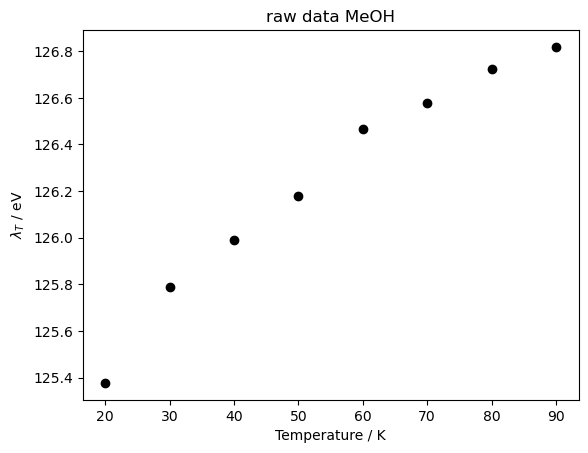

In [66]:
import os
import pandas as pd
#extract peak positions 
os.chdir(working_dir)  
df = pd.read_csv(filename+'.txt', delim_whitespace=True, header=None)
xdataraw = df.iloc[:,0] #Temperature K
ydataraw = df.iloc[:,1] #peak position nm

T_array=xdataraw.to_numpy()
xmin_mu=min(T_array - 10)
xmax_mu=max(T_array + 10)

xmin=min(T_array - 10)
xmax=max(T_array + 10)

plt.plot(xdataraw, ydataraw,'ko')
plt.title('raw data '+ name)
plt.xlabel('Temperature / K')
plt.ylabel('$\lambda_{T}$ / eV')


Text(0, 0.5, 'Energy shift from $\\lambda_{0}$ / eV')

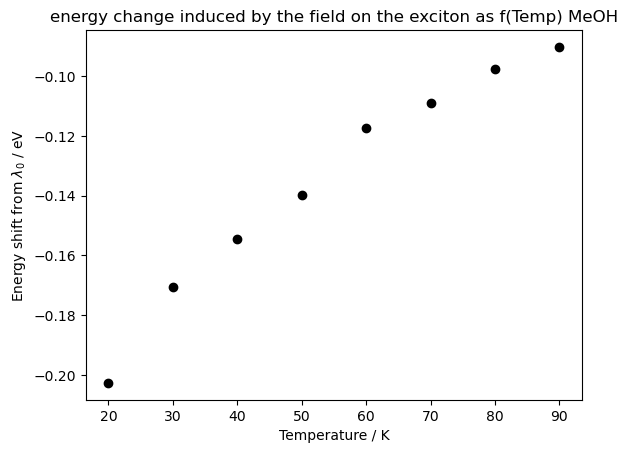

In [67]:

#Convert wavelength to eV
lambda_nm=ydataraw
lambda_eV=1239.8/lambda_nm

#Define wavelegnth with no field

l0_eV=1239.8/l0

#Calculate DE as -ve number (as test) i.e., long wavelength - short wavelength
DE_eV=(l0_eV-lambda_eV)
#convert things to atomic units
T=xdataraw*3.16683e-6
DE=DE_eV*0.036749405469679

plt.plot(xdataraw, DE_eV,'ko')
plt.title('energy change induced by the field on the exciton as f(Temp) ' +name)
plt.xlabel('Temperature / K')
plt.ylabel('Energy shift from $\lambda_{0}$ / eV')

**Figure 4**: Makes sense that lower temperatures give a peak "futher away" from the resting value of energy, i.e., 0!

Text(0, 0.5, 'Esp / V/m')

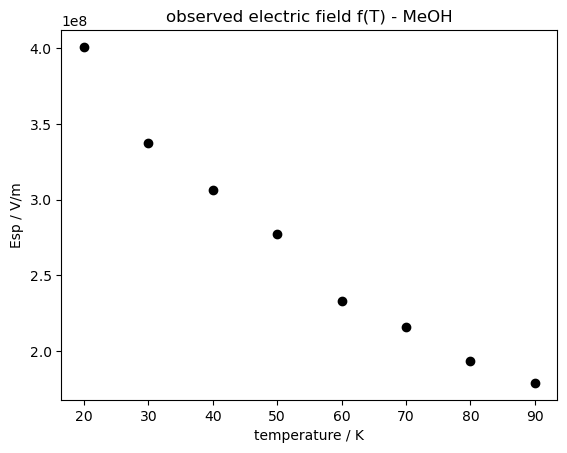

In [68]:
#David derived this equation based on the values given in the ammonia paper (see figure 3 above).
Esp_au=(1/96)*(
    -((32*DE)/r)
    +(
        (16*(2**(1/3))*DE*(6+DE*eps*r))
        /
        (r**3 *
         ((((DE**2*eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
          /
          (r**(9/2))
         )**(1/3)
        )
    )
    +
    (
        (8*(2**(2/3))*
         ((((DE**2 *eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
          /
          (r**(9/2))
         )**(1/3))
        /
        (eps))
)

Esp_Vm=Esp_au*5.14220652e+11
Esp_Vm_array=Esp_Vm.to_numpy()
ymin=min(Esp_Vm_array - Esp_Vm_array[-1])
ymax=max(Esp_Vm_array + Esp_Vm_array[-1])

#print(name+' Esp in au:','\n', Esp)

plt.plot(xdataraw, Esp_Vm, 'ko')
#plt.scatter(xdataraw, )
plt.title('observed electric field f(T) - '+name)
plt.xlabel('temperature / K')
plt.ylabel('Esp / V/m')

**Figure 5**: The calculated values of $E_{SP}$ are too big. Anything above e$^{7}$ is going to push it above $E_{A}$ and require dipole alignment above 1.

_Am I sure that the $E_{SP}$ equation is correct?_

dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 0.5092557879988514 Debye
Calculated value of E_A for MeOH is  1.6105413064194762 x 10^9 V/m


Text(0, 0.5, '$\\mu_{z}$ / $\\mu_{0}$')

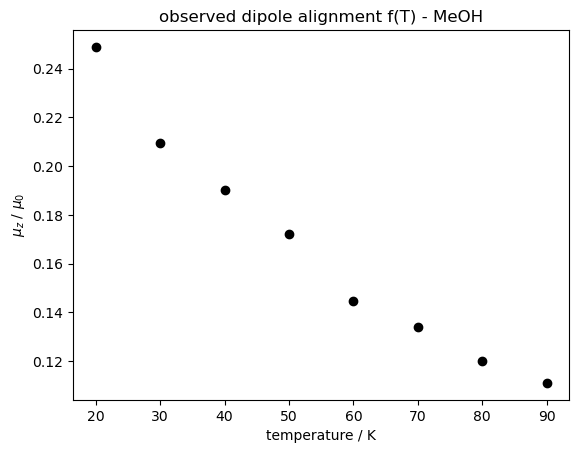

In [69]:
#Convert Esp to muz/mu0 values using a fixed value for EA value

#convert knowns into au 
a = a_SI*18897259886**3   # polarizability in au
s = (s_nm)*18.897  # estimated layer spacing converted to au
mu_g = (mu_g_Debye*0.393456)  #  gas phase dipole converted to au

mu_0 = mu_g/(1+a*k/s**3)    # dipole moment of molecule in solid state - converted to au
print('dipole moment in the gas phase for '+name+' is', mu_g_Debye, 'Debye')
print('dipole moment in the solid sate for '+name+' is', mu_0*2.541746, 'Debye')

Omega = a/(0.0084161)**(3/4)  # I dont know where the 0.0084161 value comes from

E_A=4*np.pi*mu_0/Omega
E_A_Vm = E_A*5.14220652e+11
print('Calculated value of E_A for '+name+' is ', E_A_Vm/1E9, 'x 10^9 V/m')

degree_of_alignment=Esp_Vm/E_A_Vm
muz_mu0_array=degree_of_alignment.to_numpy()
ymin_mu=min(muz_mu0_array - 0.2)
ymax_mu=max(muz_mu0_array + 0.2)

#print(degree_of_alignment)

plt.plot(xdataraw, degree_of_alignment, 'ko')
#plt.scatter(xdataraw, )
plt.title('observed dipole alignment f(T) - '+name)
plt.xlabel('temperature / K')
plt.ylabel('$\mu_{z}$ / $\mu_{0}$')



**Figure 6**: say what you see.

In [70]:
#Write data to text file
length=(len(T_array))
weight=np.ones(length)
err_muz_mu0=0.1*(muz_mu0_array)
err_T=0.1*(T_array)

os.chdir(working_dir+'\\observed_data')
data=np.column_stack((weight,muz_mu0_array,err_muz_mu0,T_array,err_T,Esp_Vm_array))#,mu_0,E_A_Vm))
header='weight,y,sigma_y,Temperature,sigma_T,Observed_field'

with open('data for_'+name+'.csv', mode='w', ) as newfile: 
    np.savetxt(newfile, data, header=header,delimiter=',',comments='') 
    
os.chdir(working_dir)  


MeOH<br>$E_S =$(8.00$\pm$0.92) $10^8$<br>$E_A =$(1.21$\pm$0.63) $10^9$<br>$\zeta =$(3.61$\pm$0.41) $10^0$<br><br>reduced $\chi^2 =$24.4<br>

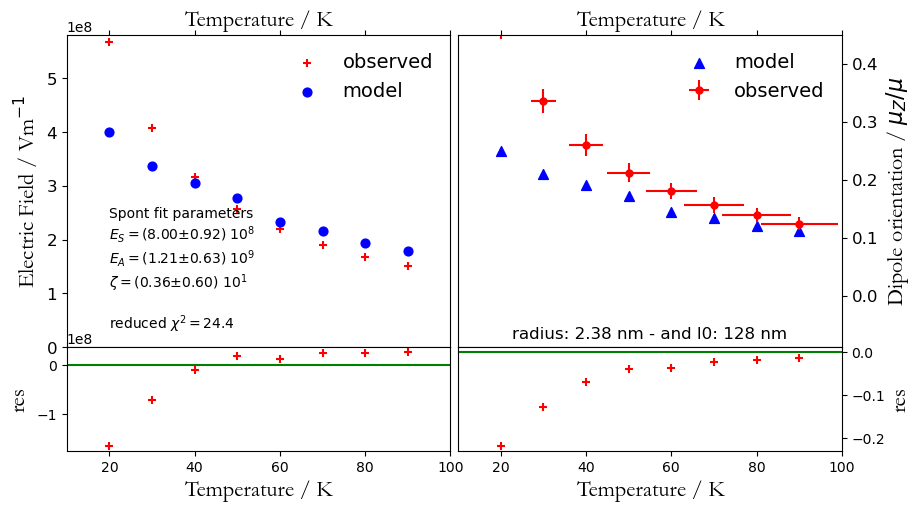

In [80]:
#run the main driver program for fitting the spontelectric model on multiple datasets
#load the datasets for each ice material
os.chdir(working_dir+'\\observed_data')
SpontelData = pandas.read_csv('data for_'+name+'.csv')
#SpontelData_dict[name] =  (SpontelData)

SpontelData.head()


    #
    # Main driver programme for fitting Spontelectric field data
    # 
    # Define several conversion factors to/from atomic units
    # conversion of Temp to a.u. : T [a.u.]= T [K]/factor
Ttoau=315770.0
    # conversion of D to a.u. : 1 D (=Debye) = factor [a.u.]
Debye=0.393456
    # Convert el. field in a.u. To V/m : E [a.u.] = E [V/m]/factor
Etoau=5.142e11
 
htfc=numpy.array([0.0]*4)
 
    # Find the value of mu for this ice 
IceMu=mu_0
    
    # Provide a first guess value for the parameter E_A
EAnxt=E_A_Vm
    
htfc[0]=1.0
htfc[1]=0.0
htfc[2]=0.0
htfc[3]=0.0
    
weight=numpy.array(SpontelData.weight)
ndata=len(weight)
    # y is the same as <mu_Z>/mu, Temp is the deposition temperature in [K]
    # sig are the 1-sigma measurement errors
    # E observed is the observed Electric field in units [V/m]
y=numpy.array(SpontelData.y)
sigy=numpy.array(SpontelData.sigma_y)
Temp=numpy.array(SpontelData.Temperature)
sigT=numpy.array(SpontelData.sigma_T)
Eobs=numpy.array(SpontelData.Observed_field)
    #
    # here comes a block of variable declarations
whtsum=0.0
yinvmn=0.0
hTfunc=numpy.array([0.0]*ndata)
DerhTfunc=numpy.array([0.0]*ndata)
DerGT=numpy.array([0.0]*ndata)
DerGy=numpy.array([0.0]*ndata)
PartDerv=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
xdat=numpy.array([[0.0]*ndata,[0.0]*ndata])
ydat=numpy.array([0.0]*ndata)
zdat=numpy.array([0.0]*ndata)
ymodel=numpy.array([0.0]*ndata)
DParDy=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
DParDT=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
SigPar=numpy.array([0.0]*3)
#
#
# Auxiliary functions f_0, f_1, f_2, and f_3 are needed as input for linear least-squares
# These are named here as PartDerv[0,], ..., PartDerv[3,] because these are also the
# partial derivatives of the function G with respect to T and y.
for i in range(0,ndata):
    yinvmn+=weight[i]/y[i]
    whtsum+=weight[i]
    hTfunc[i]=htfc[0]+Temp[i]*(htfc[1]+Temp[i]*(htfc[2]+Temp[i]*htfc[3]))
    DerhTfunc[i]=htfc[1]+Temp[i]*(2.0*htfc[2]+3.0*Temp[i]*htfc[3])
    PartDerv[0,i]=(1-y[i])*LangevInv(y[i])
    PartDerv[1,i]=Ttoau*Debye*IceMu*(y[i]-1.0)/Temp[i]
    PartDerv[2,i]=-1.0*PartDerv[1,i]*y[i]
    PartDerv[3,i]=PartDerv[1,i]*y[i]*y[i]*hTfunc[i]
#
# start the iteration to get the parameters, initialise a choice for E_A
yinvmn=yinvmn/whtsum
EAcur=1.1*EAnxt
itcnt=0
while ((abs(EAnxt/EAcur-1.0)>1.0e-3) and (itcnt<20)) :
    itcnt+=1
    EAcur=EAnxt
    for i in range(0,ndata):
        xdat[0,i]=PartDerv[1,i]
        xdat[1,i]=PartDerv[3,i]
        ydat[i]=-1.0*(PartDerv[0,i]+EAcur*PartDerv[2,i]/Etoau)
#
    Constrout=ConstrLSQ(xdat,ydat,weight)
#
# FPP (02/06/2022): here E_S and zeta always are forced to be >= 0
    EScur=abs(Constrout[0]*Etoau)
    ESzetacur=abs(Constrout[1]*Etoau)
    ratiolog=0.0
    for i in range(0,ndata) :
        Ezmod=(EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
        ratiolog+=weight[i]*(math.log(abs(EAcur*Langevin(Ezmod)))-math.log(Eobs[i]))
        DerGy[i]=(EScur-ESzetacur*hTfunc[i]*y[i]*(2.0-3.0*y[i])+EAcur*(1.0-2.0*y[i]))*IceMu*Ttoau*Debye/Etoau/Temp[i]
        DerGy[i]+=-1.0*LangevInv(y[i])+(1.0-y[i])*DerLangevInv(y[i])
        DerGT[i]=(EScur*(1-y[i])-EAcur*y[i]*(1-y[i])+ESzetacur*hTfunc[i]*y[i]*y[i]*(1-y[i]))*IceMu*Ttoau*Ttoau*Debye/Etoau/Temp[i]/Temp[i]
        DerGT[i]+=-1.*ESzetacur*DerhTfunc[i]*y[i]*y[i]*(1-y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
    ratiolog=ratiolog/whtsum
    if ((Constrout[0]<0) and (EAcur<0) and (yinvmn<0) and (ratiolog>0)) :
        EAnxt=EAcur+2.0*yinvmn*EScur
    else :
        EAnxt=EAcur/math.exp(ratiolog)
    if (itcnt>19) : 
        print ("iteration count exceeded: not converged")
#
# G(T,y)\equiv\left(1-y\right)L^{-1}(y)-\frac{\mu}{T}\left\{ E_S\left[1-y+\zeta (y^2 -y^3)\right] 
#          -E_A(y-y^2) \right\}
# dG/dy=-L^{-1}(y)+\left(1-y\right)\frac{\d L^{-1}(y)}{dy}-\frac{\mu}{T}\left\{ 
#           E_S\left[-1+\zeta h(T) (2y -3y^2)\right] -E_A(1-2y) \right\}
# dG/dT=\frac{\mu}{T^2}\left\{ E_S\left[1-y+\zeta_0 h(T) (y^2 -y^3)\right] -E_A(y-y^2) \right\}-\frac{\mu}{T}
#           E_S\zeta_0\frac{d h(T)}{dT} (y^2 -y^3)
#
# for the calculation of the uncertainty margins for the parameters the partial derivatives below are needed
#
# also calculate the quality of the fit (chi-square) dlsqsum
dlsqsum=0
for i in range(0,ndata) :
    ymodel[i]=Langevin((EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i])
    DelMod=y[i]-ymodel[i]
    dlsqsum+=weight[i]*DelMod*DelMod/sigy[i]/sigy[i]
        #print(i,weight[i]*DelMod*DelMod/sigy[i]/sigy[i])
    DParDy[0,i]=-1.0*DerGy[i]/PartDerv[1,i]
    DParDy[1,i]=-1.0*DerGy[i]/PartDerv[2,i]
    DParDy[2,i]=-1.0*DerGy[i]/PartDerv[3,i]
    DParDT[0,i]=-1.0*DerGT[i]/PartDerv[1,i]
    DParDT[1,i]=-1.0*DerGT[i]/PartDerv[2,i]
    DParDT[2,i]=-1.0*DerGT[i]/PartDerv[3,i]
#
dlsqsum=dlsqsum/(whtsum-2)
# calculate the 1-sigma uncertainties for the parameters
for k in range(0,3):
    for i in range(0,ndata) :
        SigPar[k]+=weight[i]*(DParDy[k,i]*DParDy[k,i]*sigy[i]*sigy[i]+DParDT[k,i]*DParDT[k,i]*sigT[i]*sigT[i]/Ttoau/Ttoau)
    SigPar[k]=Etoau*math.sqrt(SigPar[k]/whtsum)

#set up figures to show fit results
#ymin_mu=(SpontelData.ymin.iloc[0])
#ymax_mu=(SpontelData.ymax.iloc[0])
#xmin_mu=(SpontelData.xmin.iloc[0])
#xmax_mu=(SpontelData.xmax.iloc[0])
#ymin=(SpontelData.ymin.iloc[1])
#ymax=(SpontelData.ymax.iloc[1])
#xmin=(SpontelData.xmin.iloc[1])
#xmax=(SpontelData.xmax.iloc[1])
#ticks=[SpontelData.ticks.iloc[0:3]]
  
zetacur=ESzetacur/EScur
ymodel_E=EAcur*ymodel

#Define text to print on each graph
SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
string = 'Spont fit parameters'
string+="\n"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
string+="\n"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
string+="\n"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
string+="\n\n"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"\n"

annotate=(string)

#define residuals for plot (just for visualising)
res_E=Eobs-ymodel_E
res_mu=y-ymodel
      
#FigureMu(Temp,ymodel,y,sigT,sigy,xmin_mu,xmax_mu,ymin_mu,ymax_mu,name)
#ymodel=EAcur*ymodel
#FigureE(Temp,ymodel,Eobs,xmin,xmax,ymin,ymax,name)

fig, ax = plt.subplots(2, 2, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=(10, 5.4))
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.02)
        
plt.title(ij_space)
ax[0,0].set_xlim(xmin, xmax)
ax[0,0].set_ylim(ymin, ymax)
ax[0,0].scatter(Temp, ymodel_E, marker='+', s=40, color='red', label='observed')
ax[0,0].scatter(Temp, Eobs, marker='o', s=40, color='blue', label='model')
    #ax.set_yticks(tick)
ax[0,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[0,0].xaxis.set_label_position("top")
ax[0,0].xaxis.tick_top()
ax[0,0].set_ylabel('Electric Field / Vm$^{-1}$', fontsize=16, fontname='garamond')
ax[0,0].tick_params(labelsize='large')
ax[0,0].legend(loc=0, fontsize=14, framealpha=0)
ax[0,0].text(20,0,annotate)
    
ax[0,1].set_xlim(xmin_mu, xmax_mu)
ax[0,1].set_ylim(ymin_mu, ymax_mu)
ax[0,1].errorbar(Temp, ymodel, markersize=10, xerr=sigT, yerr=sigy, fmt='.', color='red', label='observed')
ax[0,1].scatter(Temp, y, marker='^', s=50, color='blue', label='model')
ax[0,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[0,1].xaxis.set_label_position("top")
ax[0,1].xaxis.tick_top()
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_ylabel('Dipole orientation / $\mu_Z/\mu$', fontsize=16, fontname='garamond')
ax[0,1].tick_params(labelsize='large')
ax[0,1].legend(loc=0, fontsize=14, framealpha=0)
#ax[0,1].text(20,0,legend_mu)
    
ax[1,0].scatter(Temp, res_E, marker='+', s=40, color='red', label='observed')
ax[1,0].axhline(y = 0.0, color = 'g', linestyle = '-')
ax[1,0].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[1,0].set_ylabel('res', fontsize=16, fontname='garamond')
    
ax[1,1].scatter(Temp, res_mu, marker='+', s=40, color='red', label='observed')
ax[1,1].yaxis.set_label_position("right")
ax[1,1].axhline(y = 0.0, color = 'g', linestyle = '-')
ax[1,1].yaxis.tick_right()
ax[1,1].set_xlabel('Temperature / K', fontsize=16, fontname='garamond')
ax[1,1].set_ylabel('res', fontsize=16, fontname='garamond')

short_ij=('r_'+str(r)+'_lambda0_'+str(l0))
plt.savefig('Spont fit for'+short_ij+'.png')    
    
zetacur=ESzetacur/EScur
        
SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
string = name
string+="<br>"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
string+="<br>"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
string+="<br>"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
string+="<br><br>"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"<br>"
display(Markdown(string)) #Use this line to see the individual results for fitting parameters per dataset
    
ES=NeaterOut(EScur,SigPar[0])
EA=NeaterOut(EAcur,SigPar[1])
zeta=NeaterOut(zetacur,SigPar[2])
    
os.chdir(working_dir)  

    


0.5
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.36$\pm$0.35) $10^8$<br>$E_A =$(3.16$\pm$0.51) $10^9$<br>$\zeta =$(0.18$\pm$0.27) $10^2$<br><br>reduced $\chi^2 =$180.7<br>

0.5
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(5.21$\pm$0.40) $10^8$<br>$E_A =$(3.33$\pm$0.44) $10^9$<br>$\zeta =$(0.14$\pm$0.12) $10^2$<br><br>reduced $\chi^2 =$70.2<br>

0.5
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(6.05$\pm$0.46) $10^8$<br>$E_A =$(3.43$\pm$0.40) $10^9$<br>$\zeta =$(1.12$\pm$0.73) $10^1$<br><br>reduced $\chi^2 =$34.3<br>

0.5
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(6.89$\pm$0.52) $10^8$<br>$E_A =$(3.49$\pm$0.38) $10^9$<br>$\zeta =$(0.91$\pm$0.49) $10^1$<br><br>reduced $\chi^2 =$18.9<br>

0.5
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(7.73$\pm$0.58) $10^8$<br>$E_A =$(3.54$\pm$0.37) $10^9$<br>$\zeta =$(0.74$\pm$0.36) $10^1$<br><br>reduced $\chi^2 =$11.2<br>

0.5
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(8.59$\pm$0.65) $10^8$<br>$E_A =$(3.58$\pm$0.37) $10^9$<br>$\zeta =$(0.61$\pm$0.27) $10^1$<br><br>reduced $\chi^2 =$6.9<br>

0.5
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(9.46$\pm$0.73) $10^8$<br>$E_A =$(3.61$\pm$0.36) $10^9$<br>$\zeta =$(0.51$\pm$0.22) $10^1$<br><br>reduced $\chi^2 =$4.5<br>

0.5
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(10.35$\pm$0.81) $10^8$<br>$E_A =$(3.63$\pm$0.36) $10^9$<br>$\zeta =$(0.43$\pm$0.18) $10^1$<br><br>reduced $\chi^2 =$2.9<br>

0.5
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(11.26$\pm$0.90) $10^8$<br>$E_A =$(3.65$\pm$0.37) $10^9$<br>$\zeta =$(0.37$\pm$0.15) $10^1$<br><br>reduced $\chi^2 =$2.0<br>

0.5
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


C:\Users\au302163\AppData\Local\Temp\ipykernel_29924\395268837.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 5.4))


MeOH<br>$E_S =$(12.19$\pm$0.99) $10^8$<br>$E_A =$(3.66$\pm$0.37) $10^9$<br>$\zeta =$(0.31$\pm$0.13) $10^1$<br><br>reduced $\chi^2 =$1.3<br>

0.8
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.75$\pm$0.22) $10^8$<br>$E_A =$(3.08$\pm$0.52) $10^9$<br>$\zeta =$(0.43$\pm$0.70) $10^2$<br><br>reduced $\chi^2 =$194.7<br>

0.8
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.28$\pm$0.25) $10^8$<br>$E_A =$(3.25$\pm$0.44) $10^9$<br>$\zeta =$(0.34$\pm$0.32) $10^2$<br><br>reduced $\chi^2 =$76.8<br>

0.8
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.81$\pm$0.29) $10^8$<br>$E_A =$(3.37$\pm$0.40) $10^9$<br>$\zeta =$(0.27$\pm$0.19) $10^2$<br><br>reduced $\chi^2 =$38.1<br>

0.8
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.34$\pm$0.32) $10^8$<br>$E_A =$(3.45$\pm$0.38) $10^9$<br>$\zeta =$(0.22$\pm$0.12) $10^2$<br><br>reduced $\chi^2 =$21.3<br>

0.8
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.87$\pm$0.36) $10^8$<br>$E_A =$(3.50$\pm$0.37) $10^9$<br>$\zeta =$(1.80$\pm$0.90) $10^1$<br><br>reduced $\chi^2 =$12.8<br>

0.8
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(5.40$\pm$0.41) $10^8$<br>$E_A =$(3.54$\pm$0.36) $10^9$<br>$\zeta =$(1.49$\pm$0.69) $10^1$<br><br>reduced $\chi^2 =$8.0<br>

0.8
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(5.94$\pm$0.45) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(1.25$\pm$0.55) $10^1$<br><br>reduced $\chi^2 =$5.3<br>

0.8
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(6.49$\pm$0.50) $10^8$<br>$E_A =$(3.60$\pm$0.36) $10^9$<br>$\zeta =$(1.05$\pm$0.45) $10^1$<br><br>reduced $\chi^2 =$3.5<br>

0.8
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(7.05$\pm$0.55) $10^8$<br>$E_A =$(3.63$\pm$0.36) $10^9$<br>$\zeta =$(0.89$\pm$0.37) $10^1$<br><br>reduced $\chi^2 =$2.4<br>

0.8
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(7.63$\pm$0.60) $10^8$<br>$E_A =$(3.64$\pm$0.36) $10^9$<br>$\zeta =$(0.76$\pm$0.32) $10^1$<br><br>reduced $\chi^2 =$1.7<br>

1.1
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.01$\pm$0.16) $10^8$<br>$E_A =$(3.04$\pm$0.52) $10^9$<br>$\zeta =$(0.08$\pm$0.13) $10^3$<br><br>reduced $\chi^2 =$200.2<br>

1.1
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.40$\pm$0.18) $10^8$<br>$E_A =$(3.22$\pm$0.44) $10^9$<br>$\zeta =$(0.62$\pm$0.60) $10^2$<br><br>reduced $\chi^2 =$79.4<br>

1.1
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.78$\pm$0.21) $10^8$<br>$E_A =$(3.34$\pm$0.40) $10^9$<br>$\zeta =$(0.50$\pm$0.35) $10^2$<br><br>reduced $\chi^2 =$39.5<br>

1.1
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.16$\pm$0.24) $10^8$<br>$E_A =$(3.43$\pm$0.38) $10^9$<br>$\zeta =$(0.41$\pm$0.24) $10^2$<br><br>reduced $\chi^2 =$22.1<br>

1.1
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.55$\pm$0.26) $10^8$<br>$E_A =$(3.49$\pm$0.37) $10^9$<br>$\zeta =$(0.33$\pm$0.17) $10^2$<br><br>reduced $\chi^2 =$13.3<br>

1.1
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.93$\pm$0.29) $10^8$<br>$E_A =$(3.53$\pm$0.36) $10^9$<br>$\zeta =$(0.28$\pm$0.13) $10^2$<br><br>reduced $\chi^2 =$8.4<br>

1.1
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.33$\pm$0.33) $10^8$<br>$E_A =$(3.57$\pm$0.36) $10^9$<br>$\zeta =$(0.23$\pm$0.10) $10^2$<br><br>reduced $\chi^2 =$5.5<br>

1.1
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.72$\pm$0.36) $10^8$<br>$E_A =$(3.59$\pm$0.36) $10^9$<br>$\zeta =$(1.95$\pm$0.84) $10^1$<br><br>reduced $\chi^2 =$3.7<br>

1.1
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(5.13$\pm$0.40) $10^8$<br>$E_A =$(3.62$\pm$0.36) $10^9$<br>$\zeta =$(1.65$\pm$0.70) $10^1$<br><br>reduced $\chi^2 =$2.5<br>

1.1
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(5.54$\pm$0.43) $10^8$<br>$E_A =$(3.64$\pm$0.36) $10^9$<br>$\zeta =$(1.41$\pm$0.59) $10^1$<br><br>reduced $\chi^2 =$1.8<br>

1.4
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.58$\pm$0.12) $10^8$<br>$E_A =$(3.02$\pm$0.52) $10^9$<br>$\zeta =$(0.13$\pm$0.21) $10^3$<br><br>reduced $\chi^2 =$202.7<br>

1.4
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.89$\pm$0.14) $10^8$<br>$E_A =$(3.21$\pm$0.44) $10^9$<br>$\zeta =$(1.00$\pm$0.96) $10^2$<br><br>reduced $\chi^2 =$80.7<br>

1.4
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.19$\pm$0.16) $10^8$<br>$E_A =$(3.33$\pm$0.40) $10^9$<br>$\zeta =$(0.80$\pm$0.57) $10^2$<br><br>reduced $\chi^2 =$40.2<br>

1.4
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.49$\pm$0.19) $10^8$<br>$E_A =$(3.41$\pm$0.38) $10^9$<br>$\zeta =$(0.65$\pm$0.38) $10^2$<br><br>reduced $\chi^2 =$22.5<br>

1.4
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.79$\pm$0.21) $10^8$<br>$E_A =$(3.48$\pm$0.37) $10^9$<br>$\zeta =$(0.53$\pm$0.28) $10^2$<br><br>reduced $\chi^2 =$13.6<br>

1.4
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.09$\pm$0.23) $10^8$<br>$E_A =$(3.52$\pm$0.36) $10^9$<br>$\zeta =$(0.44$\pm$0.21) $10^2$<br><br>reduced $\chi^2 =$8.6<br>

1.4
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.40$\pm$0.26) $10^8$<br>$E_A =$(3.56$\pm$0.36) $10^9$<br>$\zeta =$(0.37$\pm$0.17) $10^2$<br><br>reduced $\chi^2 =$5.6<br>

1.4
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.71$\pm$0.28) $10^8$<br>$E_A =$(3.59$\pm$0.36) $10^9$<br>$\zeta =$(0.31$\pm$0.14) $10^2$<br><br>reduced $\chi^2 =$3.8<br>

1.4
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.03$\pm$0.31) $10^8$<br>$E_A =$(3.61$\pm$0.36) $10^9$<br>$\zeta =$(0.27$\pm$0.11) $10^2$<br><br>reduced $\chi^2 =$2.6<br>

1.4
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(4.36$\pm$0.34) $10^8$<br>$E_A =$(3.63$\pm$0.36) $10^9$<br>$\zeta =$(2.27$\pm$0.96) $10^1$<br><br>reduced $\chi^2 =$1.8<br>

1.7
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.30$\pm$0.10) $10^8$<br>$E_A =$(3.01$\pm$0.52) $10^9$<br>$\zeta =$(0.18$\pm$0.31) $10^3$<br><br>reduced $\chi^2 =$204.4<br>

1.7
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.55$\pm$0.12) $10^8$<br>$E_A =$(3.20$\pm$0.44) $10^9$<br>$\zeta =$(0.15$\pm$0.14) $10^3$<br><br>reduced $\chi^2 =$81.5<br>

1.7
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.80$\pm$0.14) $10^8$<br>$E_A =$(3.32$\pm$0.40) $10^9$<br>$\zeta =$(1.17$\pm$0.84) $10^2$<br><br>reduced $\chi^2 =$40.6<br>

1.7
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.05$\pm$0.15) $10^8$<br>$E_A =$(3.41$\pm$0.38) $10^9$<br>$\zeta =$(0.95$\pm$0.56) $10^2$<br><br>reduced $\chi^2 =$22.8<br>

1.7
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.30$\pm$0.17) $10^8$<br>$E_A =$(3.47$\pm$0.37) $10^9$<br>$\zeta =$(0.78$\pm$0.41) $10^2$<br><br>reduced $\chi^2 =$13.8<br>

1.7
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.55$\pm$0.19) $10^8$<br>$E_A =$(3.52$\pm$0.36) $10^9$<br>$\zeta =$(0.65$\pm$0.31) $10^2$<br><br>reduced $\chi^2 =$8.7<br>

1.7
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.80$\pm$0.21) $10^8$<br>$E_A =$(3.56$\pm$0.36) $10^9$<br>$\zeta =$(0.55$\pm$0.24) $10^2$<br><br>reduced $\chi^2 =$5.7<br>

1.7
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.06$\pm$0.23) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(0.46$\pm$0.20) $10^2$<br><br>reduced $\chi^2 =$3.8<br>

1.7
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.32$\pm$0.26) $10^8$<br>$E_A =$(3.61$\pm$0.36) $10^9$<br>$\zeta =$(0.39$\pm$0.17) $10^2$<br><br>reduced $\chi^2 =$2.6<br>

1.7
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.59$\pm$0.28) $10^8$<br>$E_A =$(3.63$\pm$0.36) $10^9$<br>$\zeta =$(0.33$\pm$0.14) $10^2$<br><br>reduced $\chi^2 =$1.8<br>

2
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(11.07$\pm$0.87) $10^7$<br>$E_A =$(3.00$\pm$0.52) $10^9$<br>$\zeta =$(0.25$\pm$0.44) $10^3$<br><br>reduced $\chi^2 =$205.5<br>

2
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.32$\pm$0.10) $10^8$<br>$E_A =$(3.19$\pm$0.44) $10^9$<br>$\zeta =$(0.20$\pm$0.20) $10^3$<br><br>reduced $\chi^2 =$82.0<br>

2
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.53$\pm$0.11) $10^8$<br>$E_A =$(3.31$\pm$0.40) $10^9$<br>$\zeta =$(0.16$\pm$0.12) $10^3$<br><br>reduced $\chi^2 =$40.9<br>

2
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.74$\pm$0.13) $10^8$<br>$E_A =$(3.40$\pm$0.38) $10^9$<br>$\zeta =$(1.31$\pm$0.77) $10^2$<br><br>reduced $\chi^2 =$23.0<br>

2
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.95$\pm$0.15) $10^8$<br>$E_A =$(3.47$\pm$0.37) $10^9$<br>$\zeta =$(1.08$\pm$0.56) $10^2$<br><br>reduced $\chi^2 =$13.9<br>

2
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.17$\pm$0.16) $10^8$<br>$E_A =$(3.52$\pm$0.36) $10^9$<br>$\zeta =$(0.90$\pm$0.43) $10^2$<br><br>reduced $\chi^2 =$8.8<br>

2
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.38$\pm$0.18) $10^8$<br>$E_A =$(3.55$\pm$0.36) $10^9$<br>$\zeta =$(0.75$\pm$0.34) $10^2$<br><br>reduced $\chi^2 =$5.8<br>

2
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.60$\pm$0.20) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(0.64$\pm$0.28) $10^2$<br><br>reduced $\chi^2 =$3.9<br>

2
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.82$\pm$0.22) $10^8$<br>$E_A =$(3.61$\pm$0.36) $10^9$<br>$\zeta =$(0.54$\pm$0.23) $10^2$<br><br>reduced $\chi^2 =$2.6<br>

2
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(3.05$\pm$0.24) $10^8$<br>$E_A =$(3.63$\pm$0.36) $10^9$<br>$\zeta =$(0.46$\pm$0.20) $10^2$<br><br>reduced $\chi^2 =$1.8<br>

2.3
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(9.63$\pm$0.76) $10^7$<br>$E_A =$(2.99$\pm$0.52) $10^9$<br>$\zeta =$(0.33$\pm$0.58) $10^3$<br><br>reduced $\chi^2 =$206.3<br>

2.3
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(11.50$\pm$0.88) $10^7$<br>$E_A =$(3.18$\pm$0.44) $10^9$<br>$\zeta =$(0.26$\pm$0.26) $10^3$<br><br>reduced $\chi^2 =$82.3<br>

2.3
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(13.33$\pm$1.00) $10^7$<br>$E_A =$(3.31$\pm$0.40) $10^9$<br>$\zeta =$(0.21$\pm$0.15) $10^3$<br><br>reduced $\chi^2 =$41.1<br>

2.3
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.52$\pm$0.11) $10^8$<br>$E_A =$(3.40$\pm$0.38) $10^9$<br>$\zeta =$(0.17$\pm$0.10) $10^3$<br><br>reduced $\chi^2 =$23.1<br>

2.3
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.70$\pm$0.13) $10^8$<br>$E_A =$(3.46$\pm$0.37) $10^9$<br>$\zeta =$(1.43$\pm$0.74) $10^2$<br><br>reduced $\chi^2 =$13.9<br>

2.3
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.88$\pm$0.14) $10^8$<br>$E_A =$(3.51$\pm$0.36) $10^9$<br>$\zeta =$(1.19$\pm$0.57) $10^2$<br><br>reduced $\chi^2 =$8.8<br>

2.3
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.07$\pm$0.16) $10^8$<br>$E_A =$(3.55$\pm$0.36) $10^9$<br>$\zeta =$(0.99$\pm$0.45) $10^2$<br><br>reduced $\chi^2 =$5.8<br>

2.3
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.26$\pm$0.17) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(0.84$\pm$0.37) $10^2$<br><br>reduced $\chi^2 =$3.9<br>

2.3
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.45$\pm$0.19) $10^8$<br>$E_A =$(3.61$\pm$0.36) $10^9$<br>$\zeta =$(0.71$\pm$0.30) $10^2$<br><br>reduced $\chi^2 =$2.7<br>

2.3
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.65$\pm$0.21) $10^8$<br>$E_A =$(3.63$\pm$0.36) $10^9$<br>$\zeta =$(0.61$\pm$0.26) $10^2$<br><br>reduced $\chi^2 =$1.8<br>

2.6
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(8.52$\pm$0.67) $10^7$<br>$E_A =$(2.99$\pm$0.52) $10^9$<br>$\zeta =$(0.43$\pm$0.74) $10^3$<br><br>reduced $\chi^2 =$206.8<br>

2.6
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(10.17$\pm$0.78) $10^7$<br>$E_A =$(3.18$\pm$0.44) $10^9$<br>$\zeta =$(0.34$\pm$0.33) $10^3$<br><br>reduced $\chi^2 =$82.6<br>

2.6
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(11.79$\pm$0.88) $10^7$<br>$E_A =$(3.31$\pm$0.40) $10^9$<br>$\zeta =$(0.27$\pm$0.20) $10^3$<br><br>reduced $\chi^2 =$41.2<br>

2.6
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(13.41$\pm$1.00) $10^7$<br>$E_A =$(3.39$\pm$0.38) $10^9$<br>$\zeta =$(0.22$\pm$0.13) $10^3$<br><br>reduced $\chi^2 =$23.2<br>

2.6
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.50$\pm$0.11) $10^8$<br>$E_A =$(3.46$\pm$0.37) $10^9$<br>$\zeta =$(1.82$\pm$0.95) $10^2$<br><br>reduced $\chi^2 =$14.0<br>

2.6
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.67$\pm$0.12) $10^8$<br>$E_A =$(3.51$\pm$0.36) $10^9$<br>$\zeta =$(1.51$\pm$0.72) $10^2$<br><br>reduced $\chi^2 =$8.9<br>

2.6
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.83$\pm$0.14) $10^8$<br>$E_A =$(3.55$\pm$0.36) $10^9$<br>$\zeta =$(1.27$\pm$0.57) $10^2$<br><br>reduced $\chi^2 =$5.8<br>

2.6
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.00$\pm$0.15) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(1.07$\pm$0.47) $10^2$<br><br>reduced $\chi^2 =$3.9<br>

2.6
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.17$\pm$0.17) $10^8$<br>$E_A =$(3.60$\pm$0.36) $10^9$<br>$\zeta =$(0.91$\pm$0.39) $10^2$<br><br>reduced $\chi^2 =$2.7<br>

2.6
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.34$\pm$0.18) $10^8$<br>$E_A =$(3.62$\pm$0.36) $10^9$<br>$\zeta =$(0.78$\pm$0.33) $10^2$<br><br>reduced $\chi^2 =$1.9<br>

2.9
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(7.64$\pm$0.60) $10^7$<br>$E_A =$(2.99$\pm$0.52) $10^9$<br>$\zeta =$(0.53$\pm$0.92) $10^3$<br><br>reduced $\chi^2 =$207.2<br>

2.9
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(9.12$\pm$0.69) $10^7$<br>$E_A =$(3.18$\pm$0.44) $10^9$<br>$\zeta =$(0.42$\pm$0.41) $10^3$<br><br>reduced $\chi^2 =$82.7<br>

2.9
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(10.57$\pm$0.79) $10^7$<br>$E_A =$(3.30$\pm$0.40) $10^9$<br>$\zeta =$(0.34$\pm$0.24) $10^3$<br><br>reduced $\chi^2 =$41.3<br>

2.9
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(12.02$\pm$0.89) $10^7$<br>$E_A =$(3.39$\pm$0.38) $10^9$<br>$\zeta =$(0.27$\pm$0.16) $10^3$<br><br>reduced $\chi^2 =$23.2<br>

2.9
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.35$\pm$0.10) $10^8$<br>$E_A =$(3.46$\pm$0.37) $10^9$<br>$\zeta =$(0.23$\pm$0.12) $10^3$<br><br>reduced $\chi^2 =$14.0<br>

2.9
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.49$\pm$0.11) $10^8$<br>$E_A =$(3.51$\pm$0.36) $10^9$<br>$\zeta =$(1.88$\pm$0.90) $10^2$<br><br>reduced $\chi^2 =$8.9<br>

2.9
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.64$\pm$0.12) $10^8$<br>$E_A =$(3.55$\pm$0.36) $10^9$<br>$\zeta =$(1.58$\pm$0.71) $10^2$<br><br>reduced $\chi^2 =$5.8<br>

2.9
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.79$\pm$0.14) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(1.33$\pm$0.58) $10^2$<br><br>reduced $\chi^2 =$3.9<br>

2.9
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.95$\pm$0.15) $10^8$<br>$E_A =$(3.60$\pm$0.36) $10^9$<br>$\zeta =$(1.13$\pm$0.48) $10^2$<br><br>reduced $\chi^2 =$2.7<br>

2.9
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(2.10$\pm$0.16) $10^8$<br>$E_A =$(3.62$\pm$0.36) $10^9$<br>$\zeta =$(0.96$\pm$0.41) $10^2$<br><br>reduced $\chi^2 =$1.9<br>

3.2
127
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(6.92$\pm$0.55) $10^7$<br>$E_A =$(2.98$\pm$0.52) $10^9$<br>$\zeta =$(0.06$\pm$0.11) $10^4$<br><br>reduced $\chi^2 =$207.5<br>

3.2
127.1
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(8.27$\pm$0.63) $10^7$<br>$E_A =$(3.18$\pm$0.44) $10^9$<br>$\zeta =$(0.51$\pm$0.50) $10^3$<br><br>reduced $\chi^2 =$82.9<br>

3.2
127.2
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(9.58$\pm$0.72) $10^7$<br>$E_A =$(3.30$\pm$0.40) $10^9$<br>$\zeta =$(0.41$\pm$0.30) $10^3$<br><br>reduced $\chi^2 =$41.4<br>

3.2
127.3
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(10.89$\pm$0.81) $10^7$<br>$E_A =$(3.39$\pm$0.38) $10^9$<br>$\zeta =$(0.33$\pm$0.20) $10^3$<br><br>reduced $\chi^2 =$23.2<br>

3.2
127.4
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(12.21$\pm$0.91) $10^7$<br>$E_A =$(3.46$\pm$0.37) $10^9$<br>$\zeta =$(0.28$\pm$0.14) $10^3$<br><br>reduced $\chi^2 =$14.0<br>

3.2
127.5
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.35$\pm$0.10) $10^8$<br>$E_A =$(3.51$\pm$0.36) $10^9$<br>$\zeta =$(0.23$\pm$0.11) $10^3$<br><br>reduced $\chi^2 =$8.9<br>

3.2
127.6
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.49$\pm$0.11) $10^8$<br>$E_A =$(3.55$\pm$0.36) $10^9$<br>$\zeta =$(1.92$\pm$0.87) $10^2$<br><br>reduced $\chi^2 =$5.8<br>

3.2
127.7
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.62$\pm$0.12) $10^8$<br>$E_A =$(3.58$\pm$0.36) $10^9$<br>$\zeta =$(1.62$\pm$0.71) $10^2$<br><br>reduced $\chi^2 =$3.9<br>

3.2
127.8
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.76$\pm$0.14) $10^8$<br>$E_A =$(3.60$\pm$0.36) $10^9$<br>$\zeta =$(1.38$\pm$0.59) $10^2$<br><br>reduced $\chi^2 =$2.7<br>

3.2
127.9
dipole moment in the gas phase for MeOH is 1.6489 Debye
dipole moment in the solid sate for MeOH is 1.173112656516965 Debye
Calculated value of E_A for MeOH is  3.710014564249422 x 10^9 V/m


MeOH<br>$E_S =$(1.90$\pm$0.15) $10^8$<br>$E_A =$(3.62$\pm$0.36) $10^9$<br>$\zeta =$(1.17$\pm$0.50) $10^2$<br><br>reduced $\chi^2 =$1.9<br>

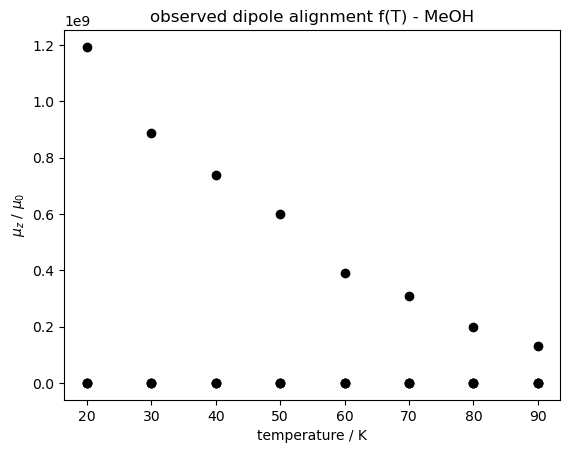

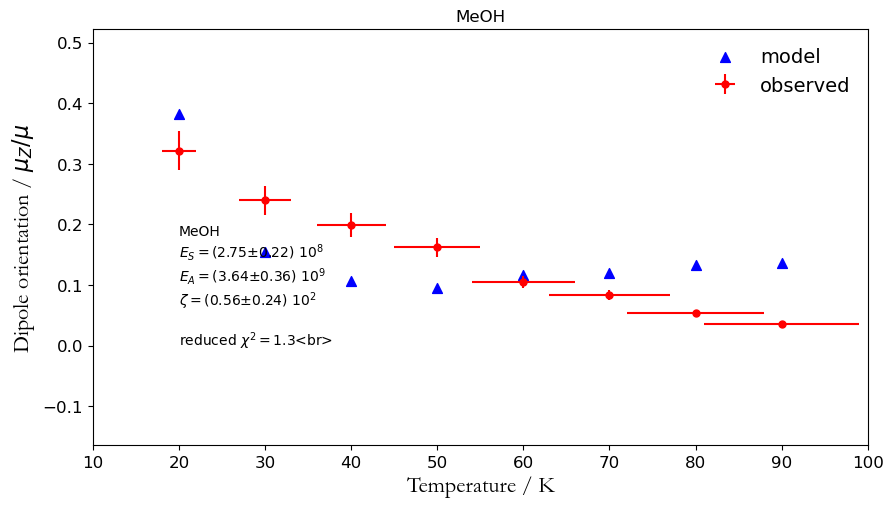

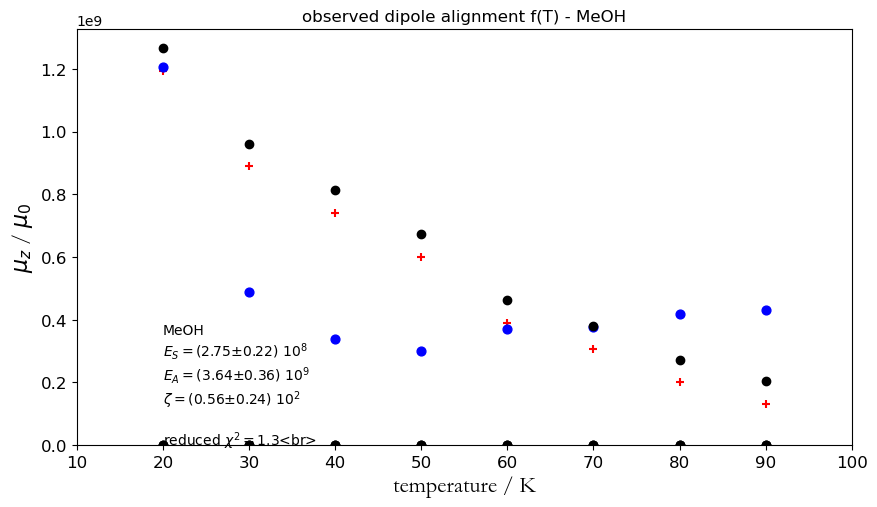

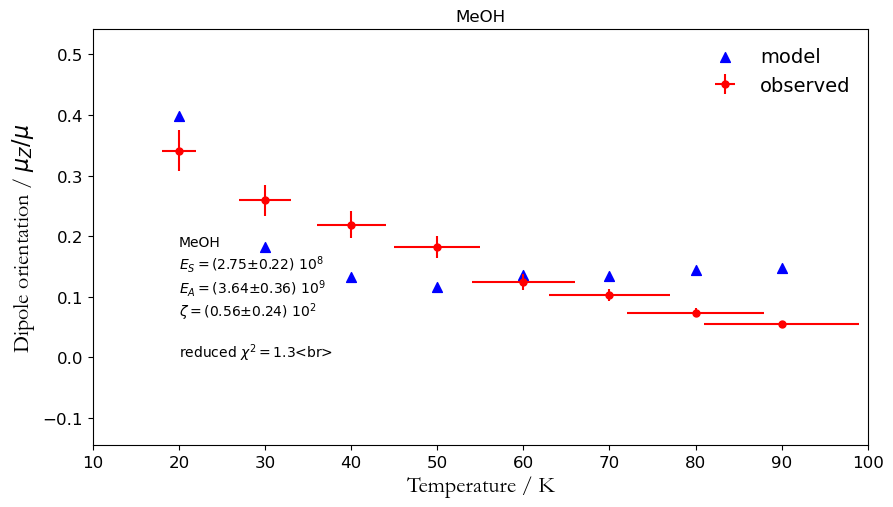

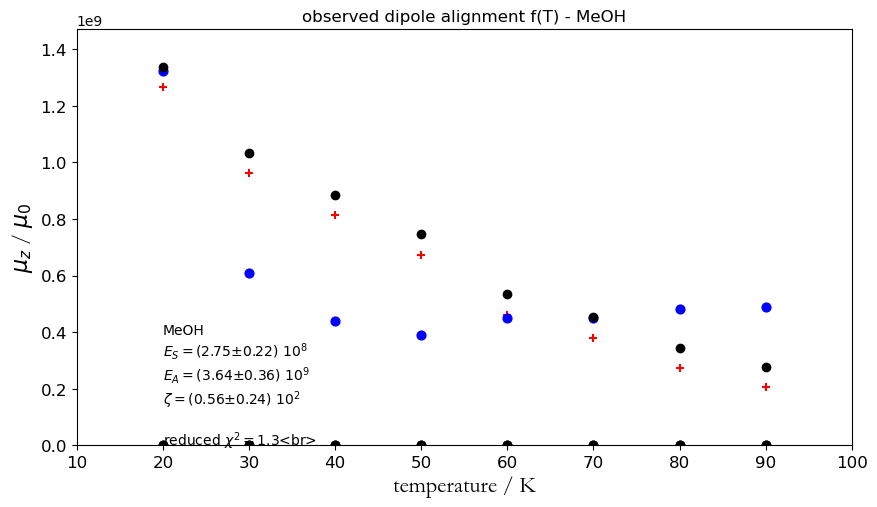

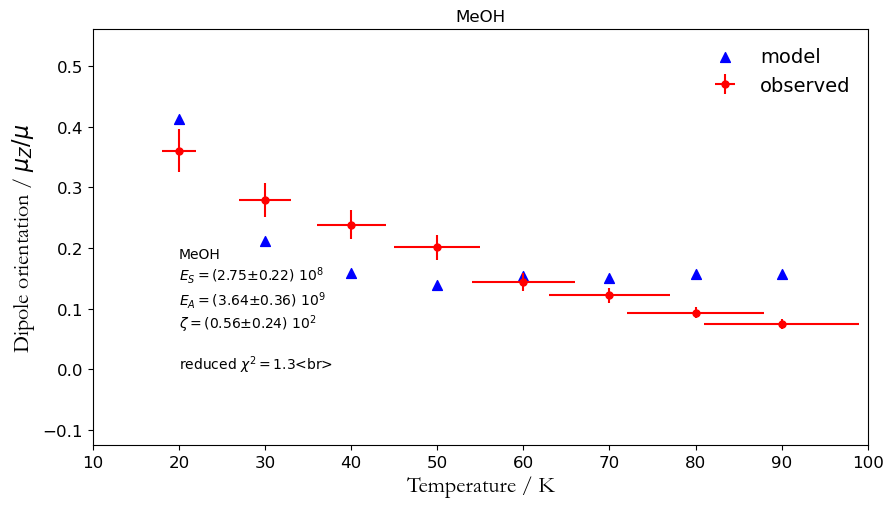

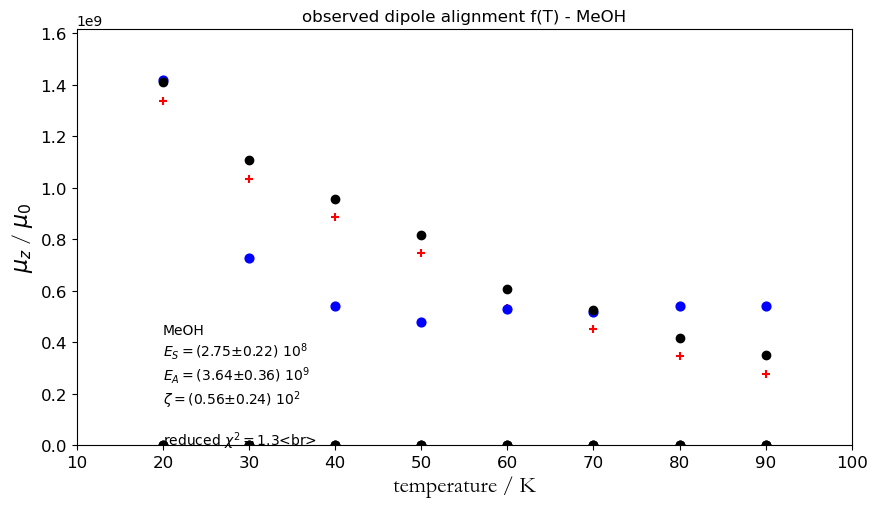

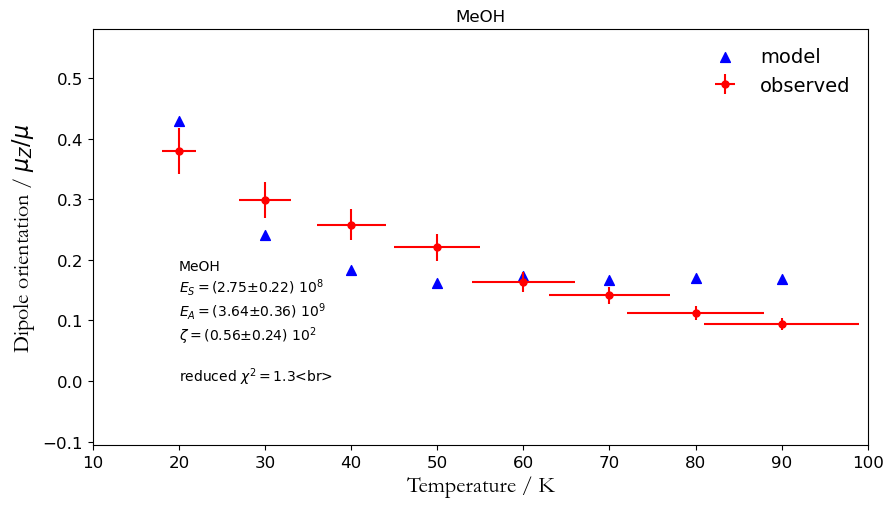

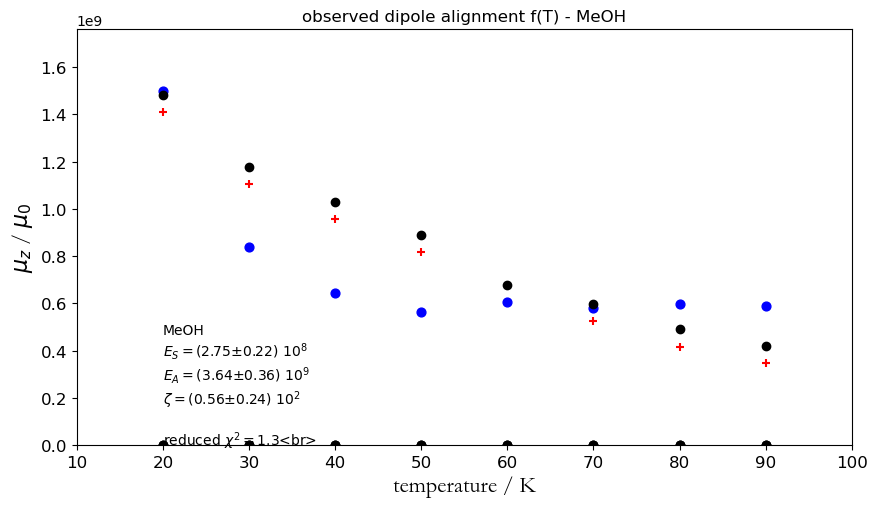

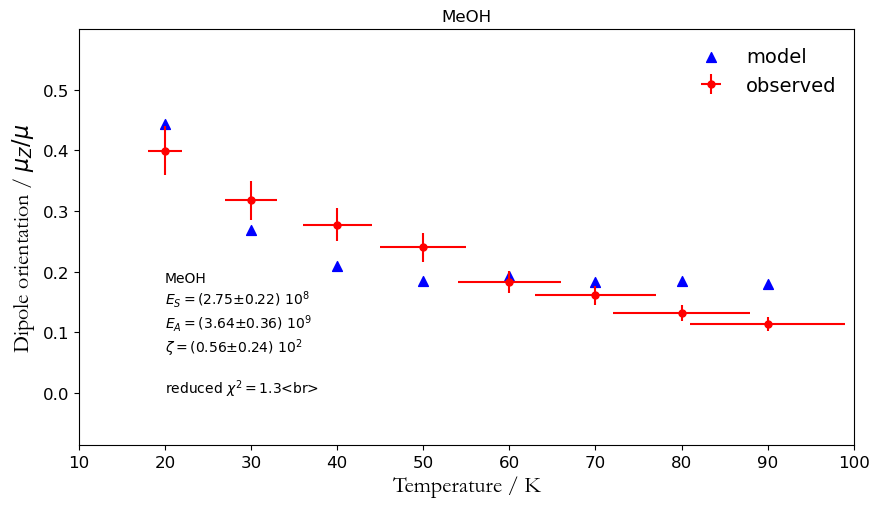

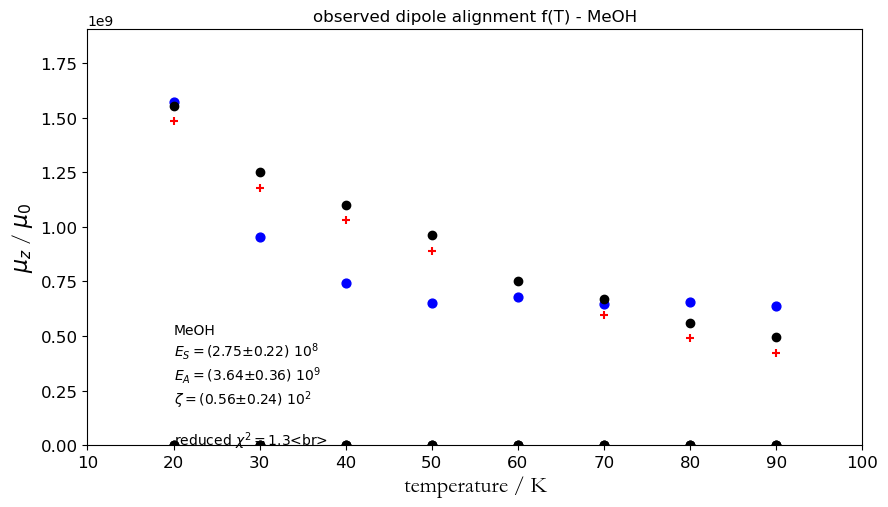

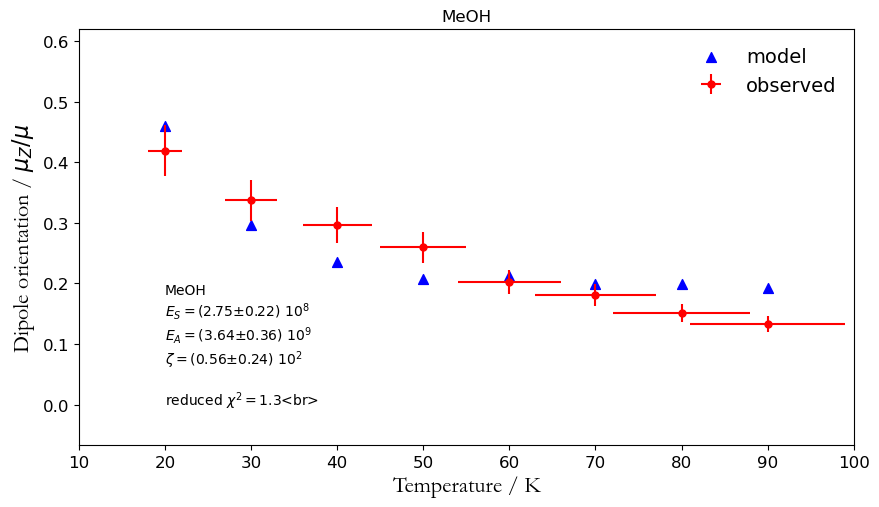

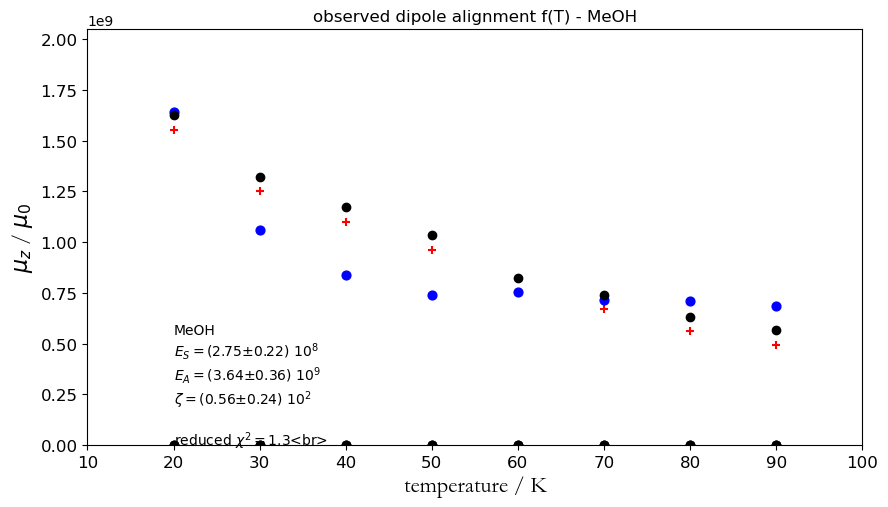

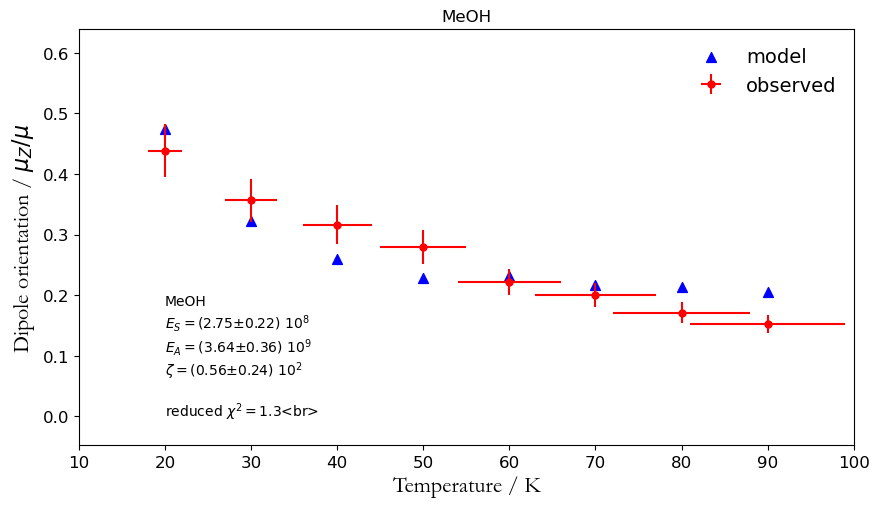

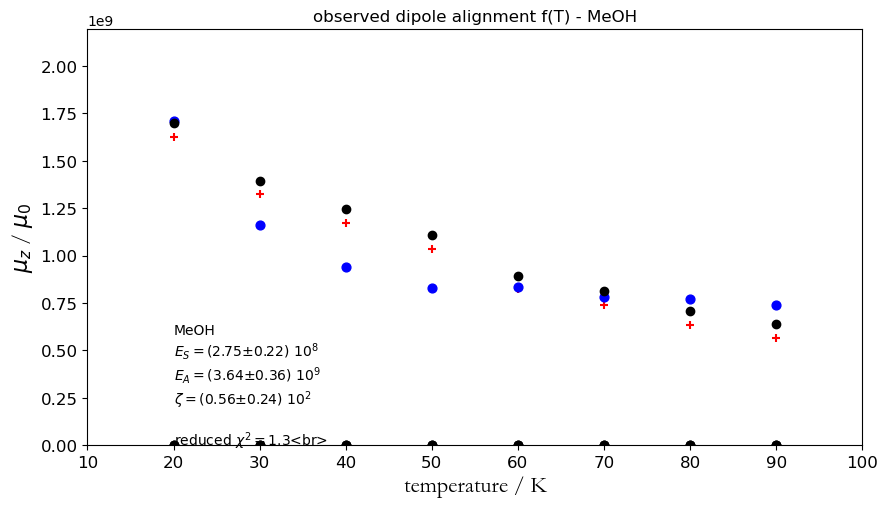

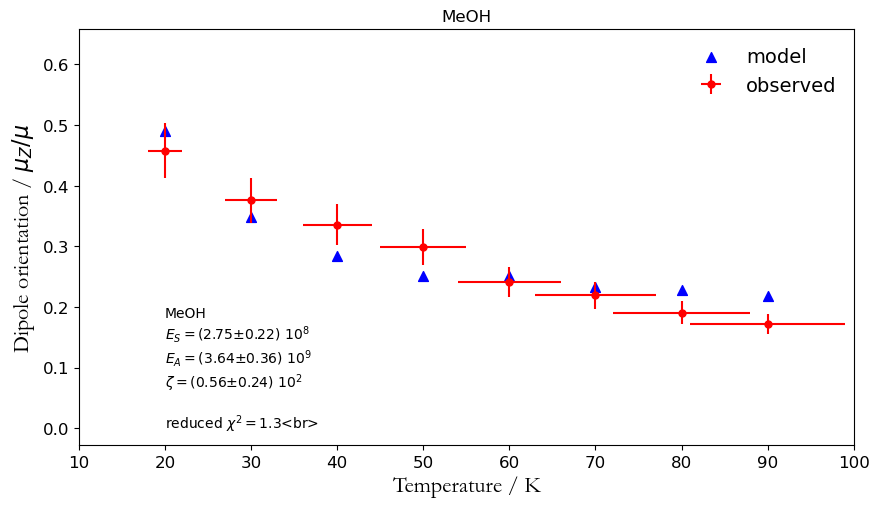

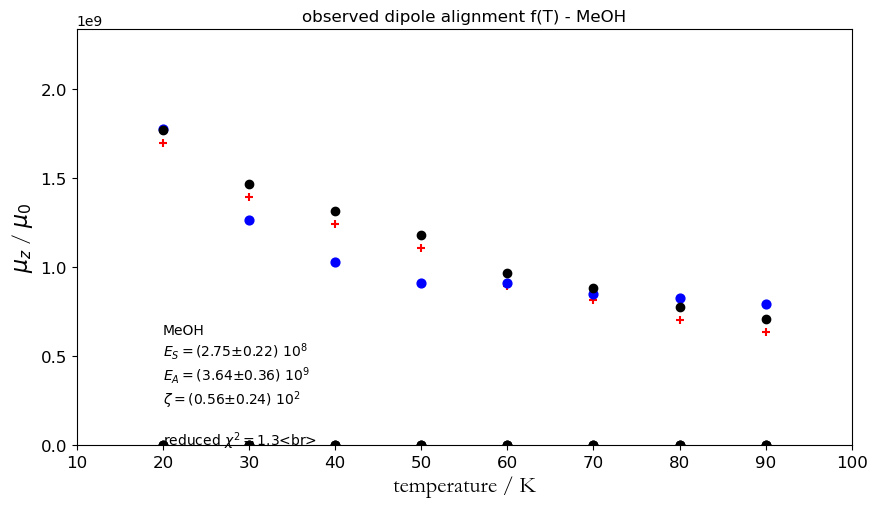

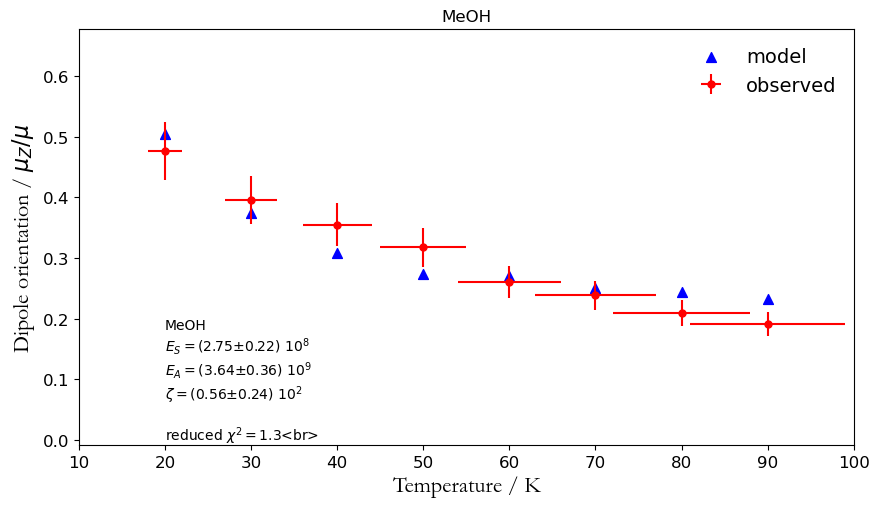

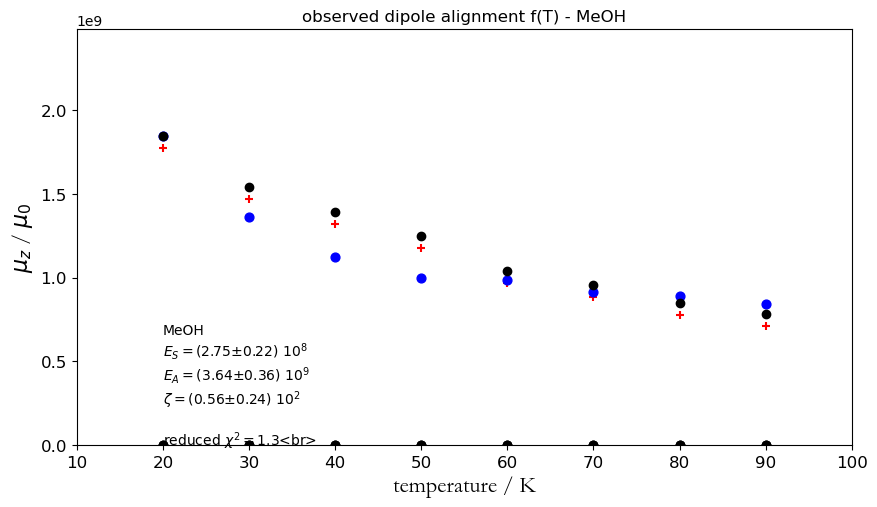

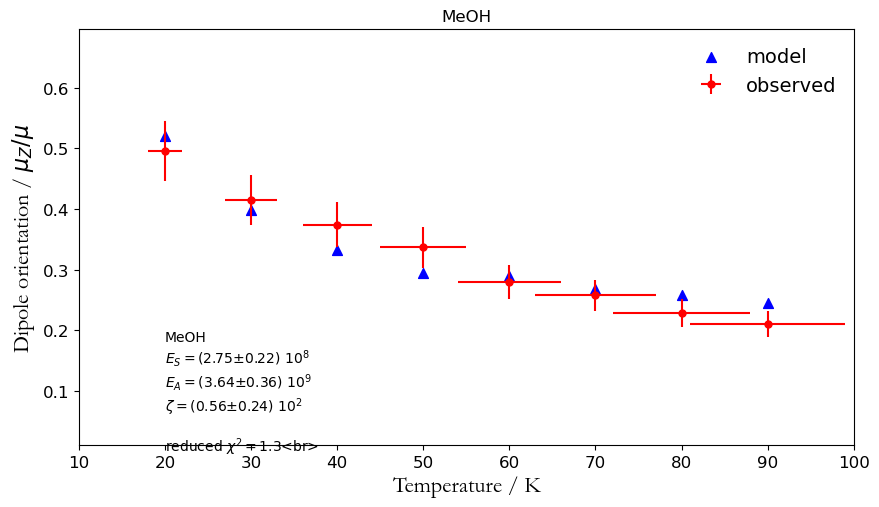

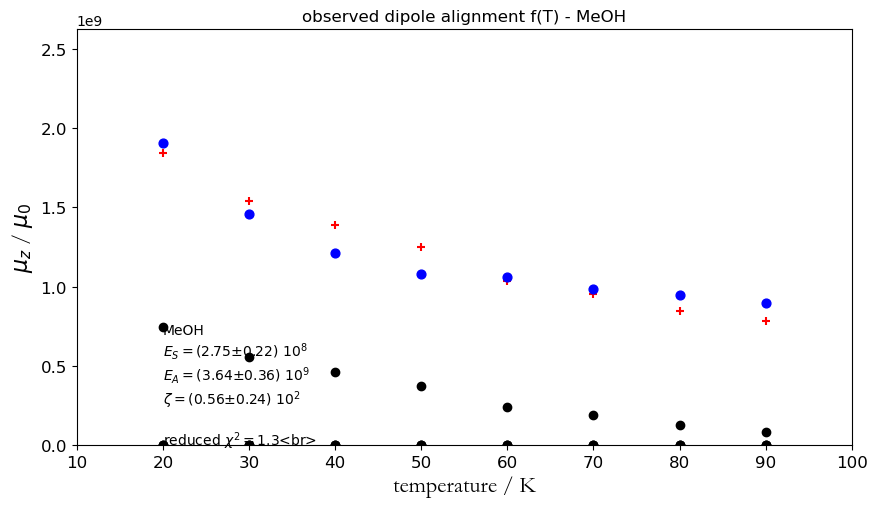

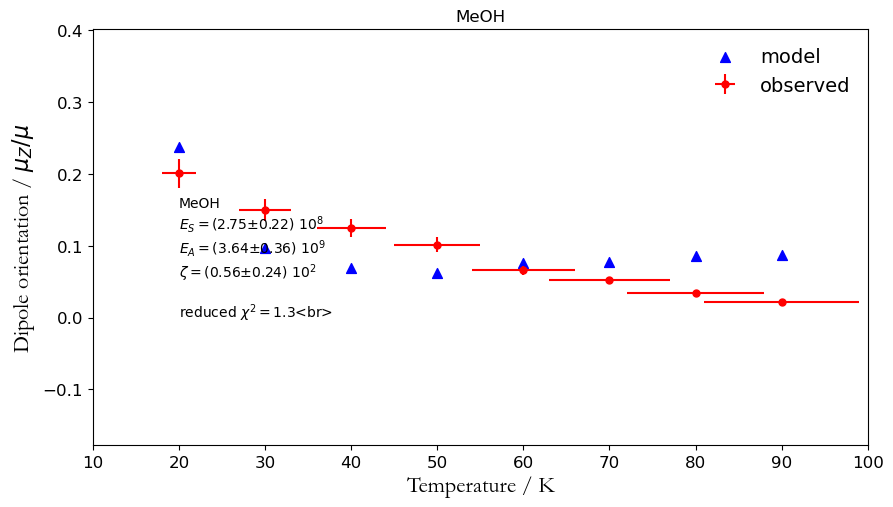

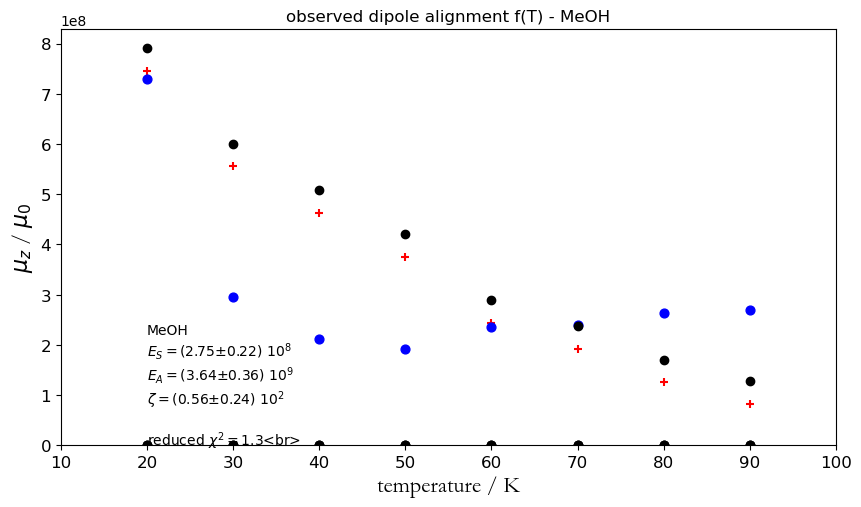

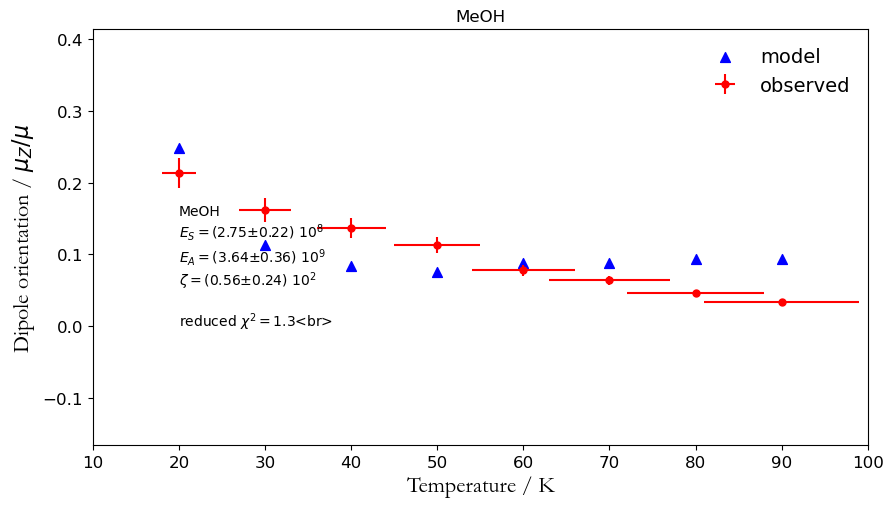

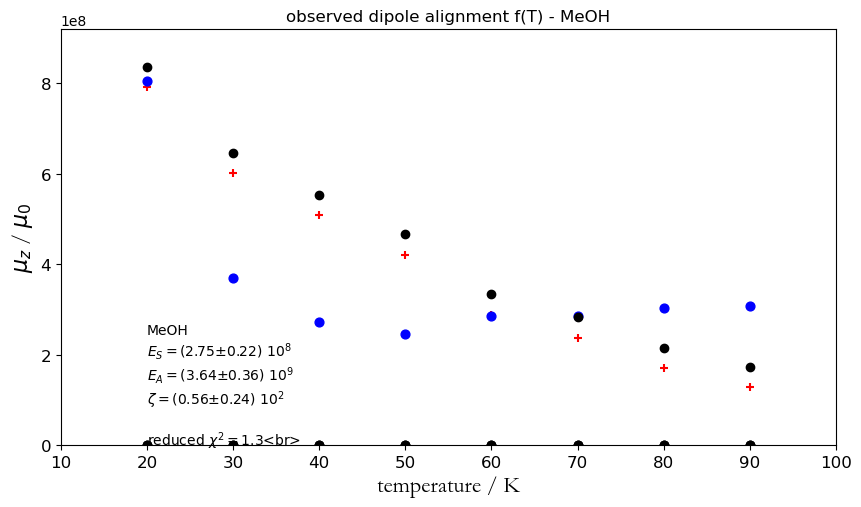

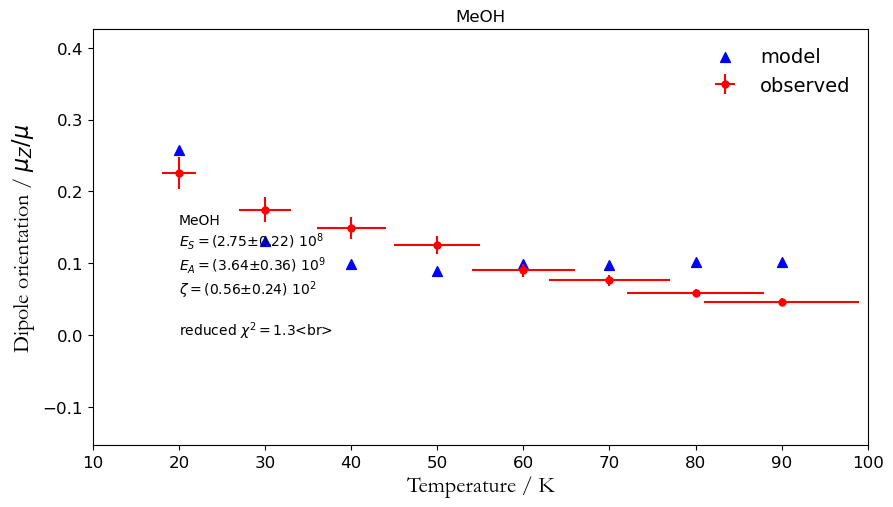

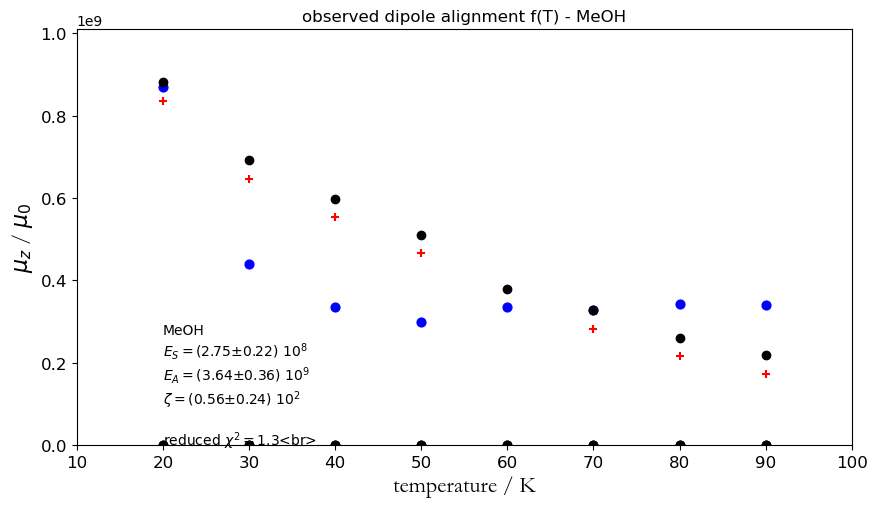

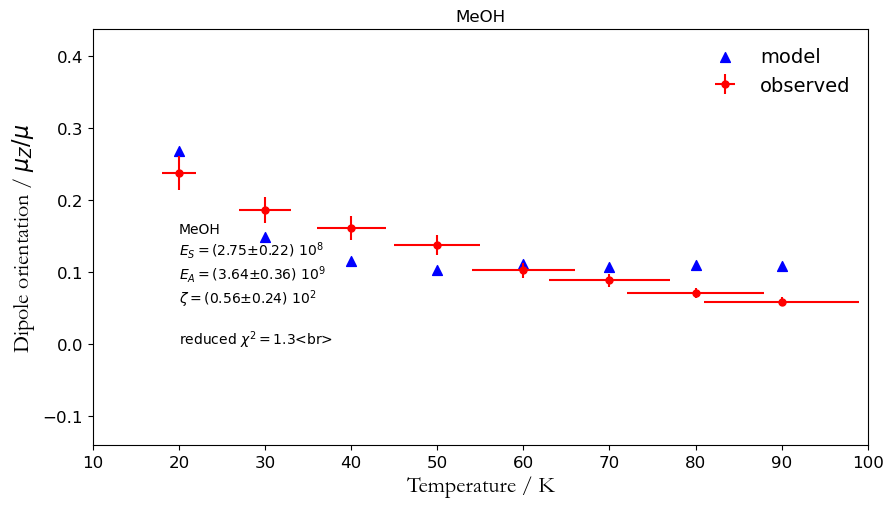

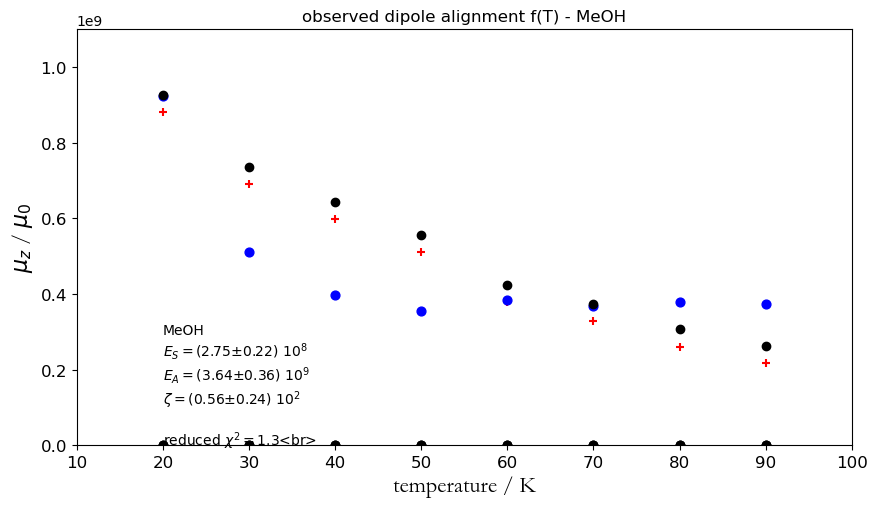

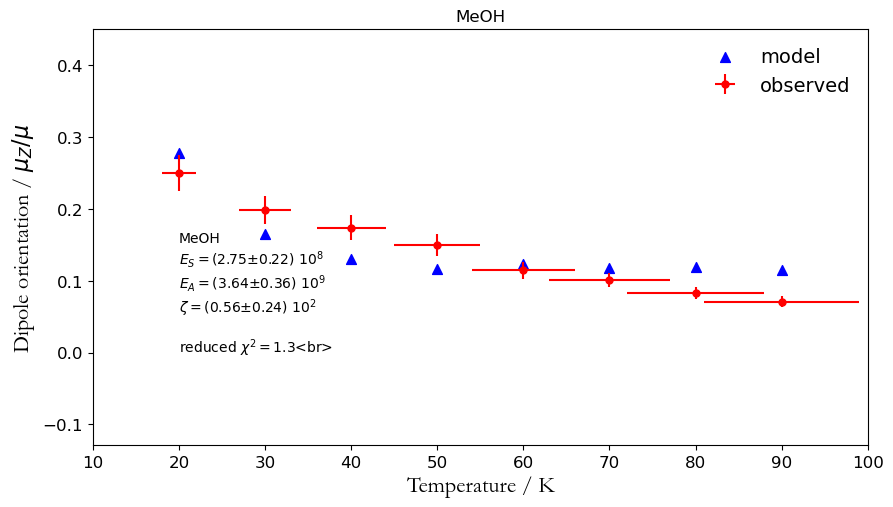

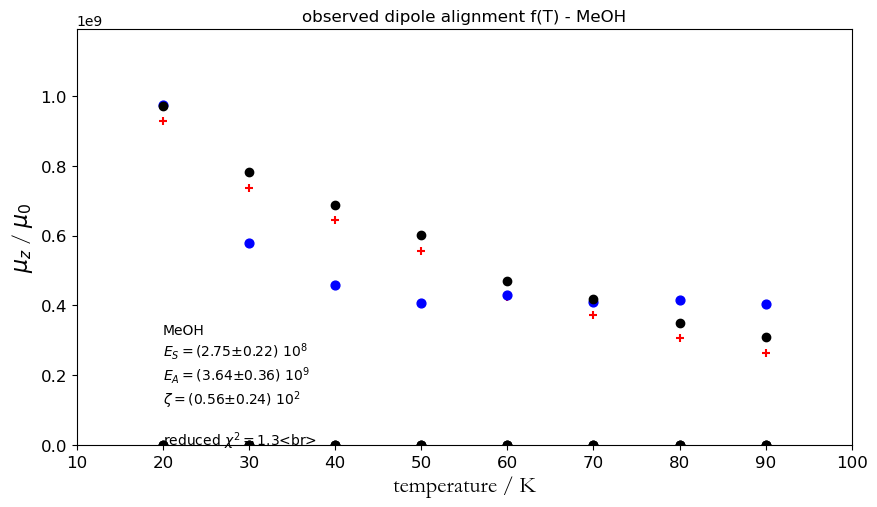

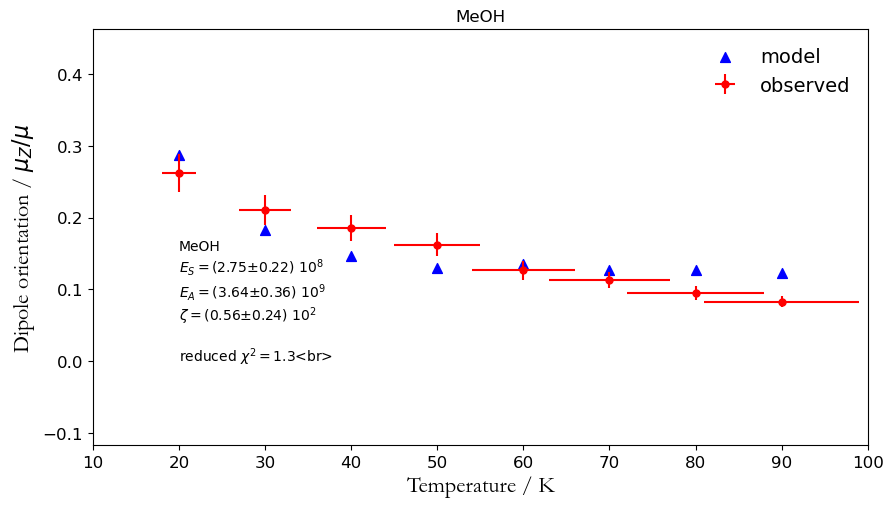

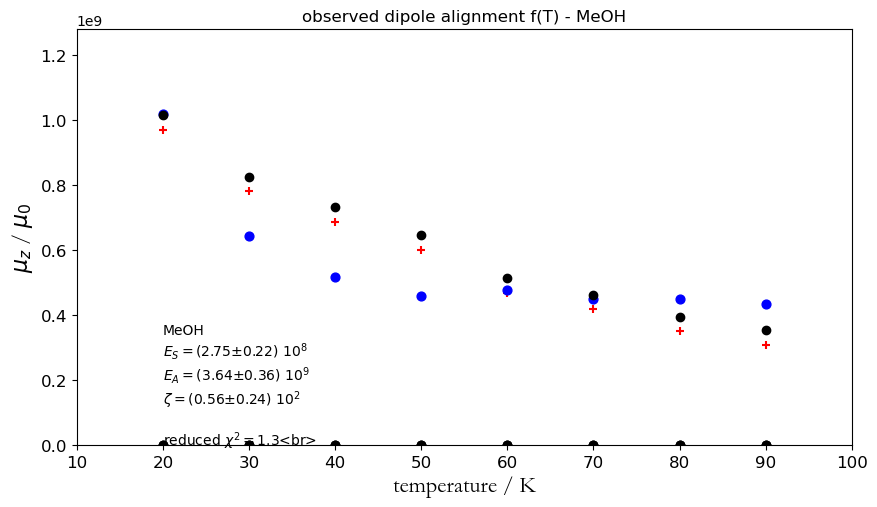

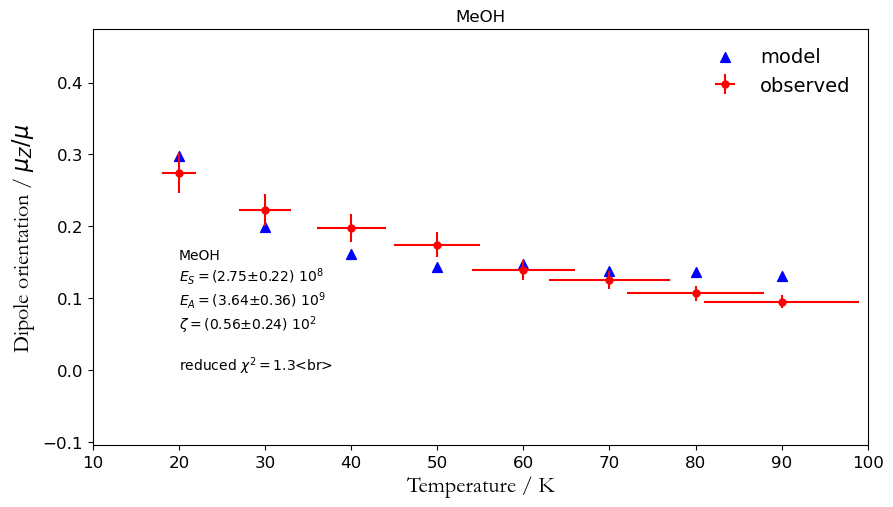

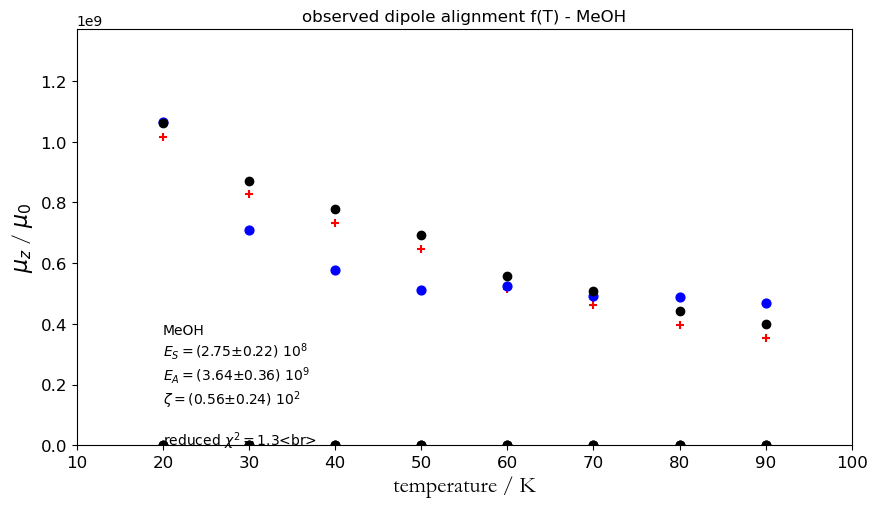

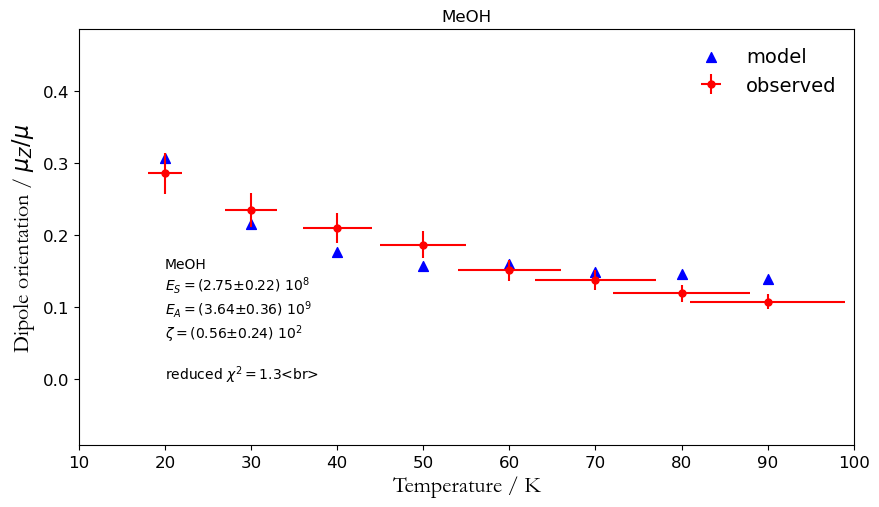

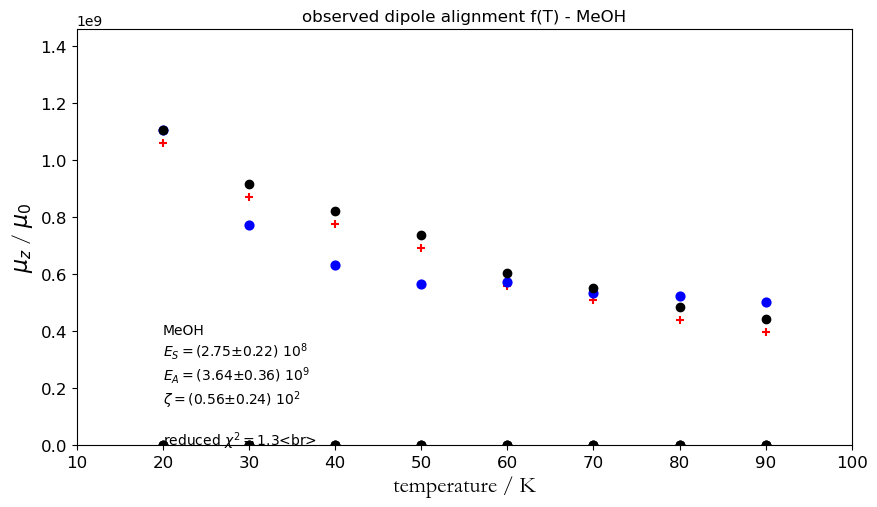

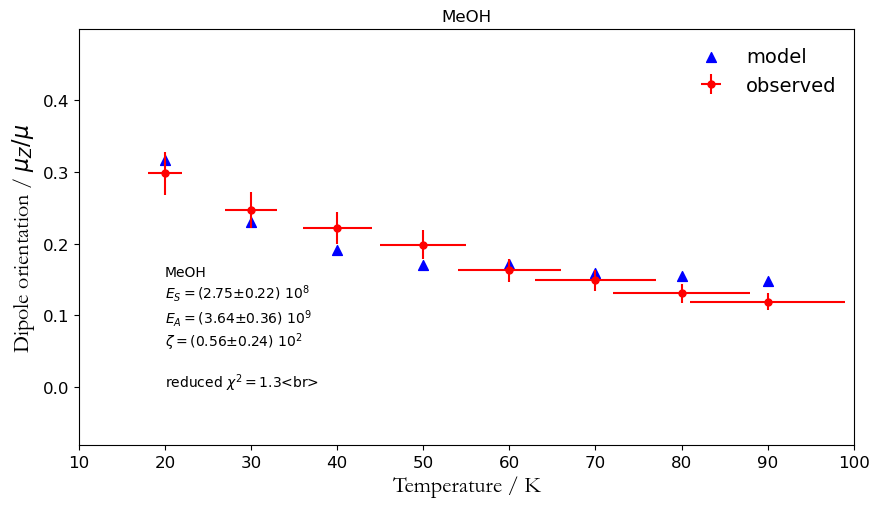

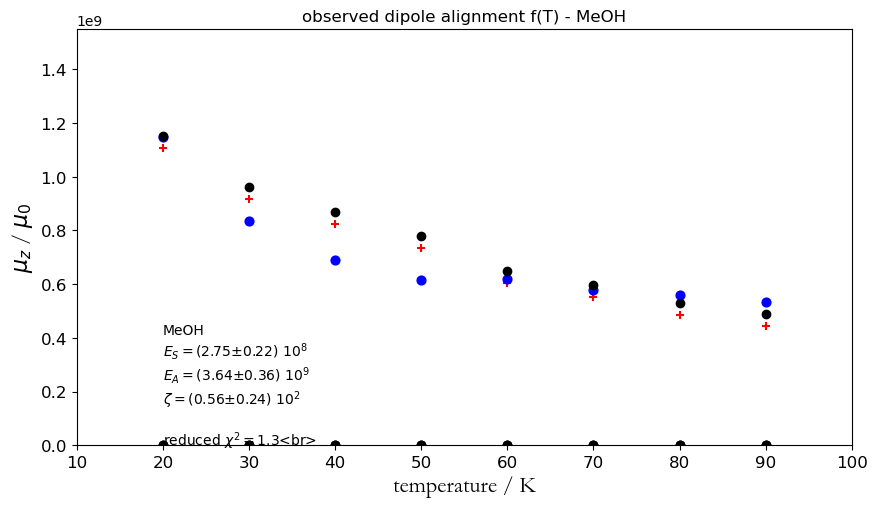

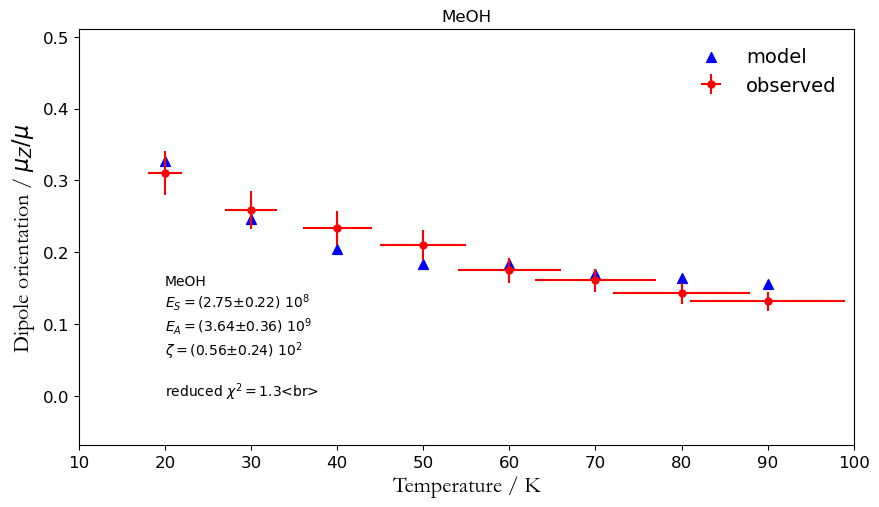

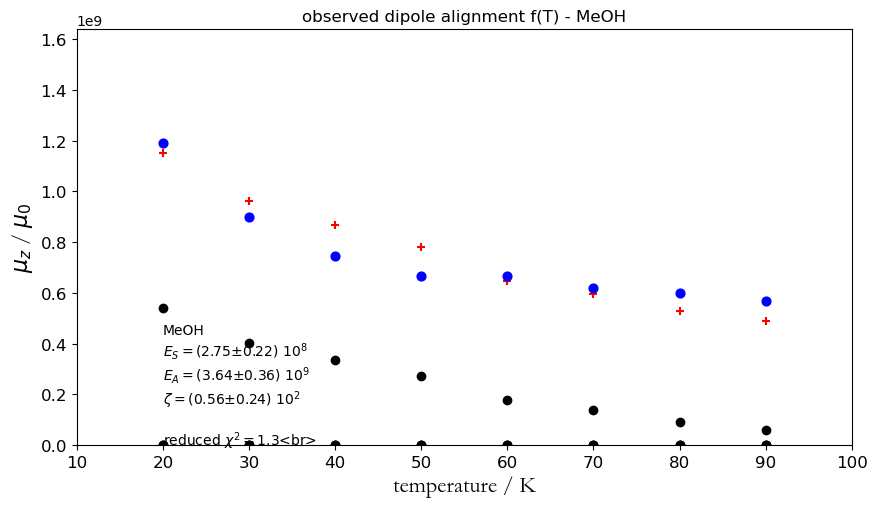

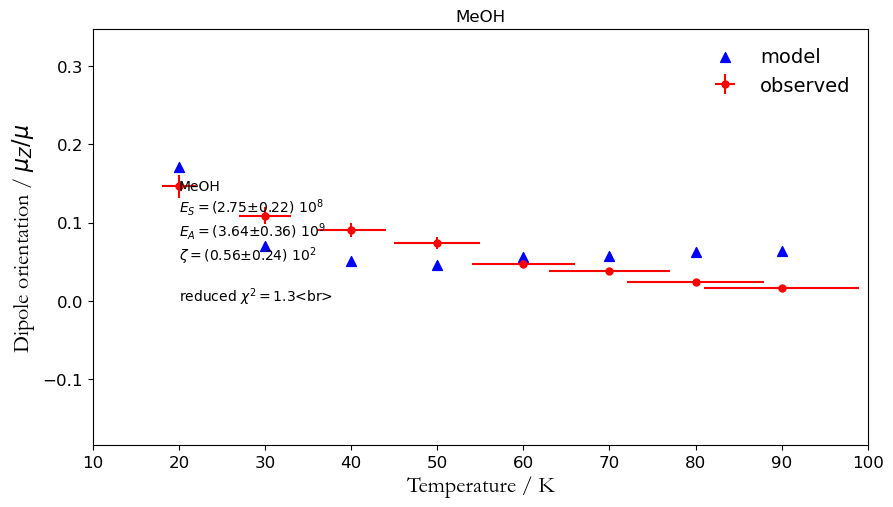

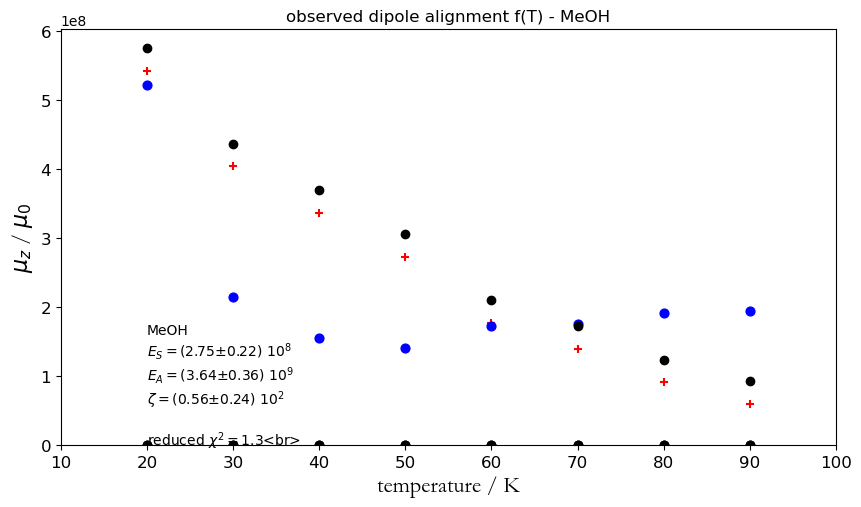

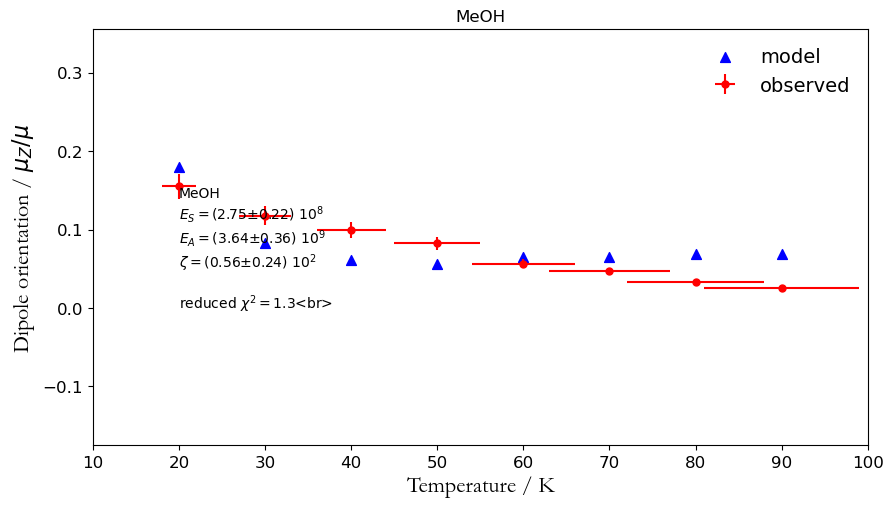

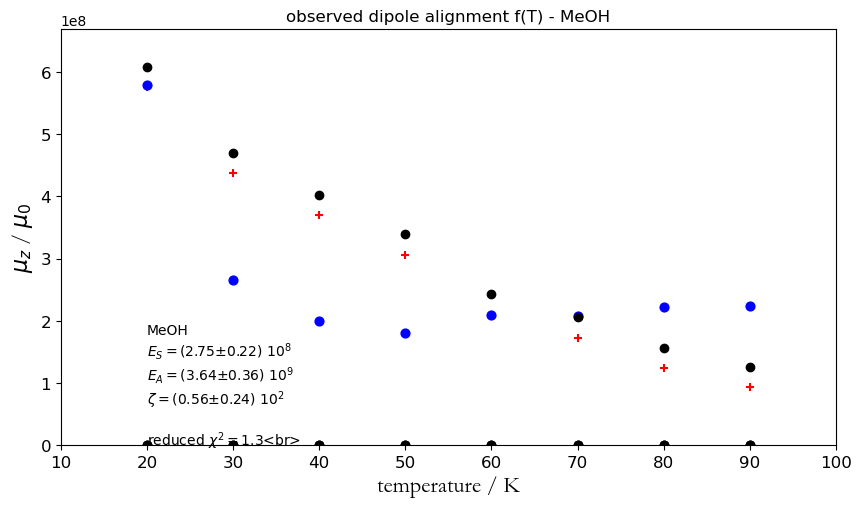

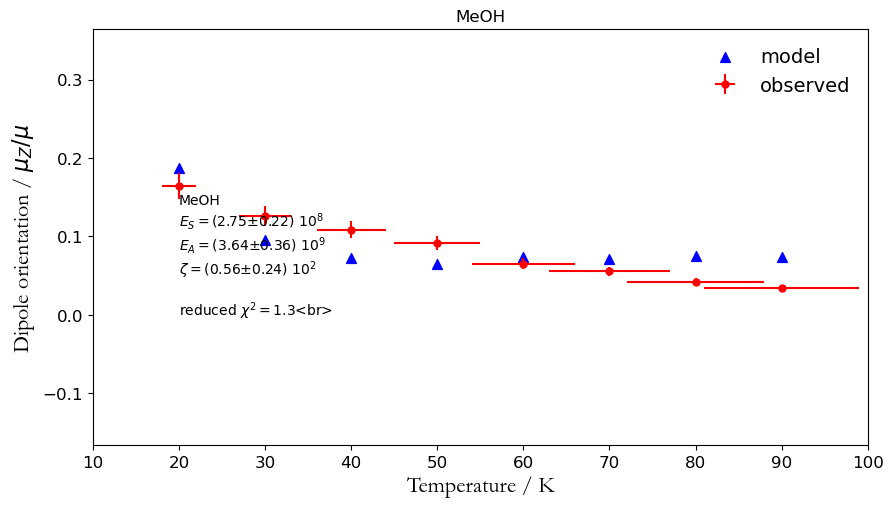

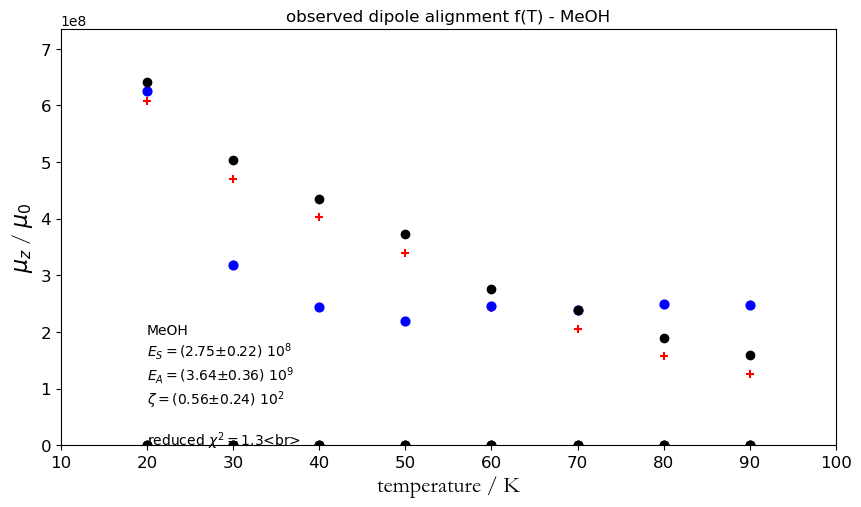

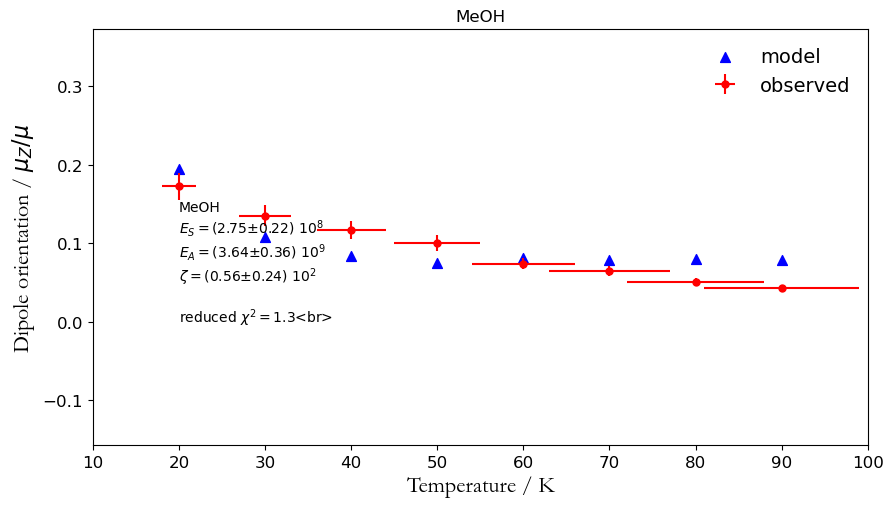

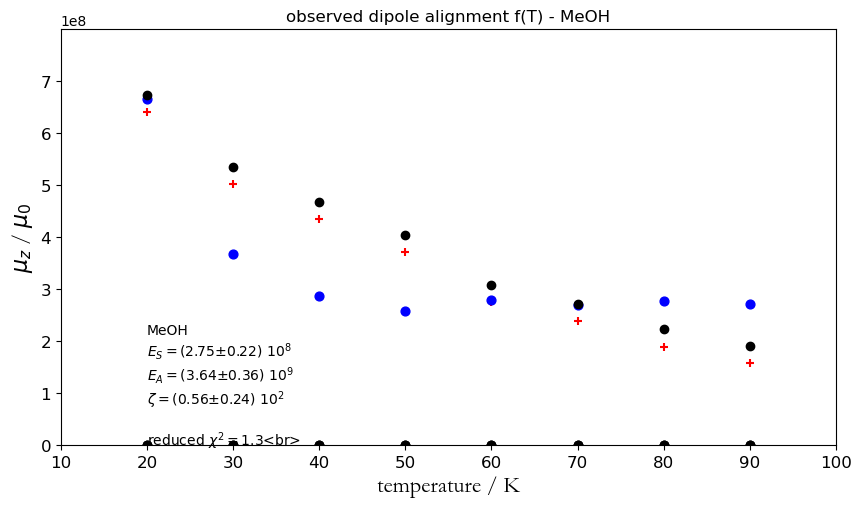

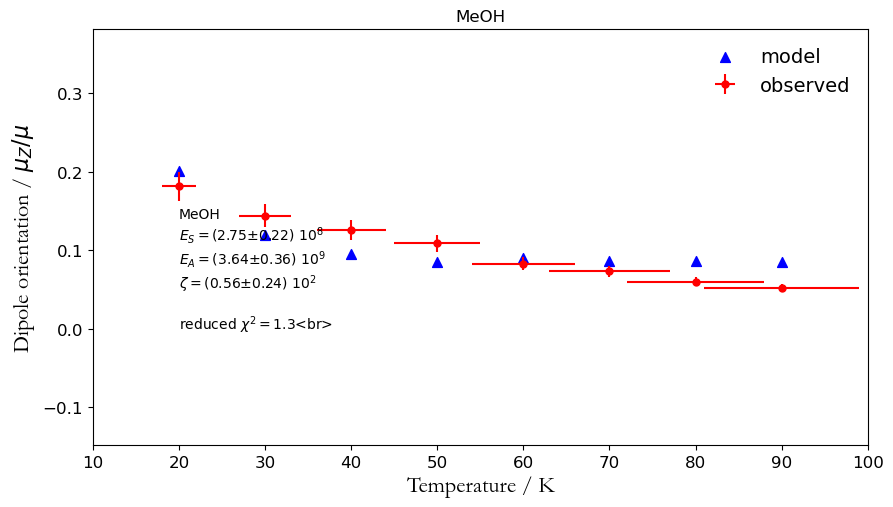

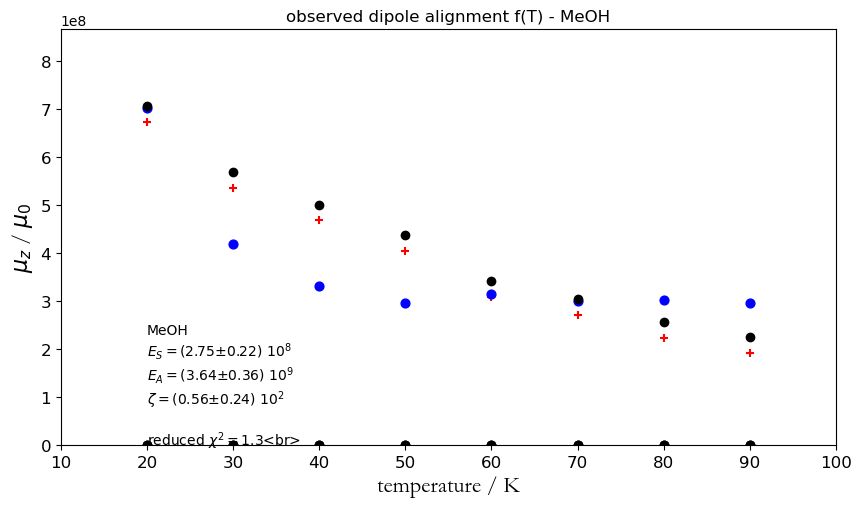

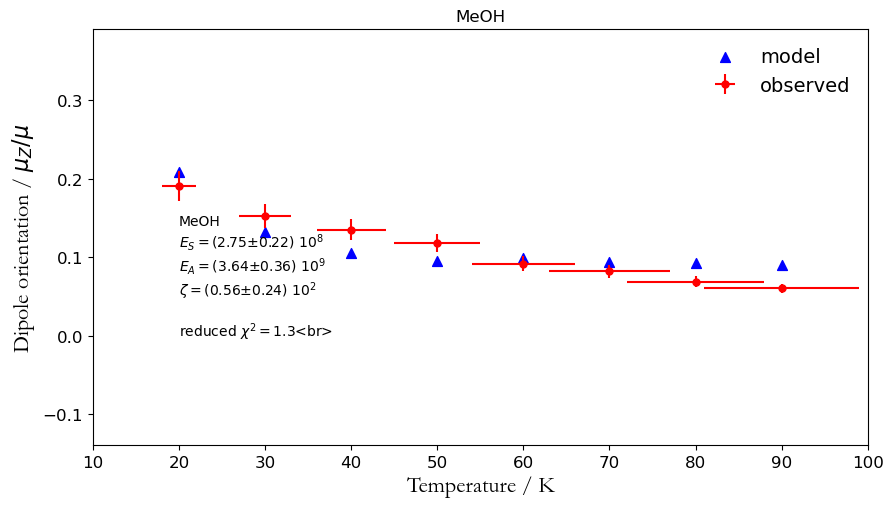

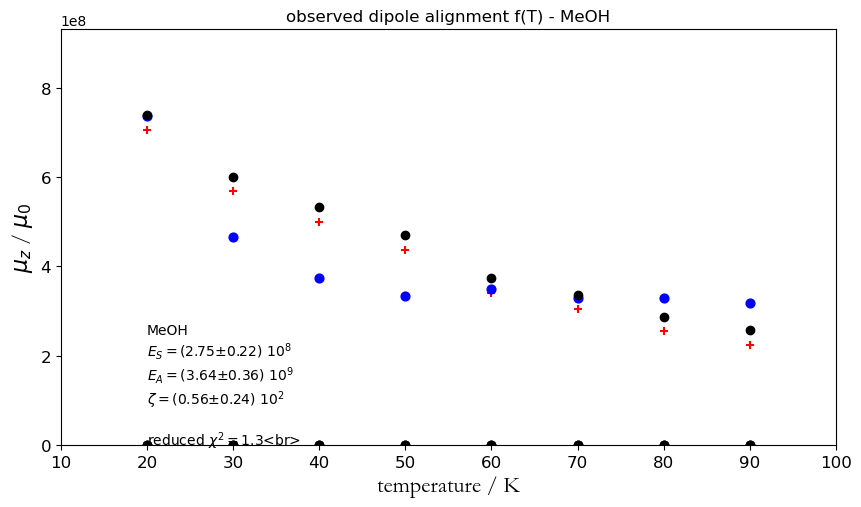

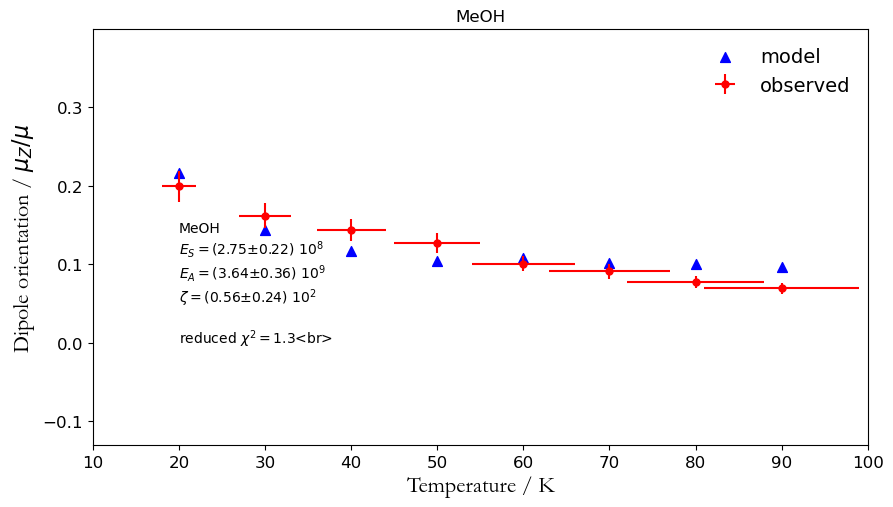

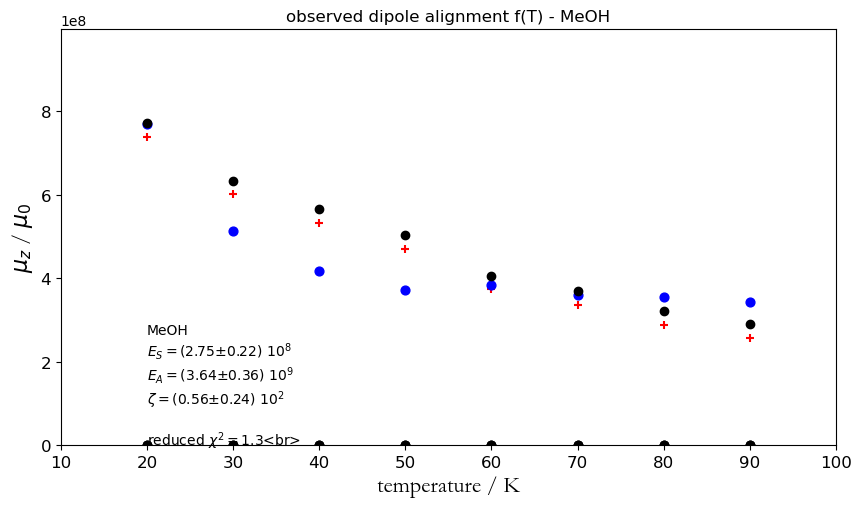

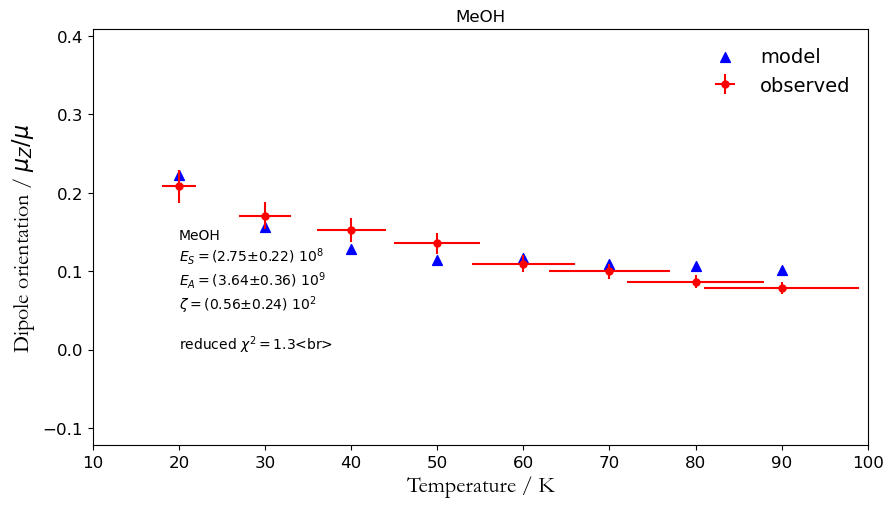

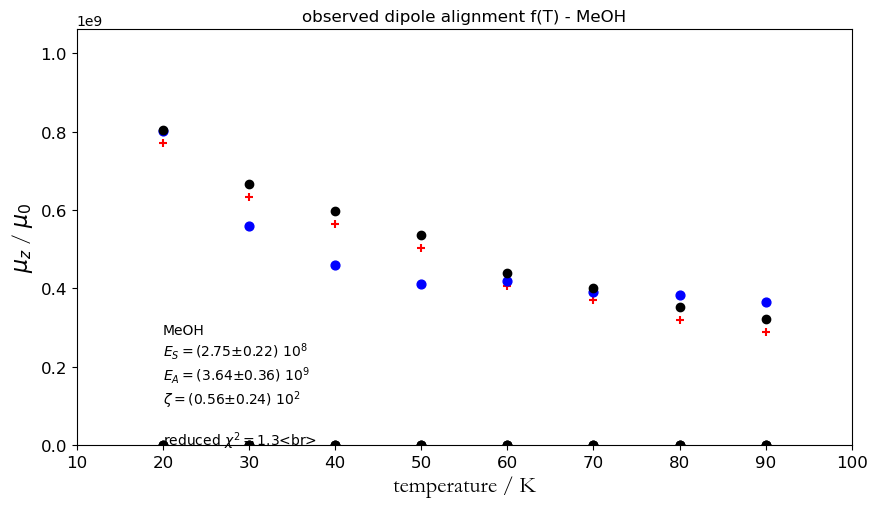

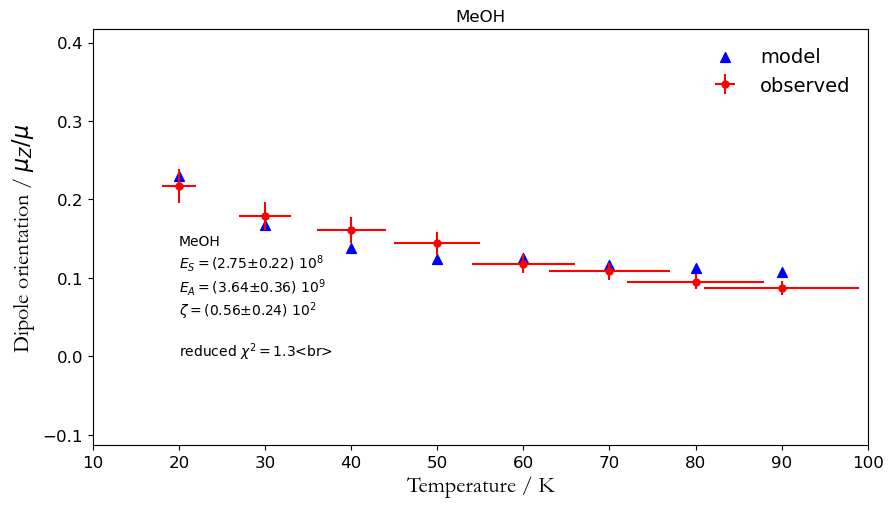

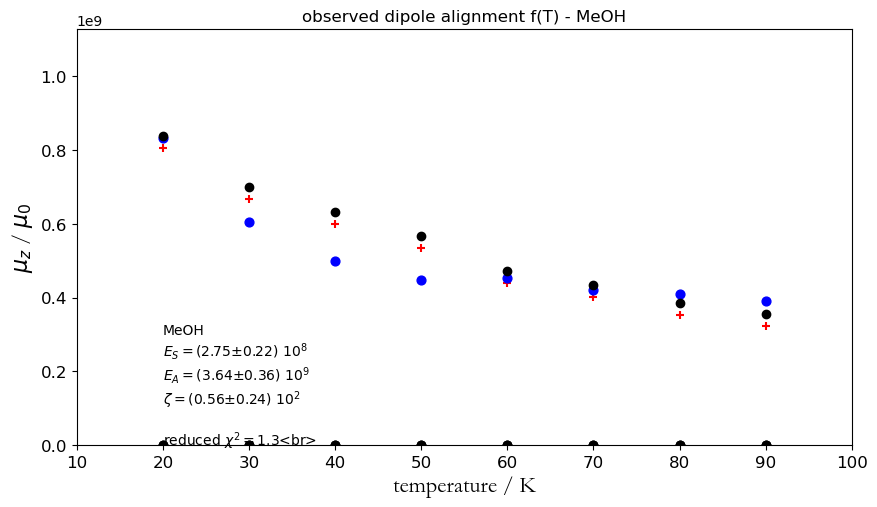

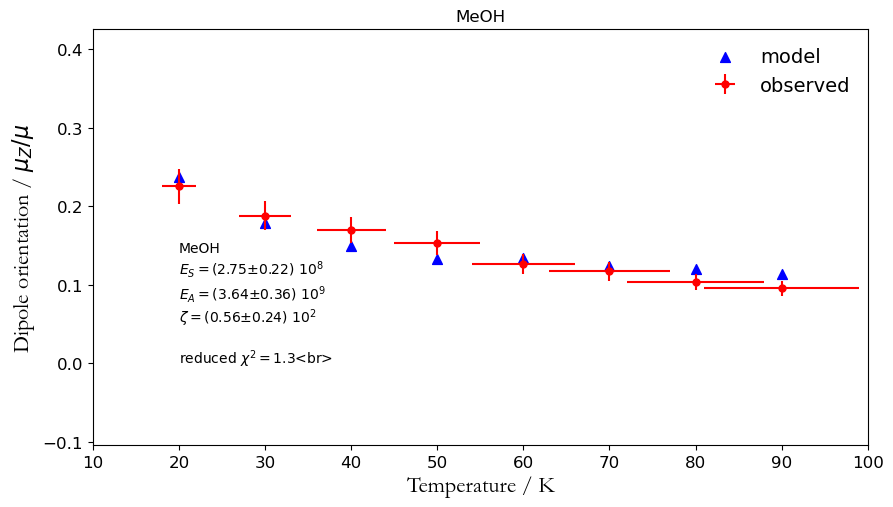

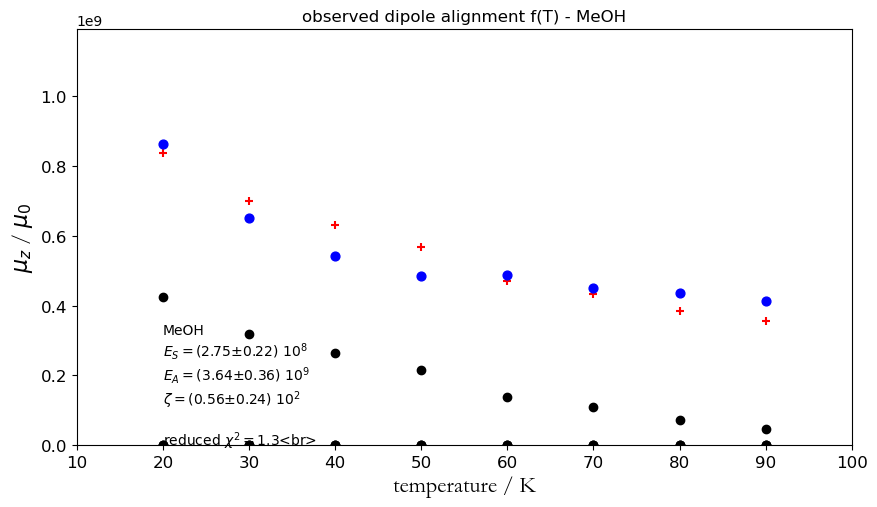

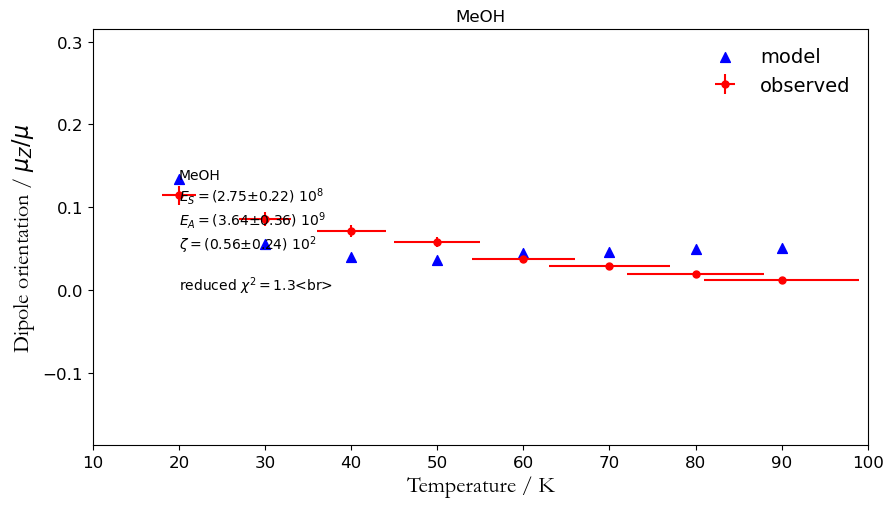

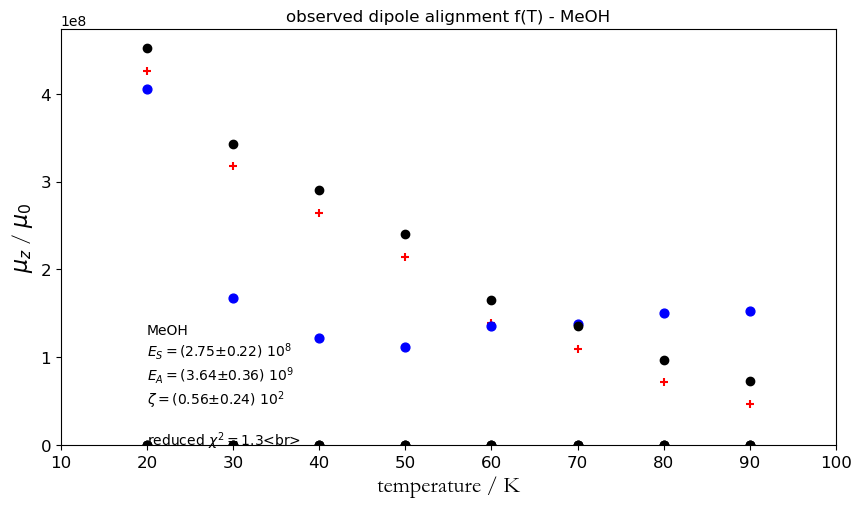

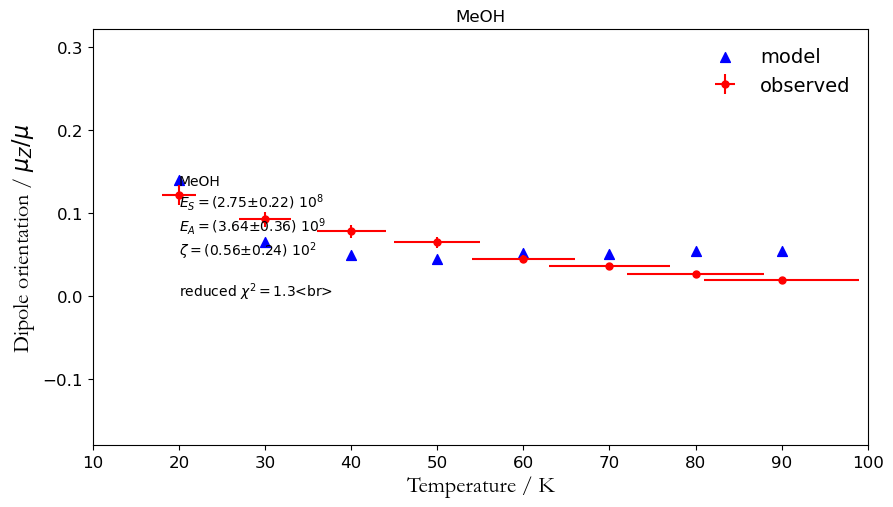

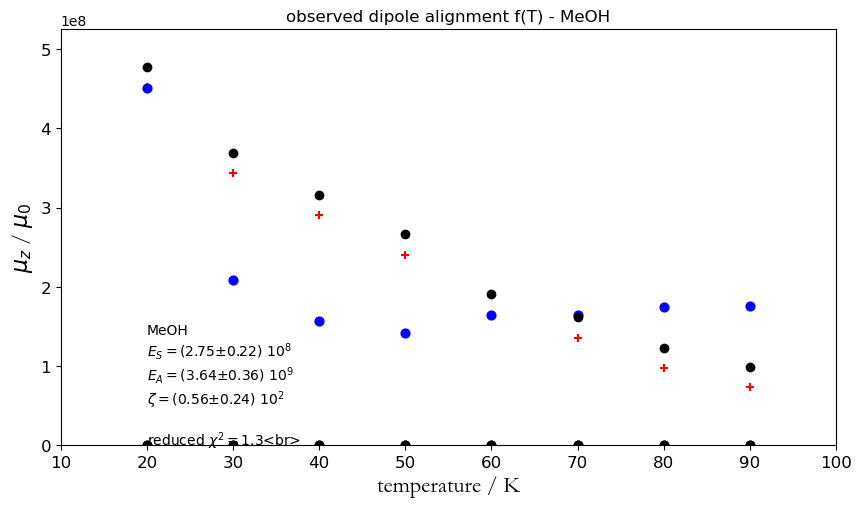

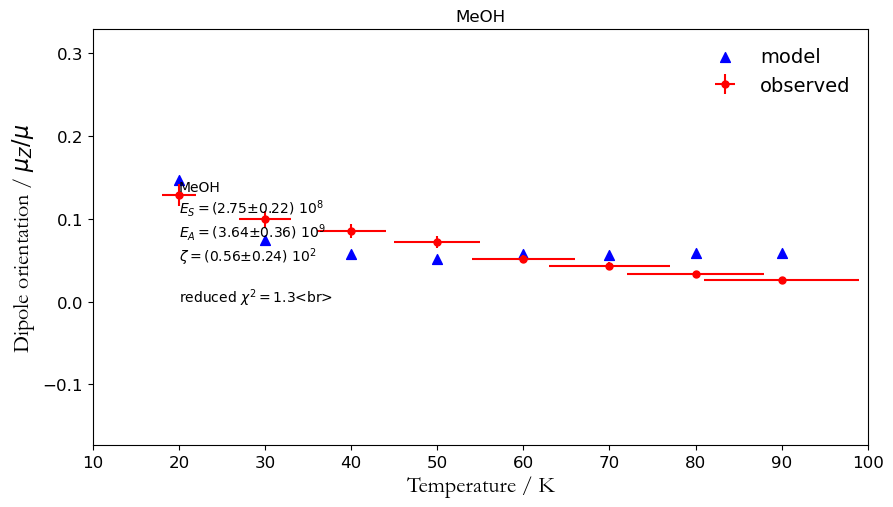

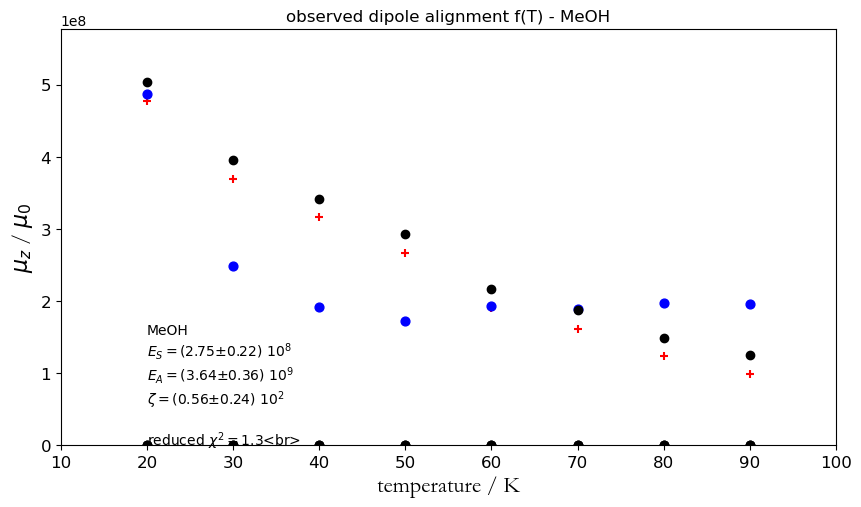

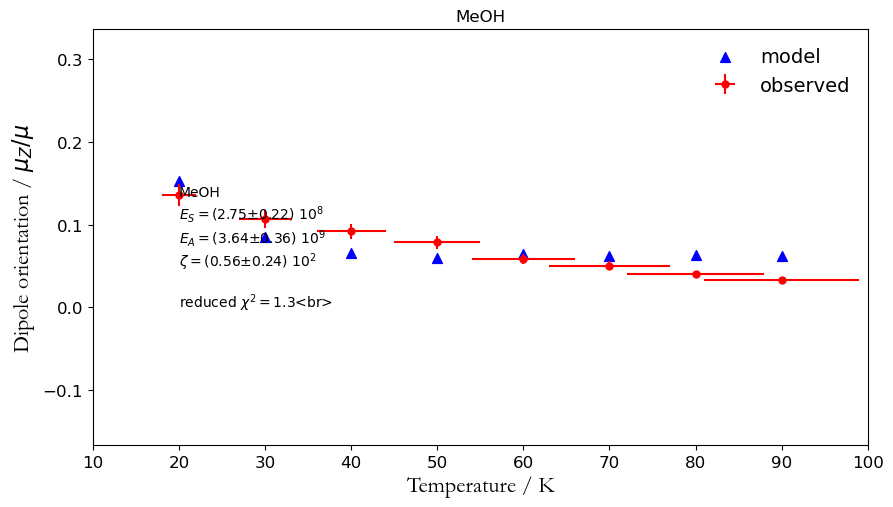

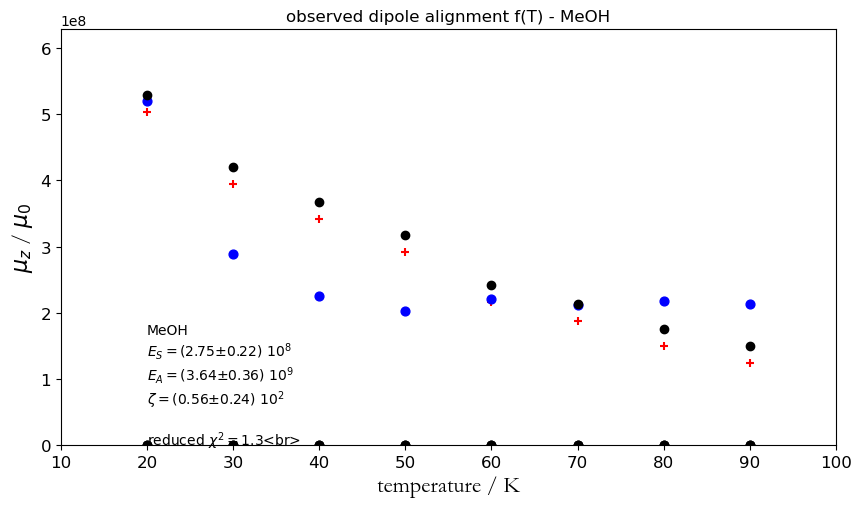

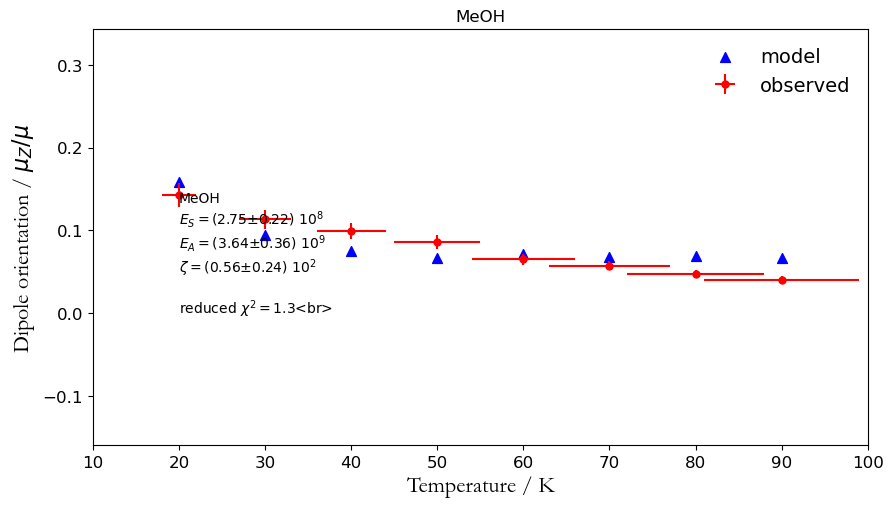

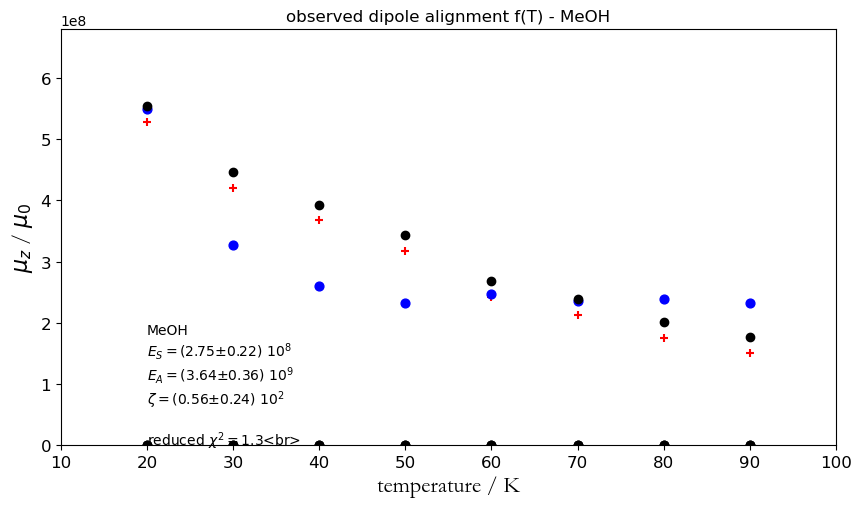

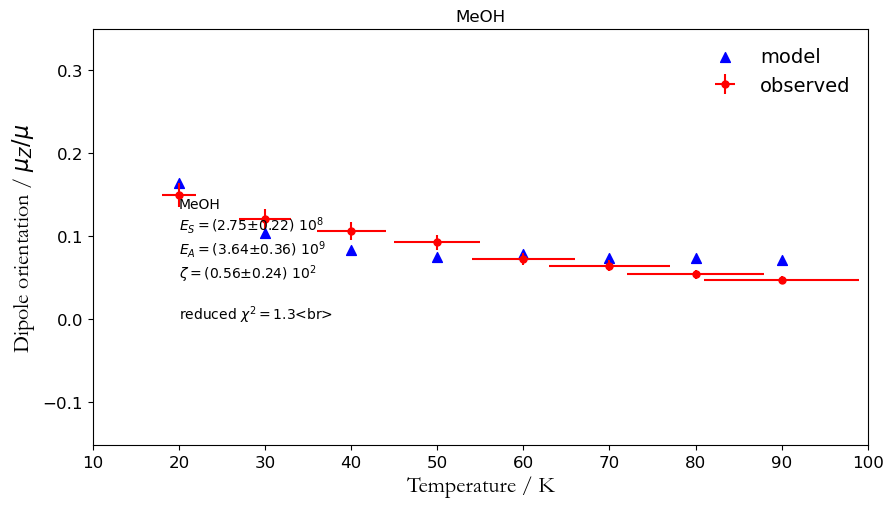

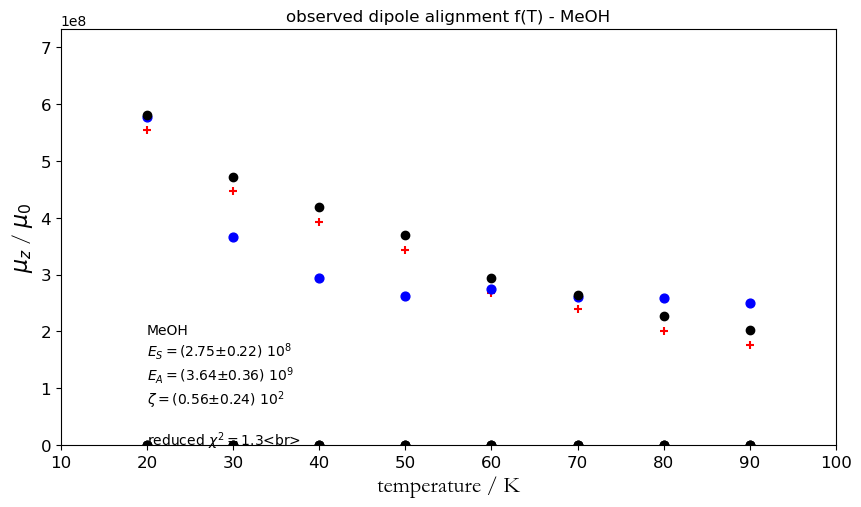

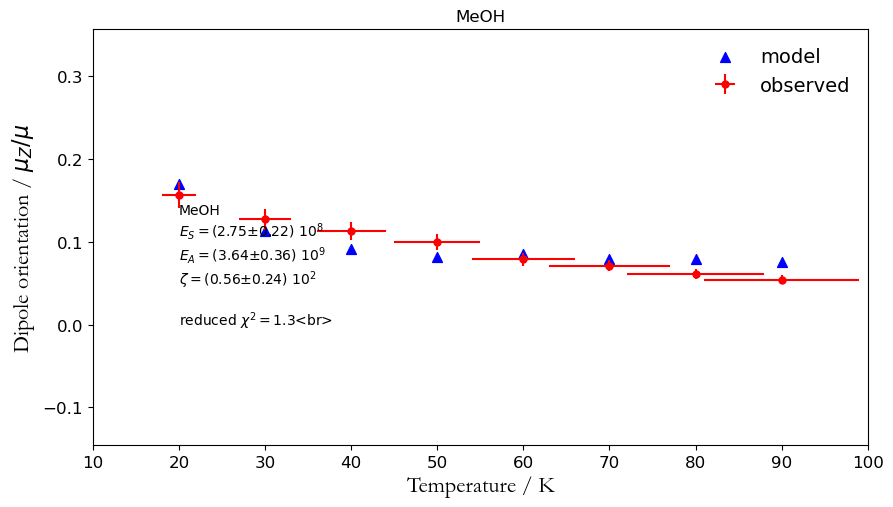

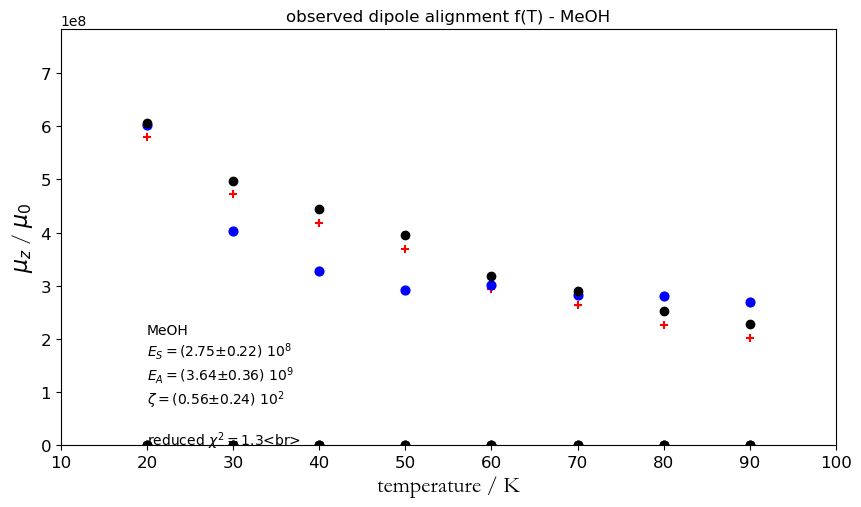

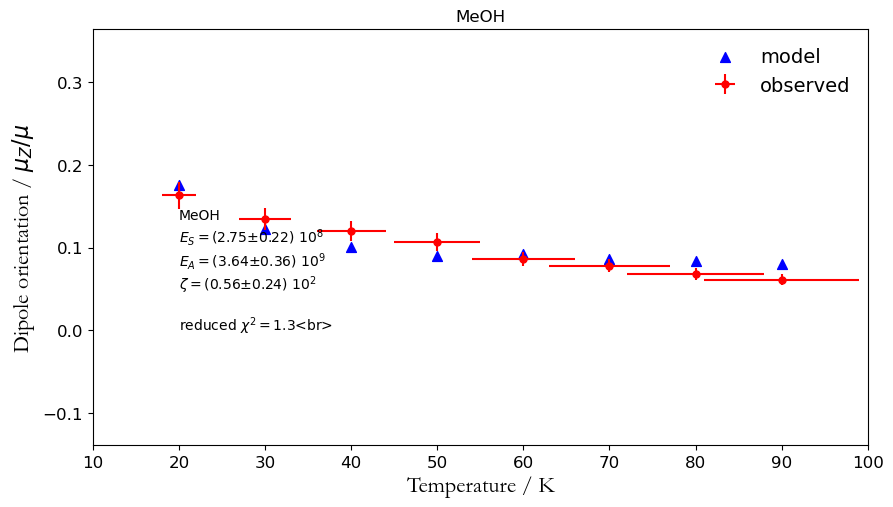

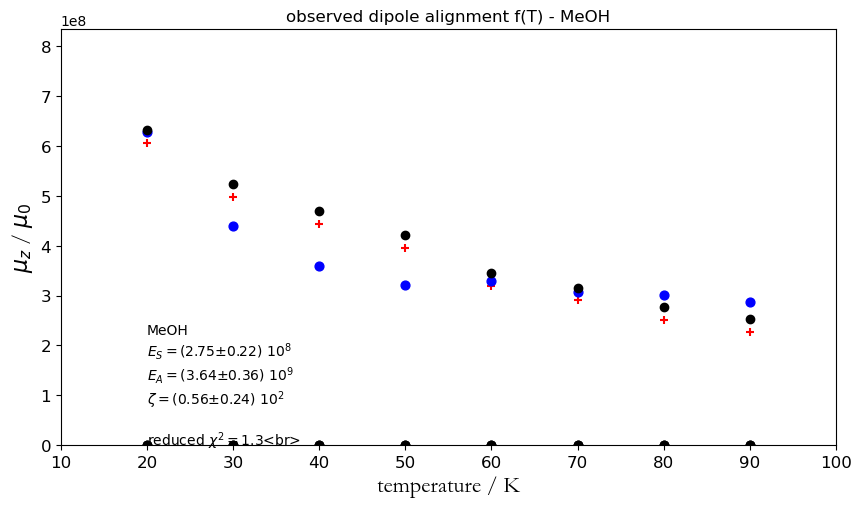

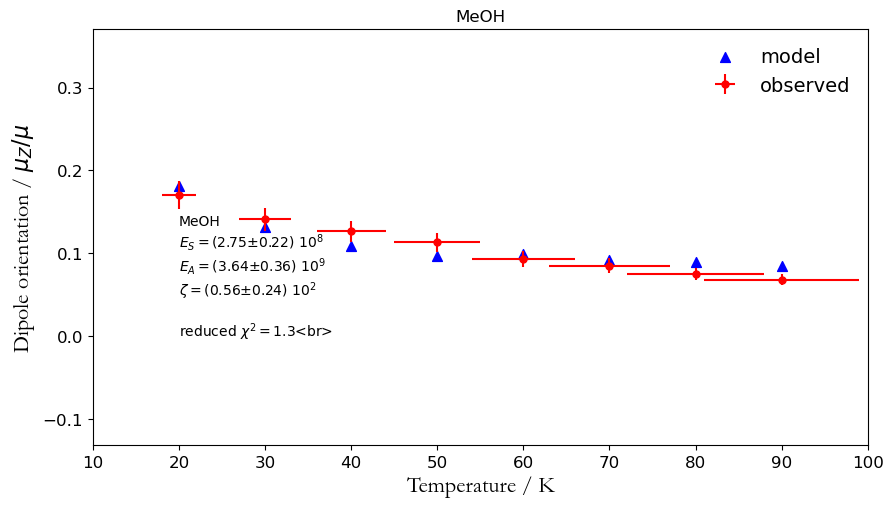

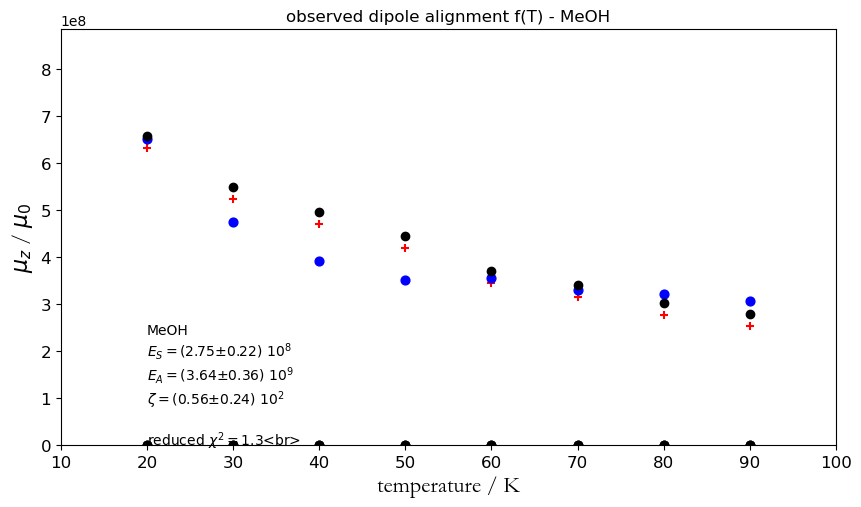

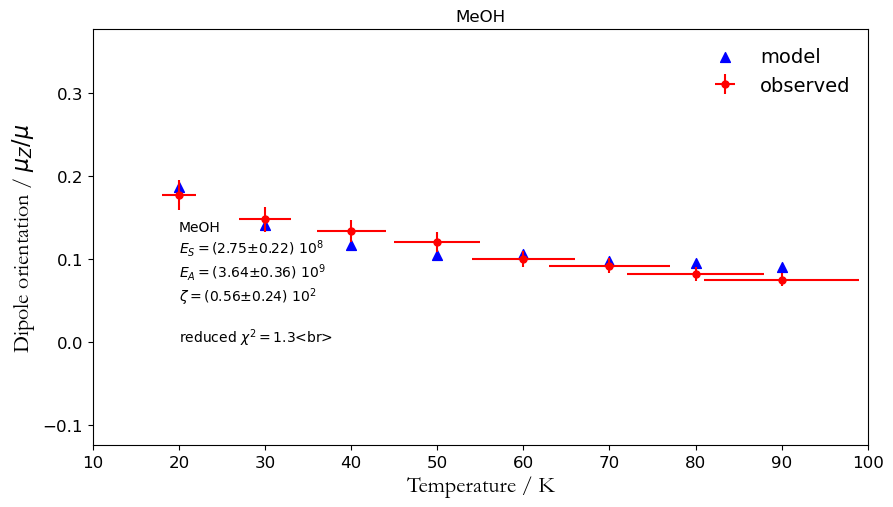

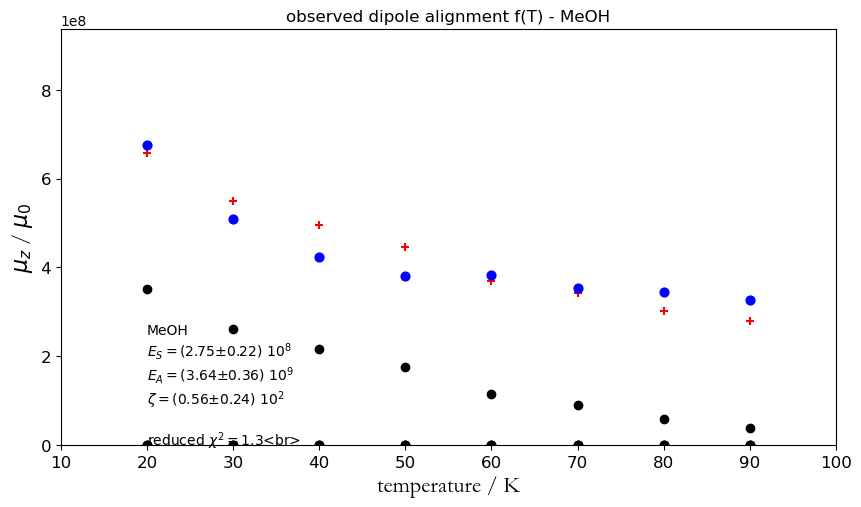

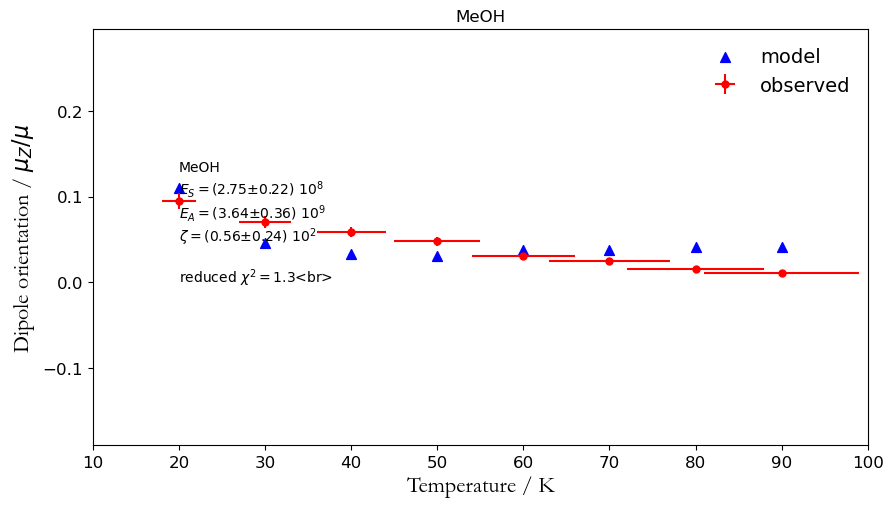

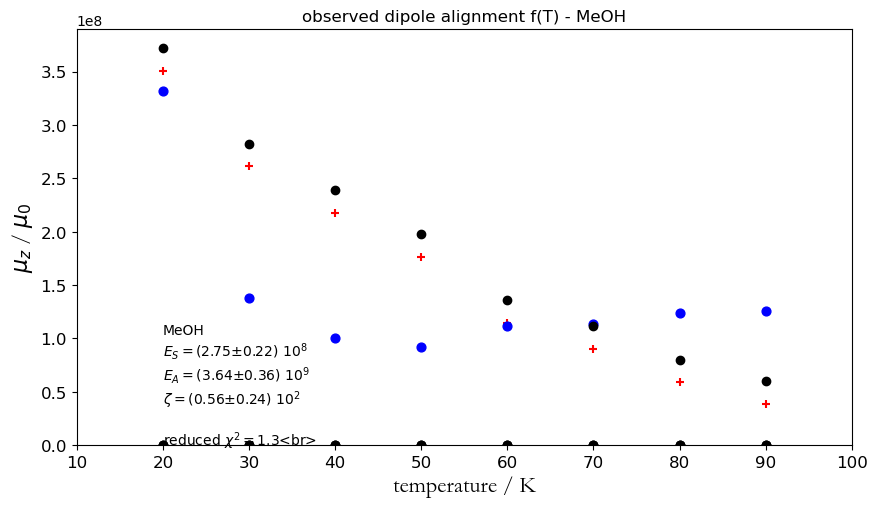

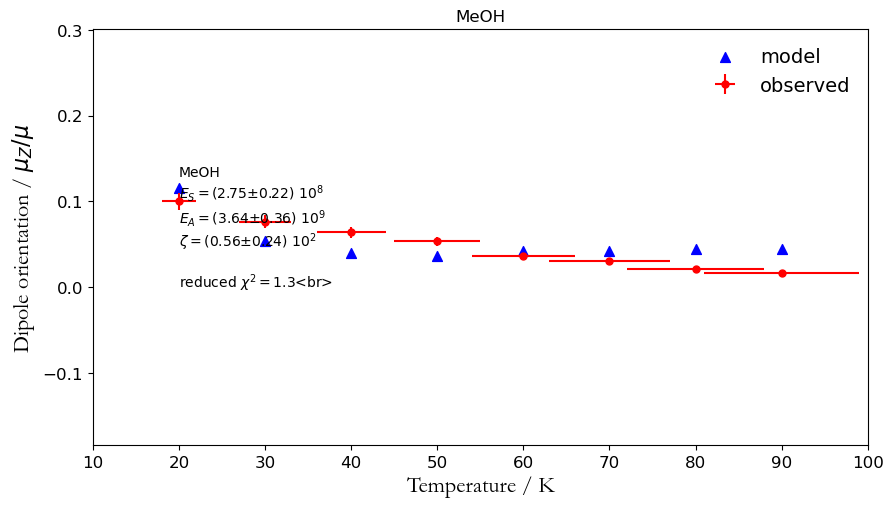

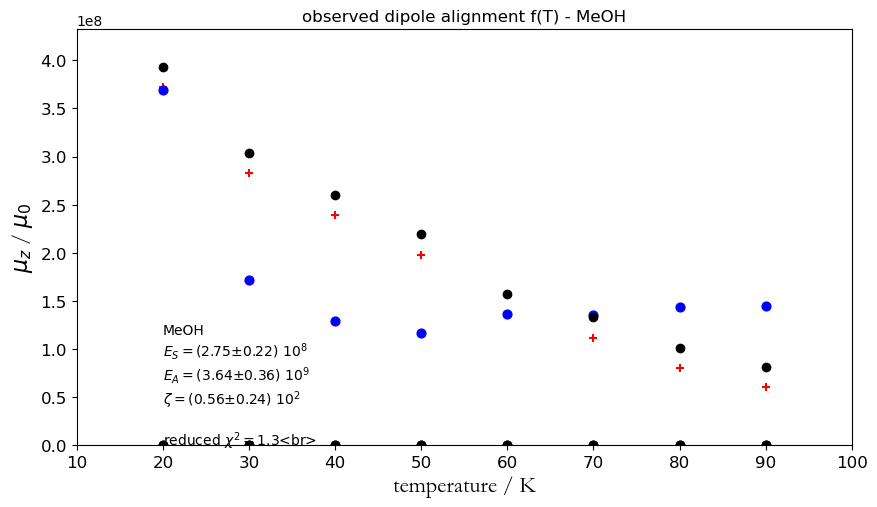

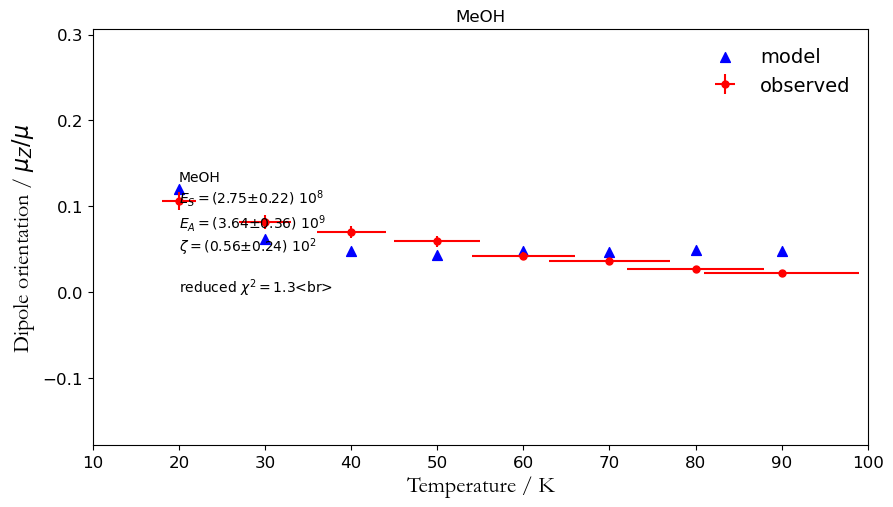

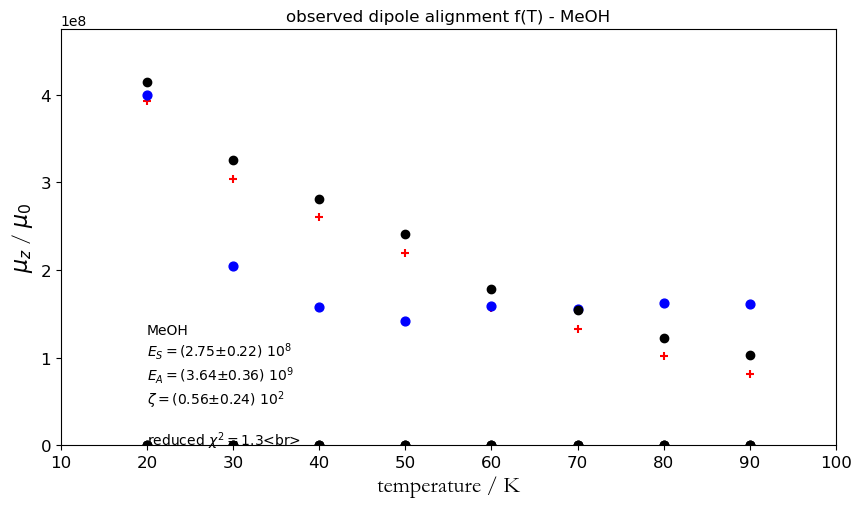

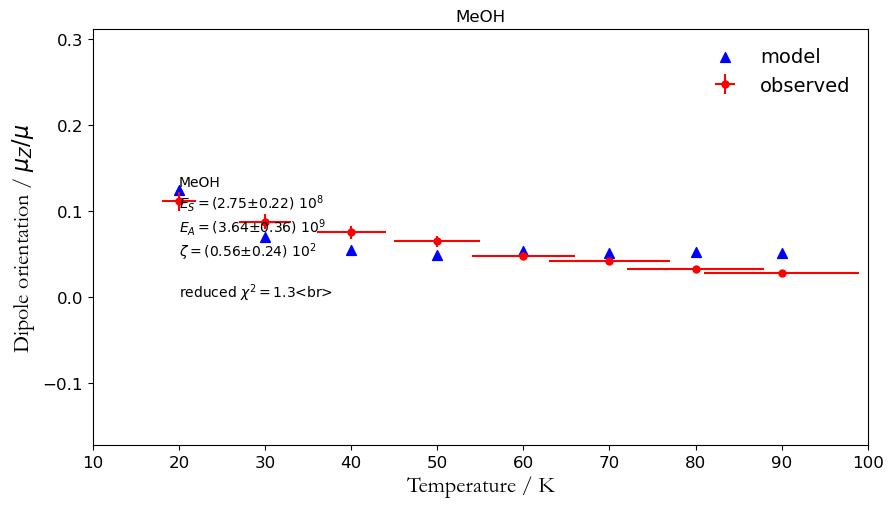

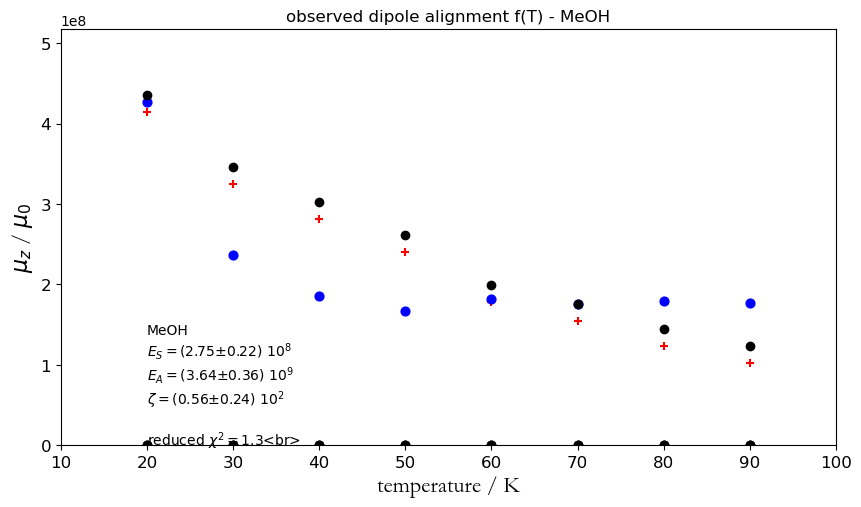

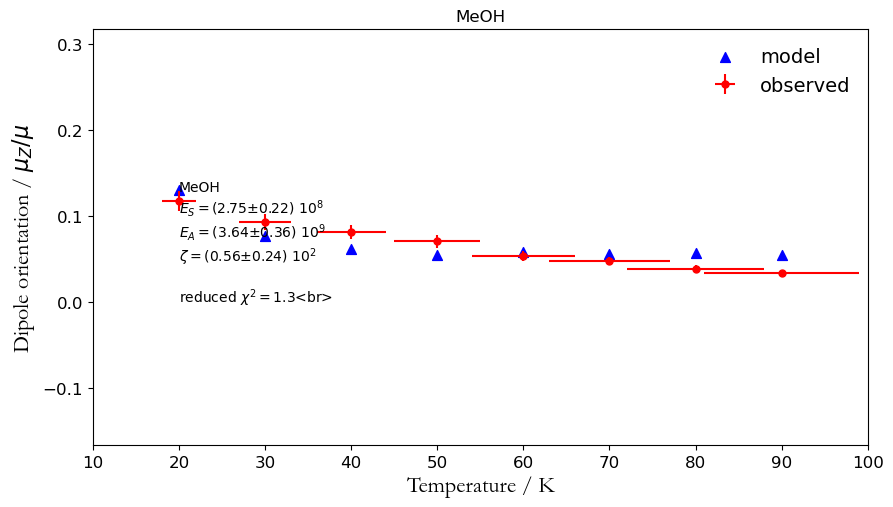

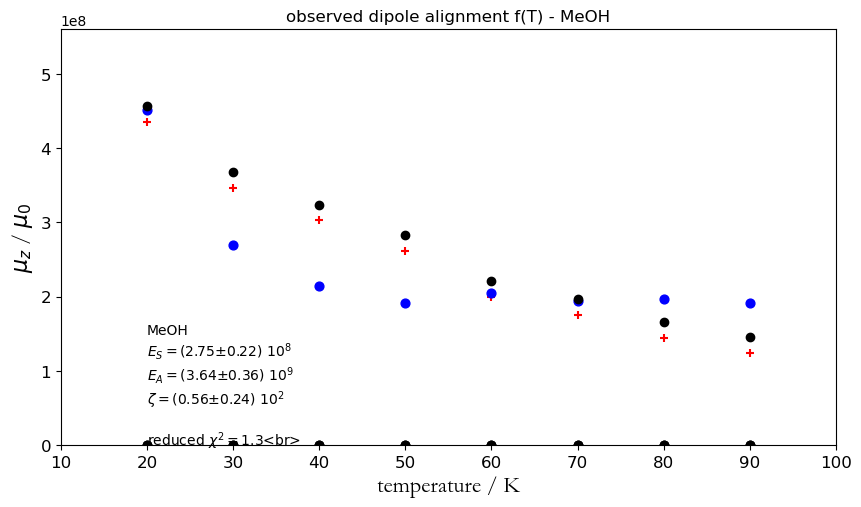

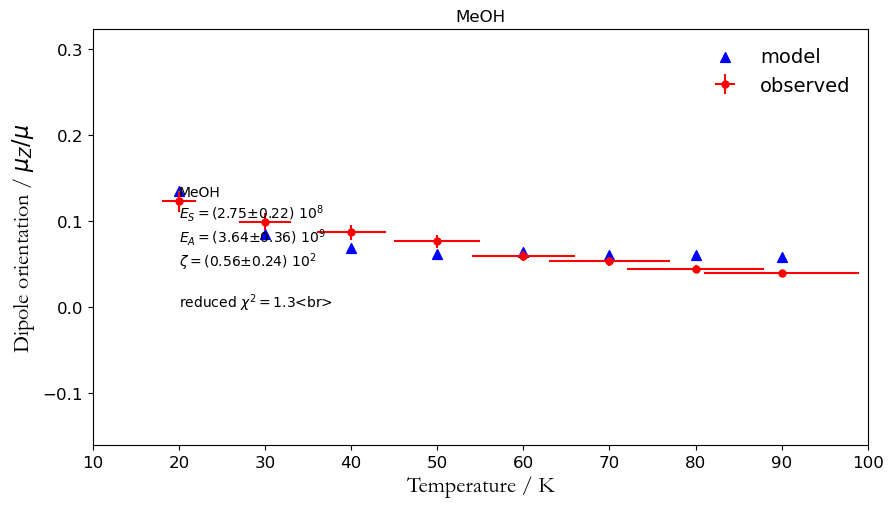

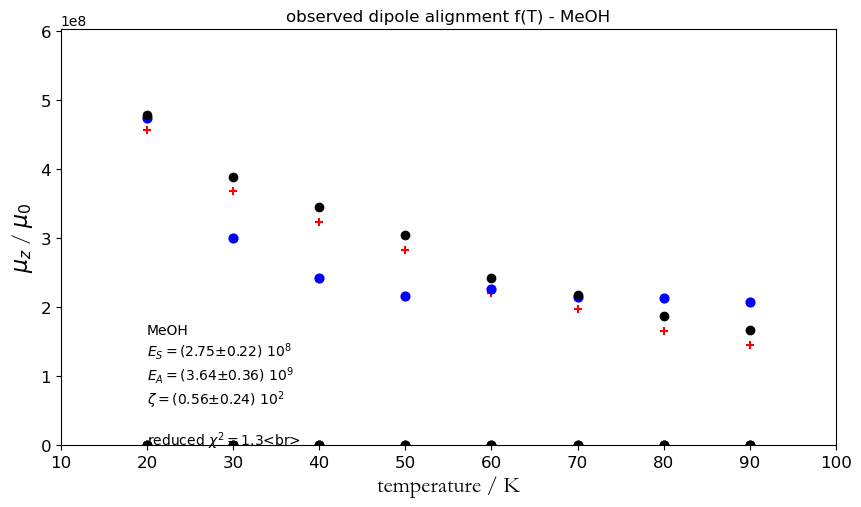

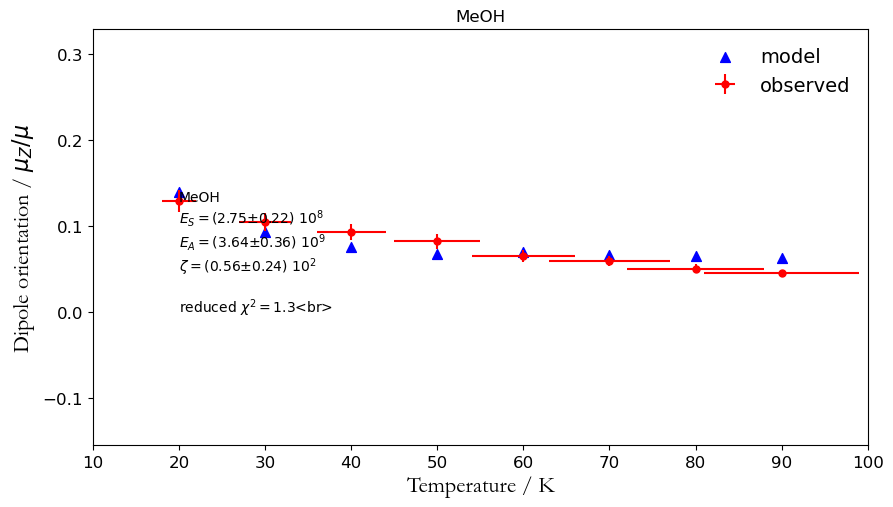

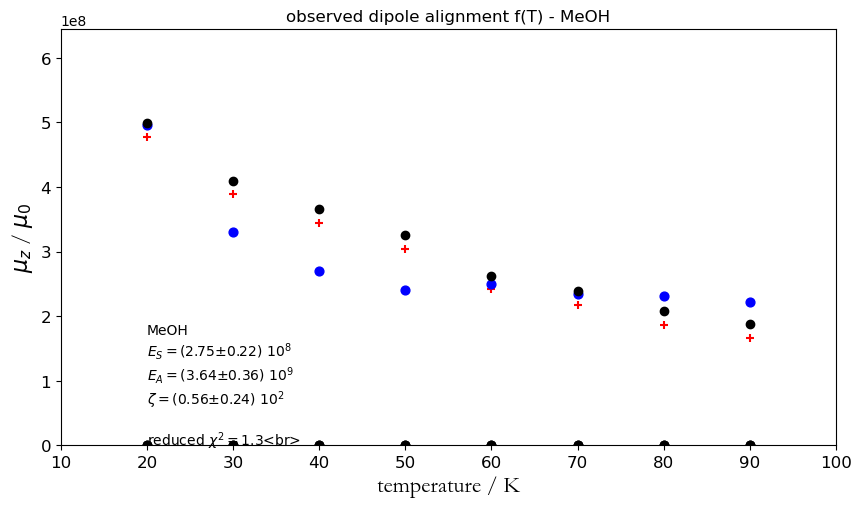

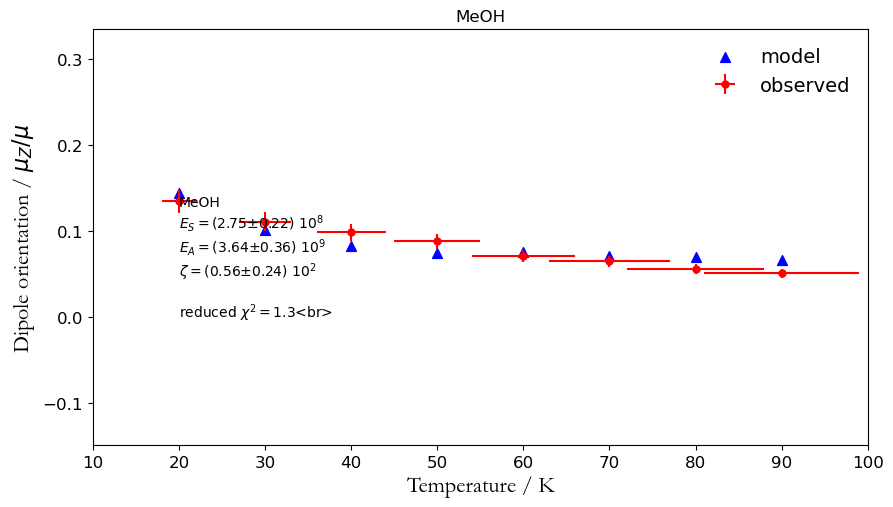

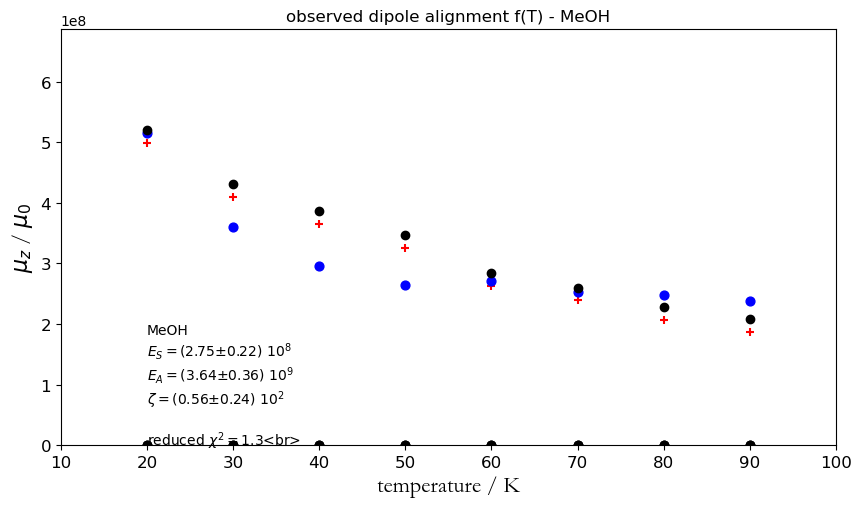

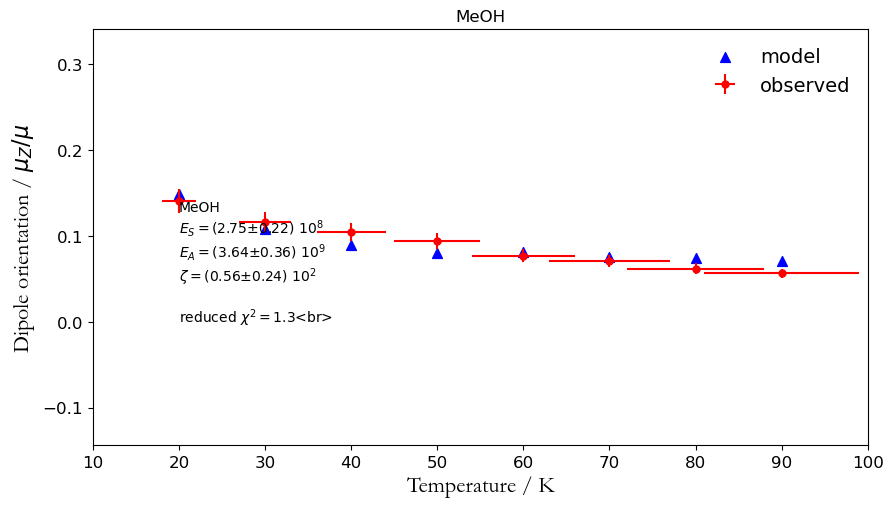

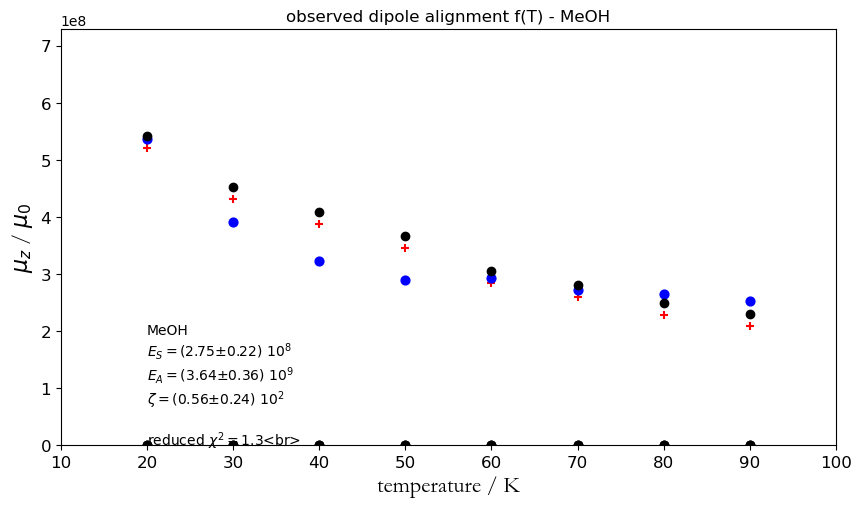

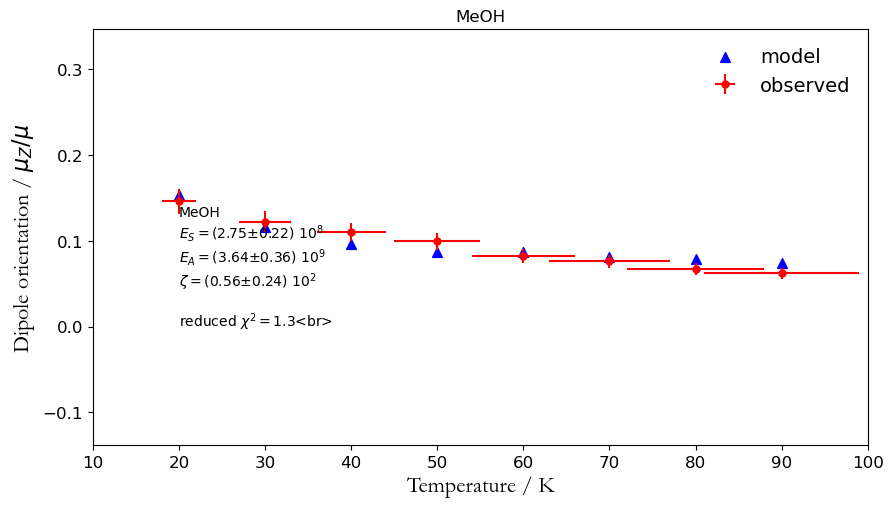

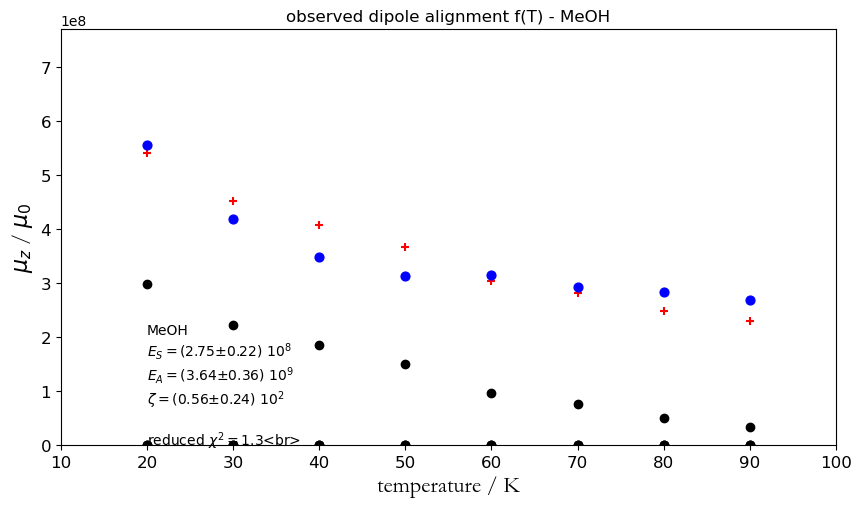

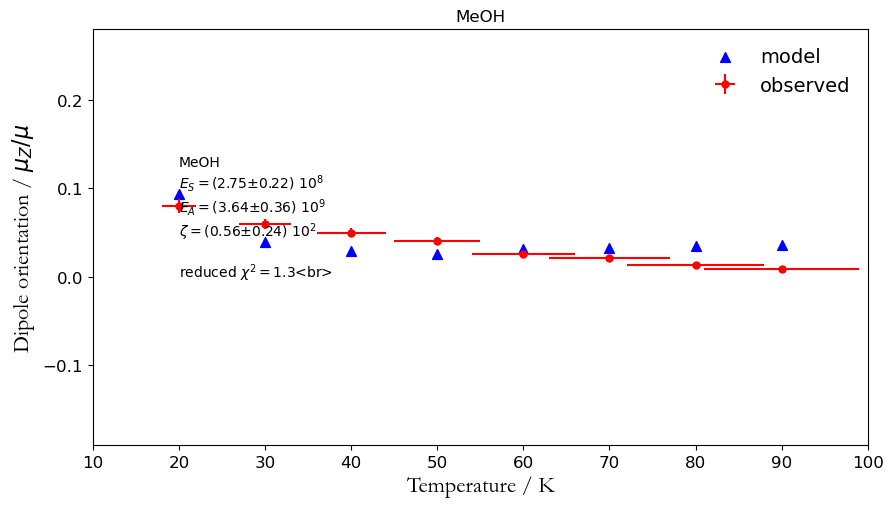

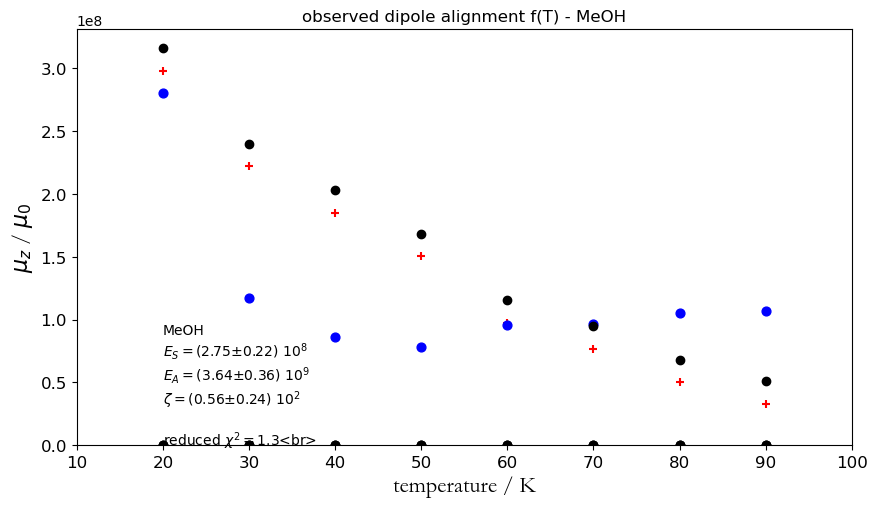

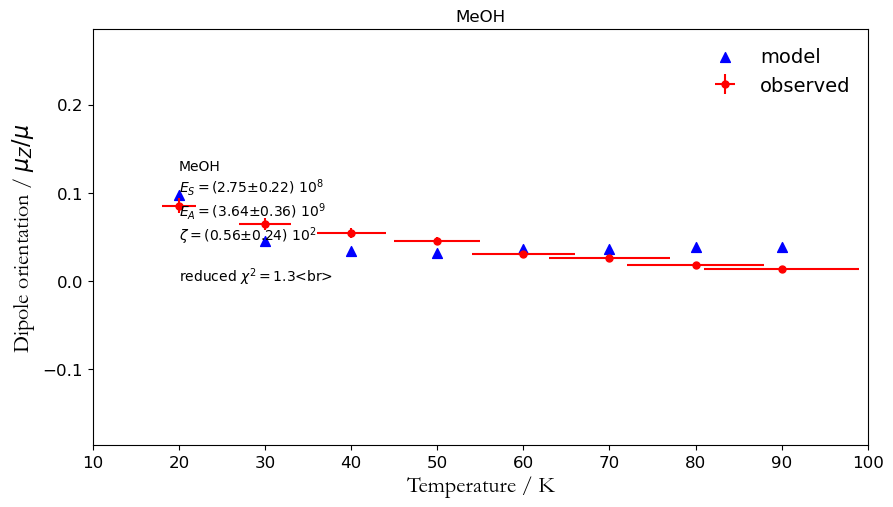

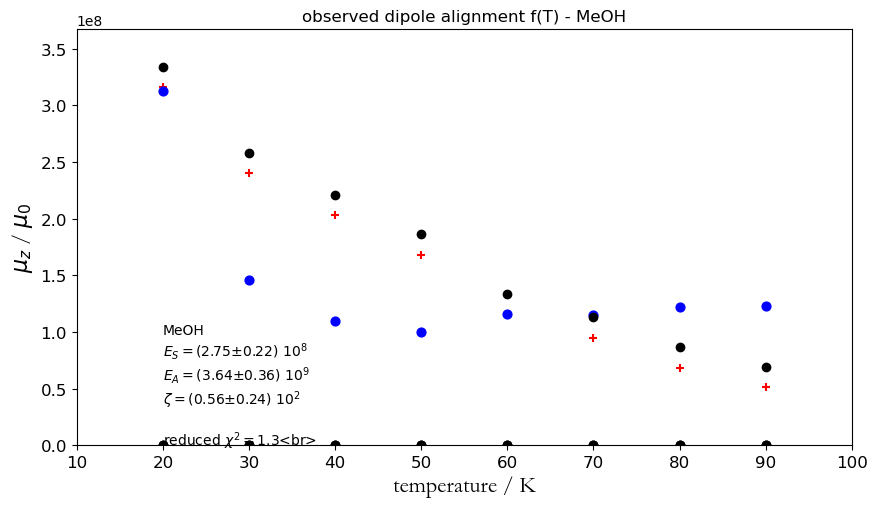

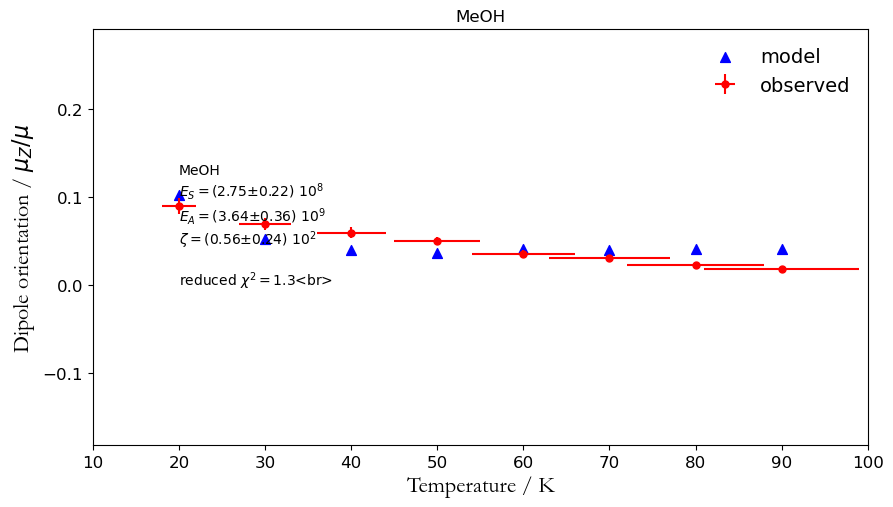

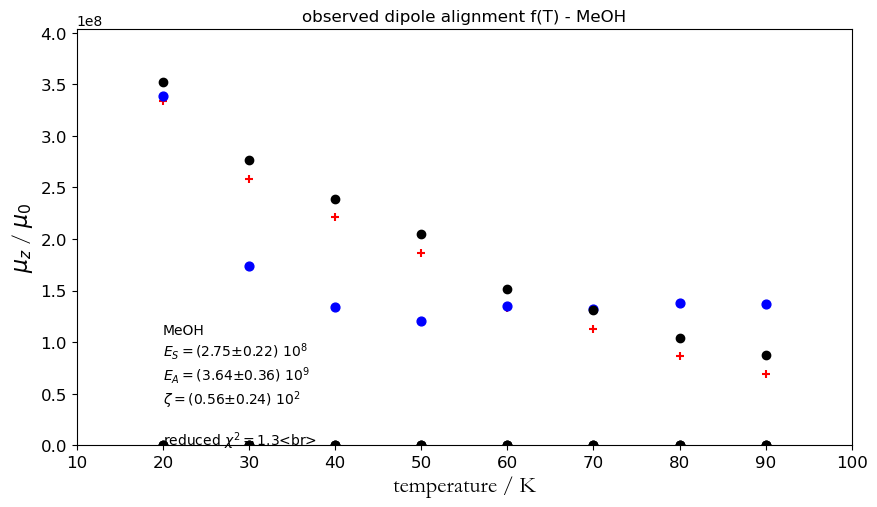

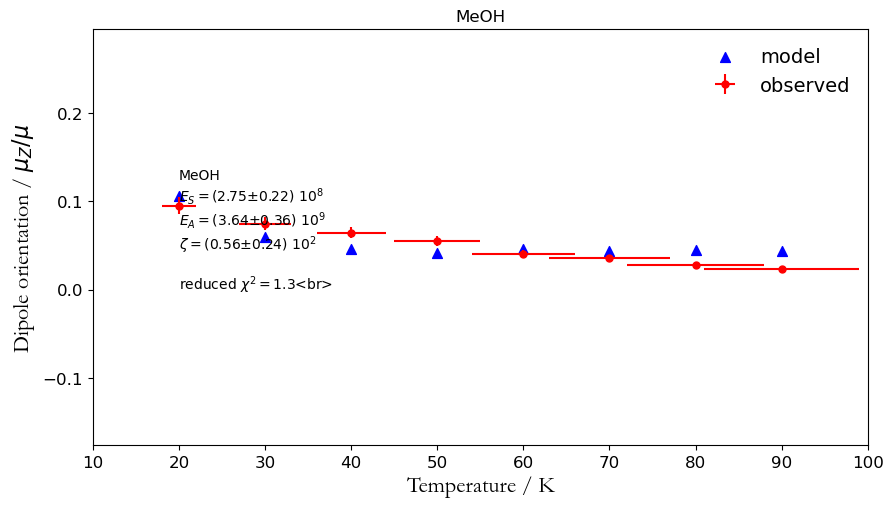

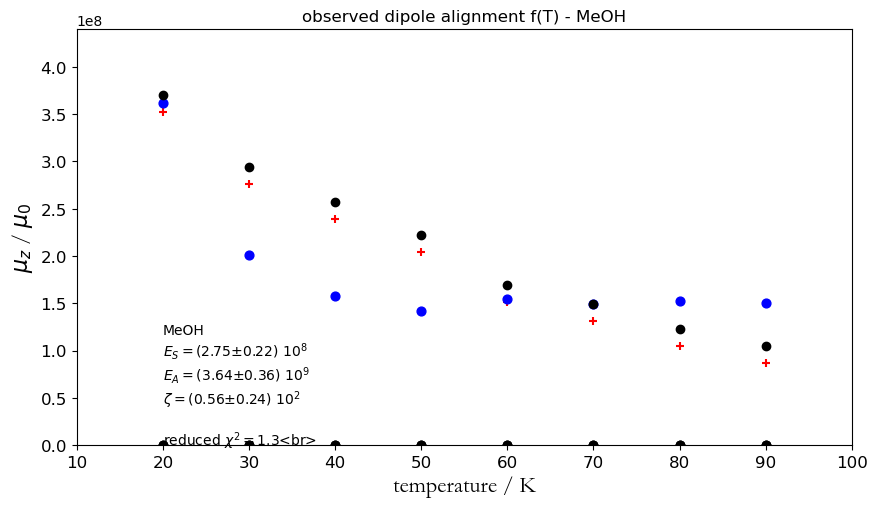

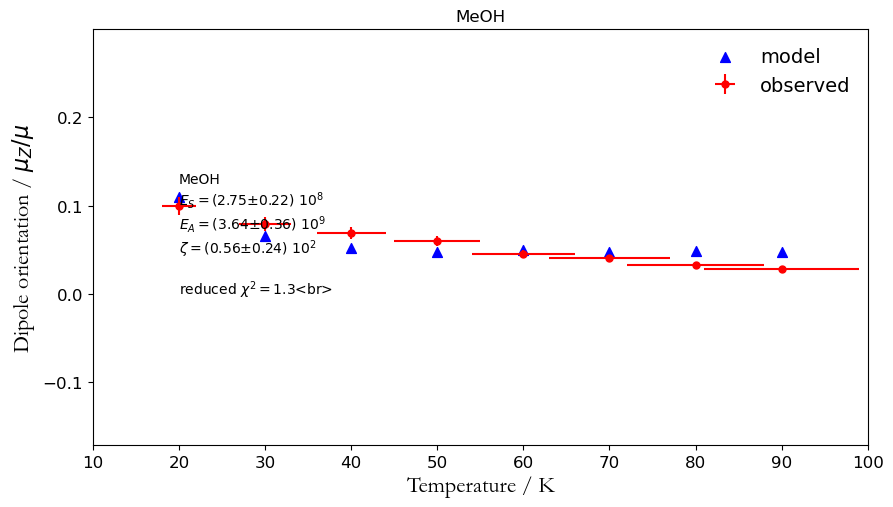

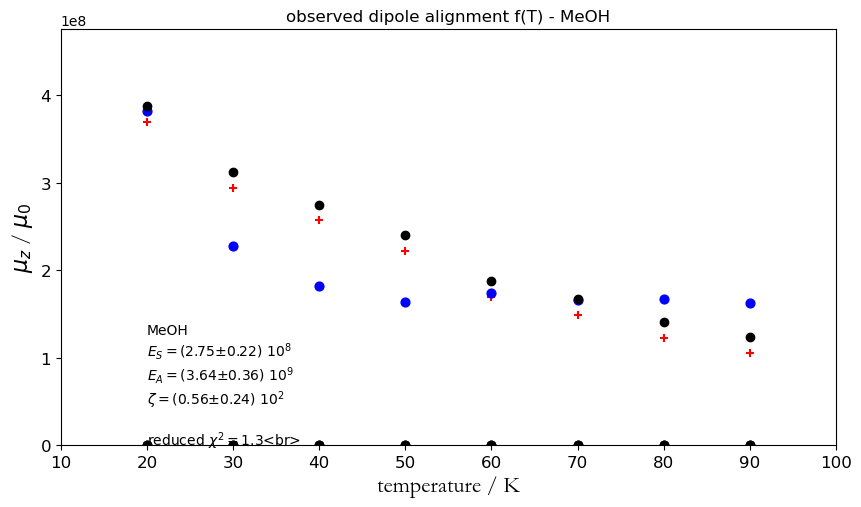

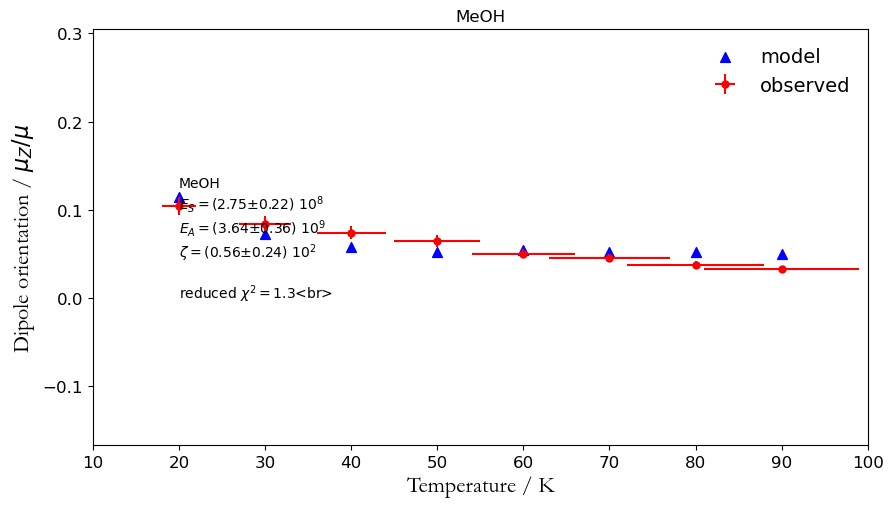

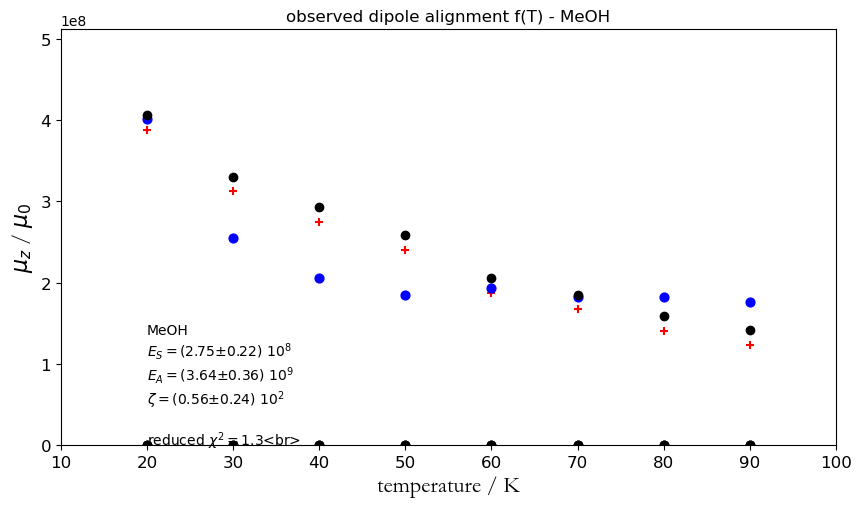

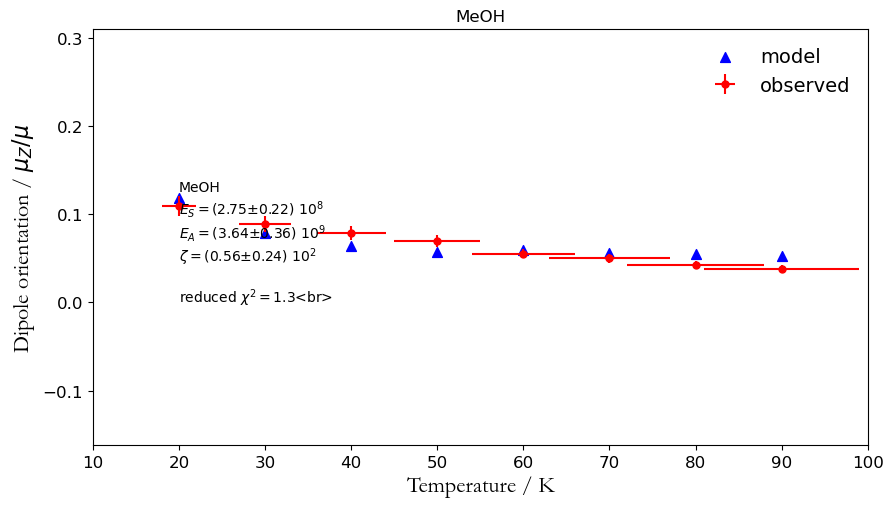

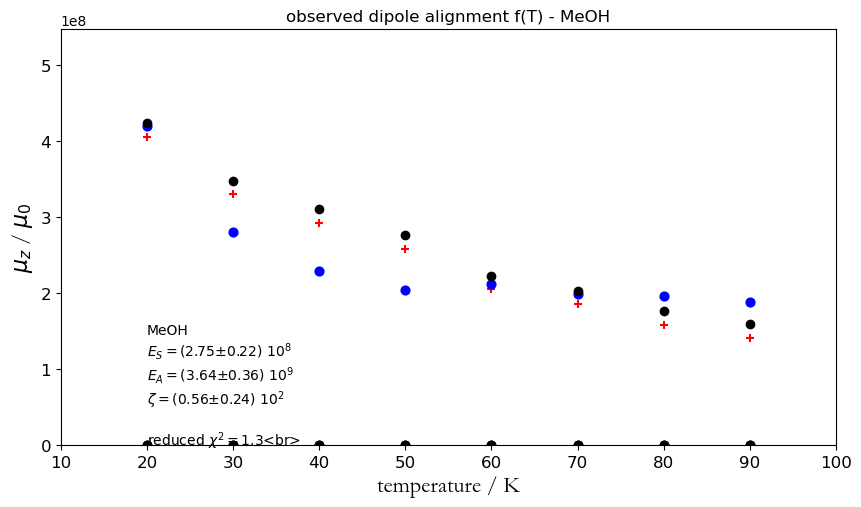

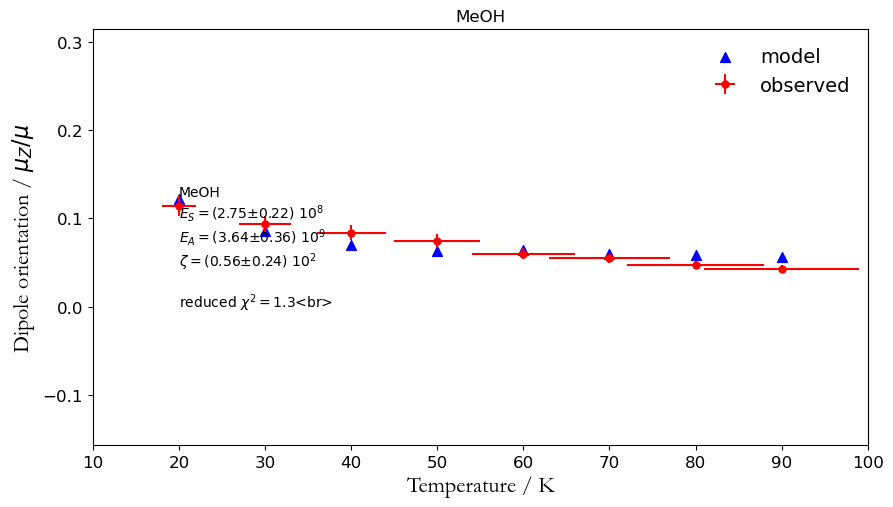

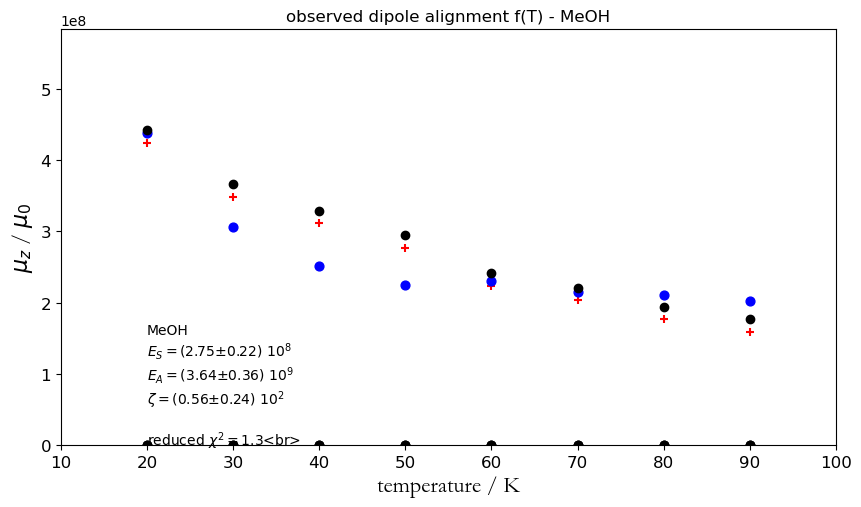

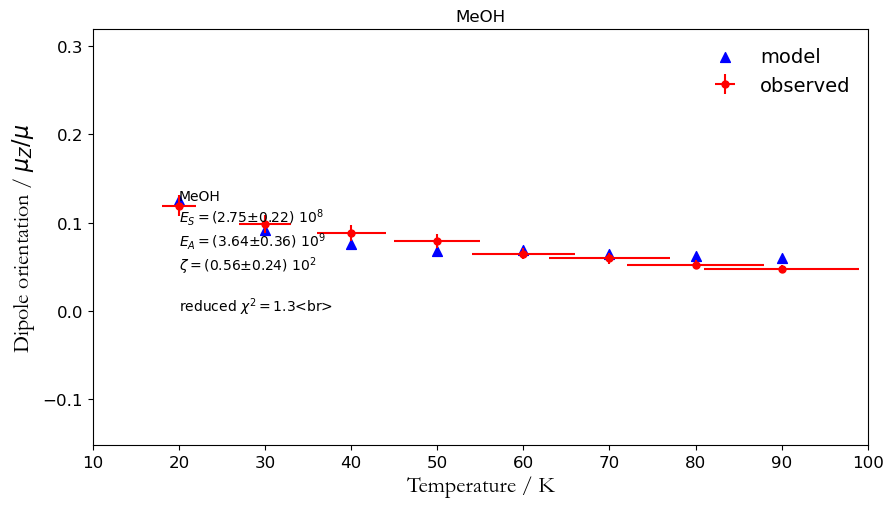

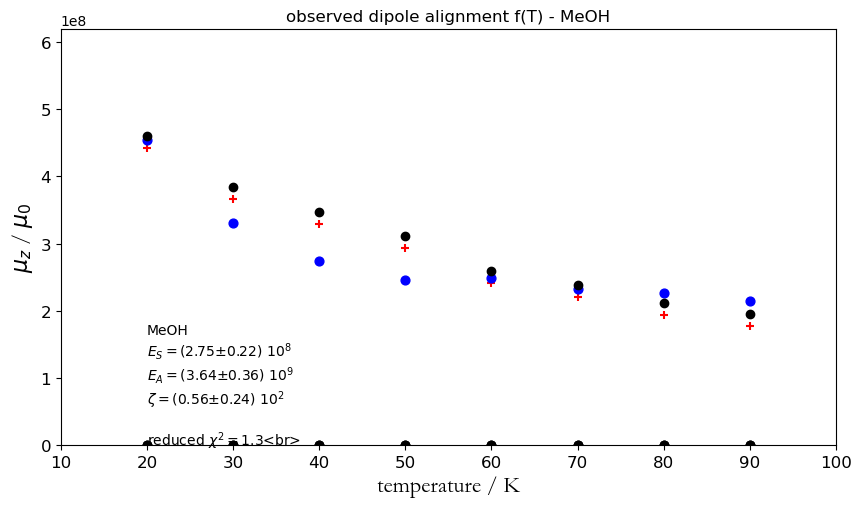

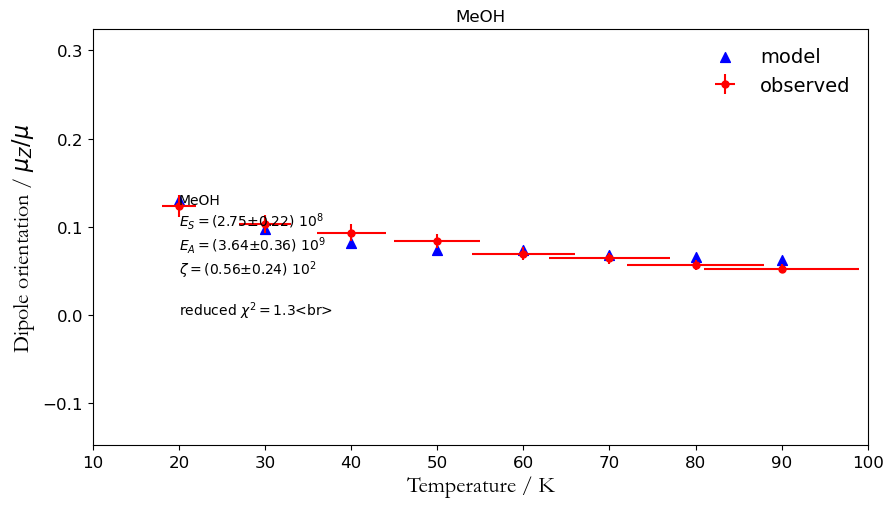

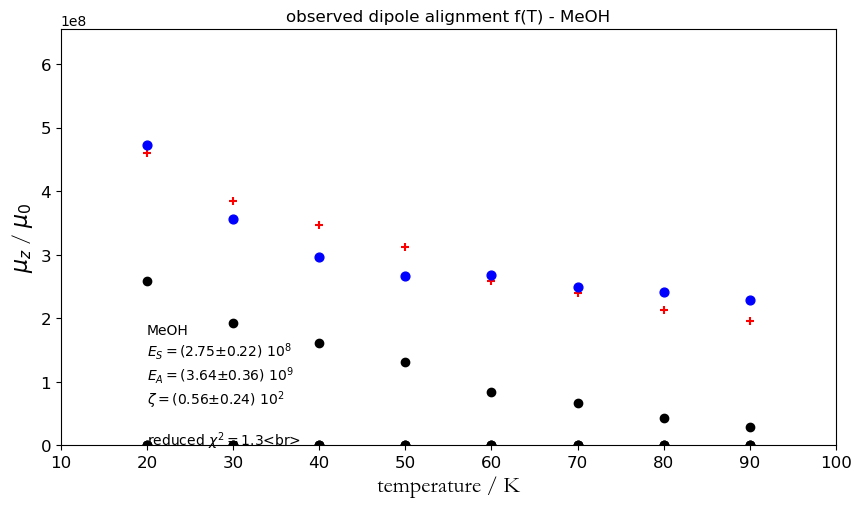

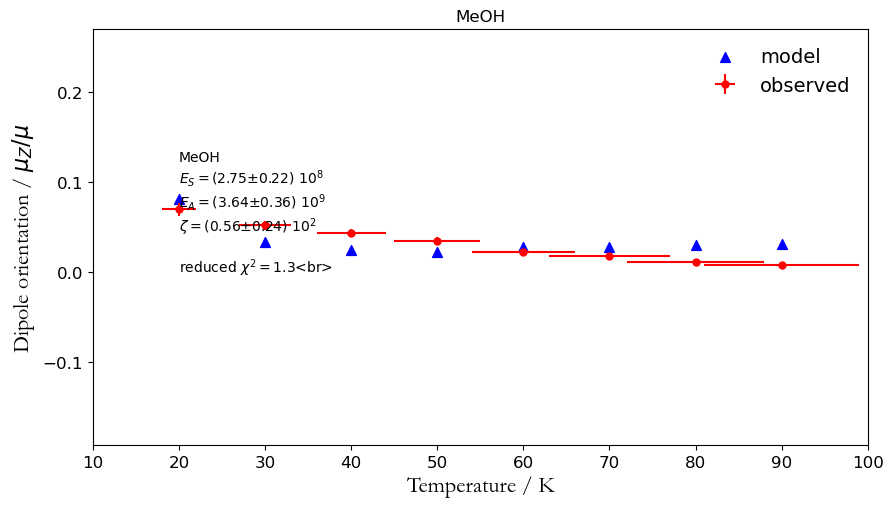

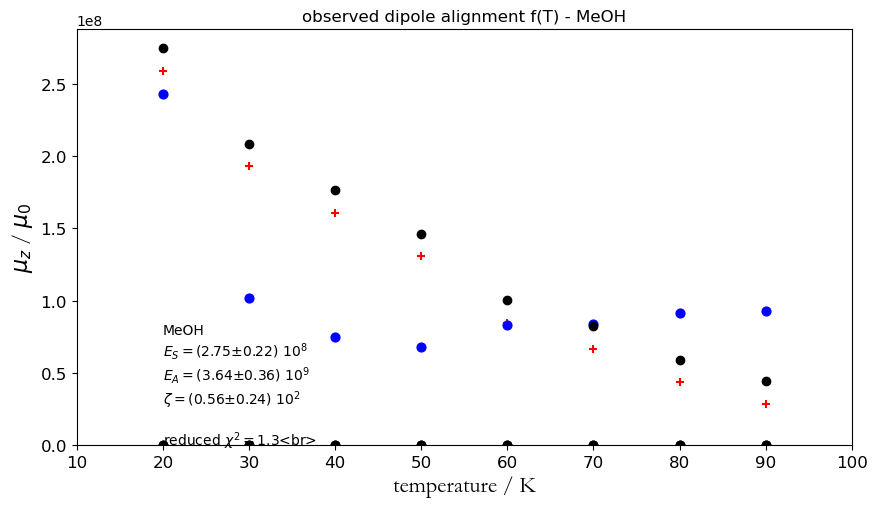

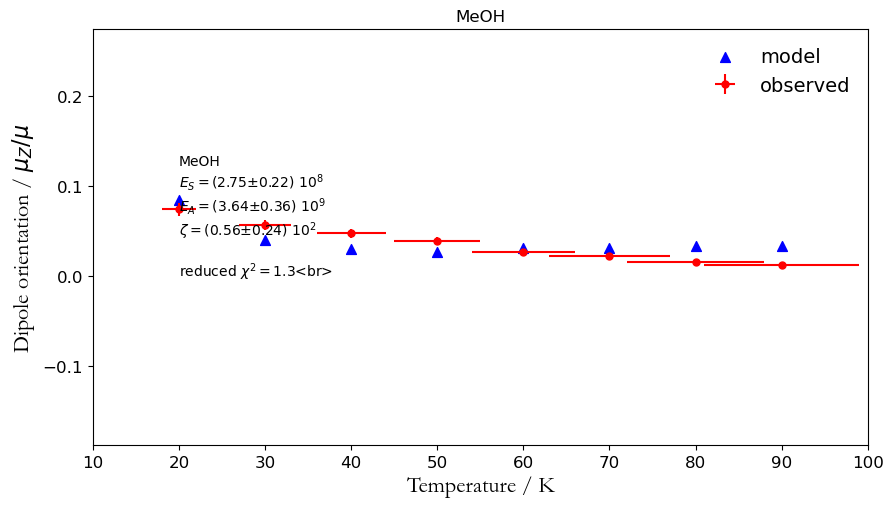

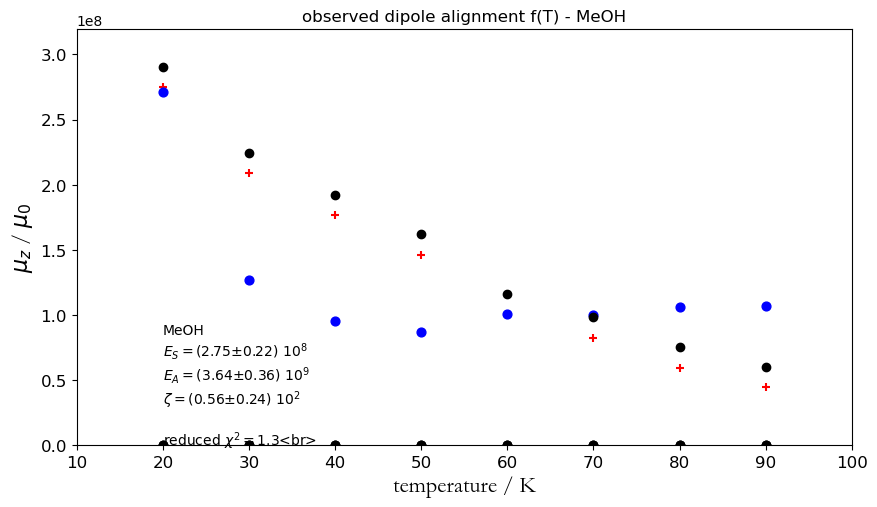

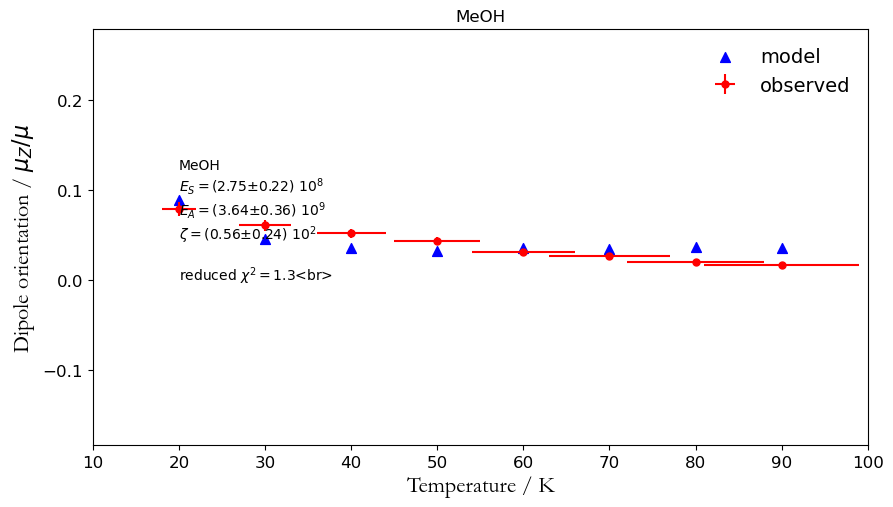

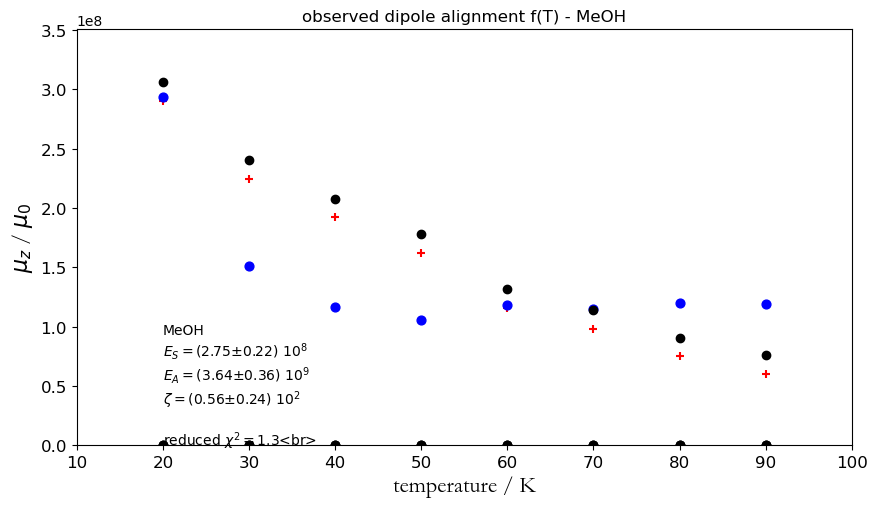

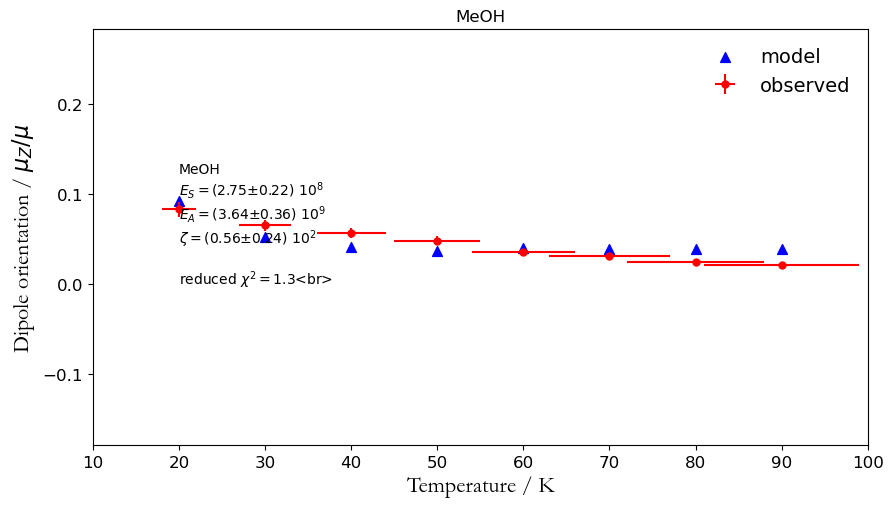

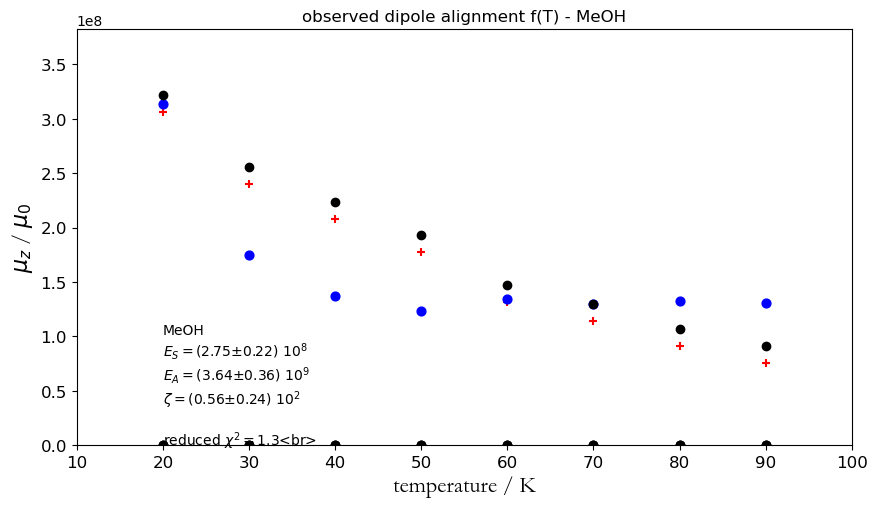

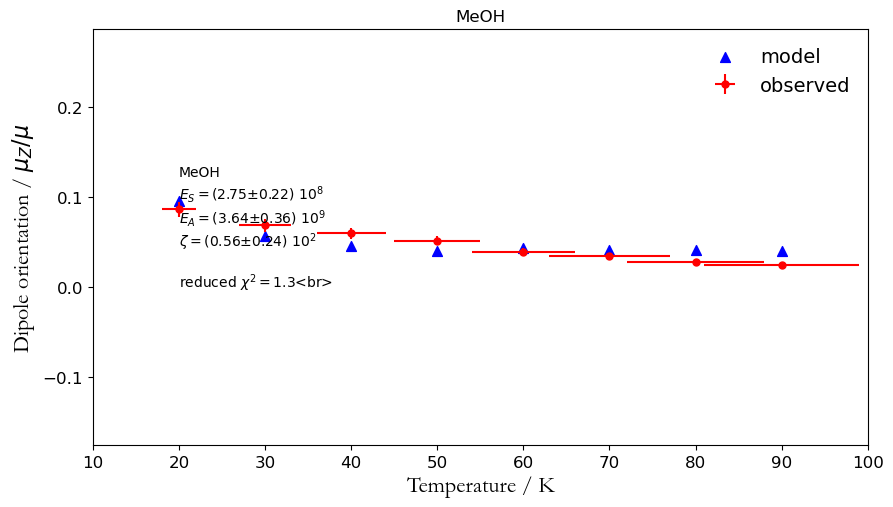

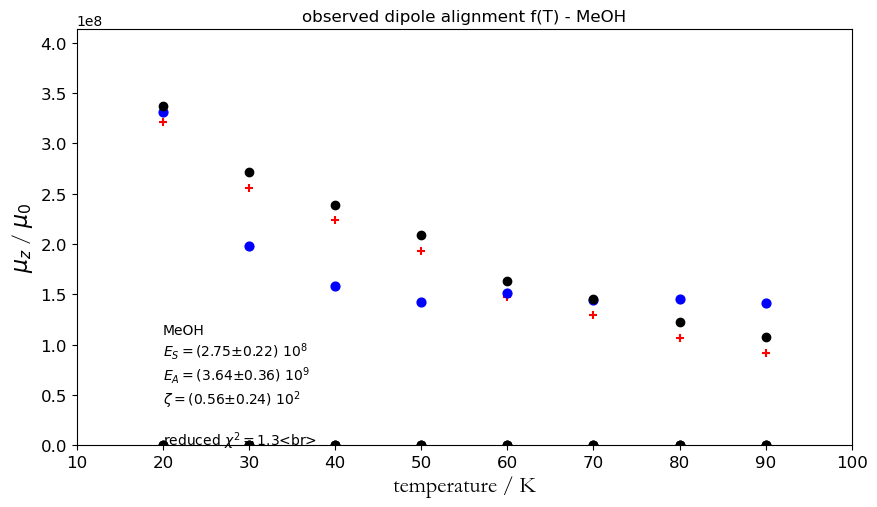

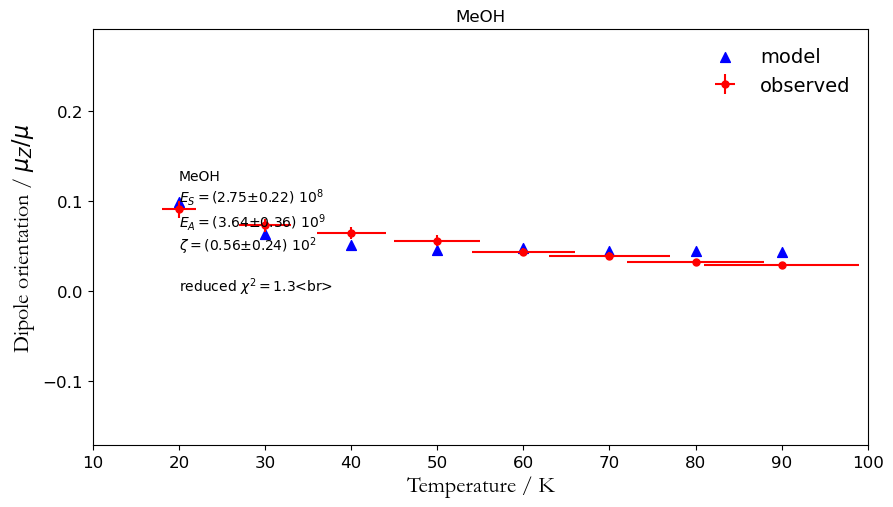

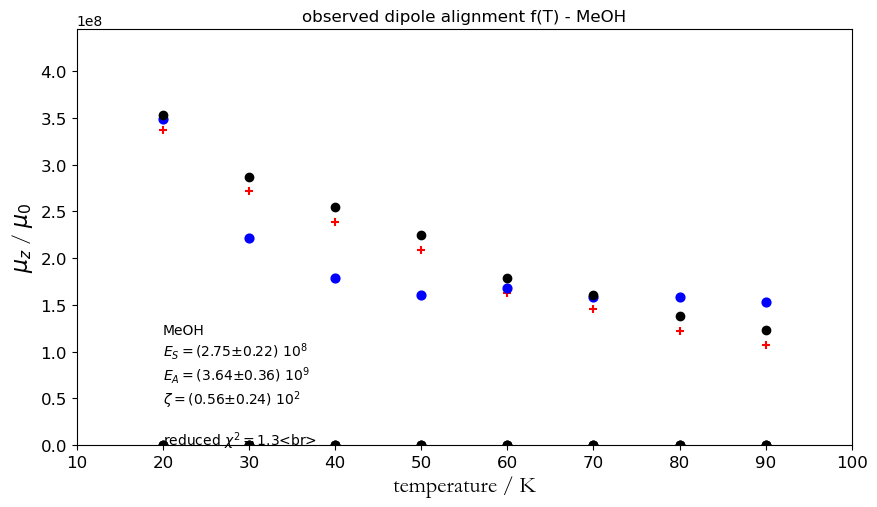

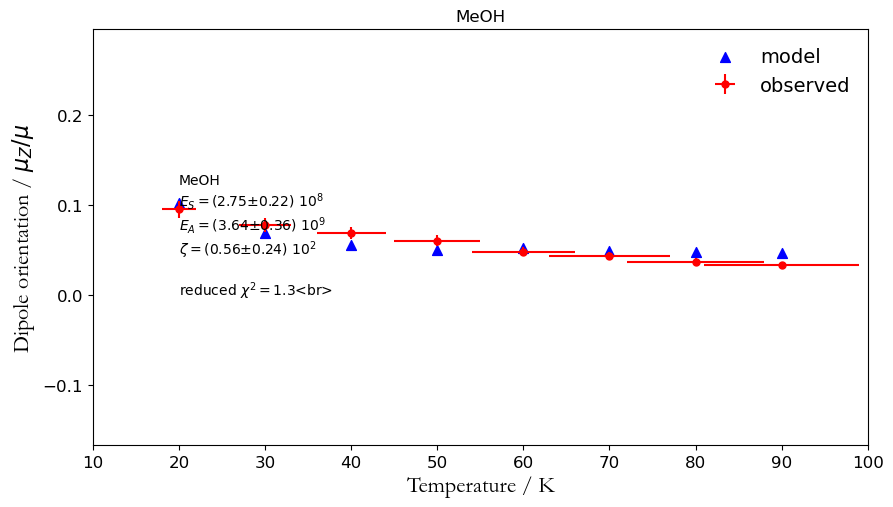

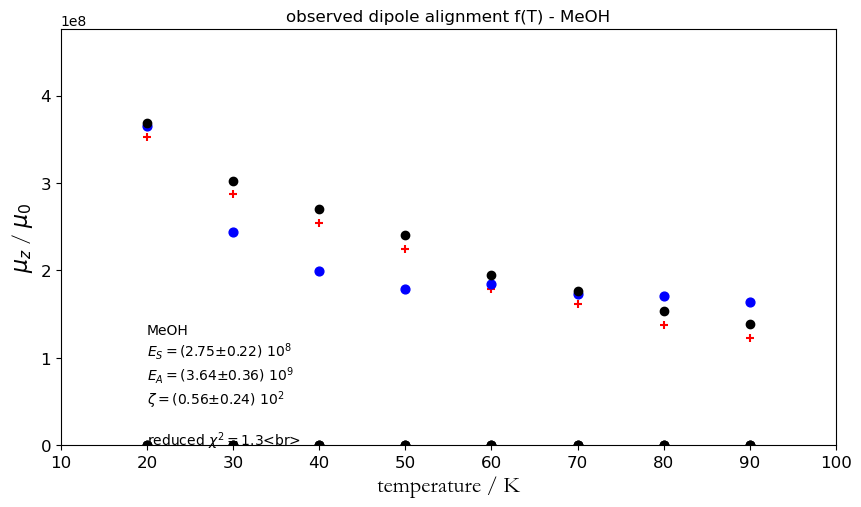

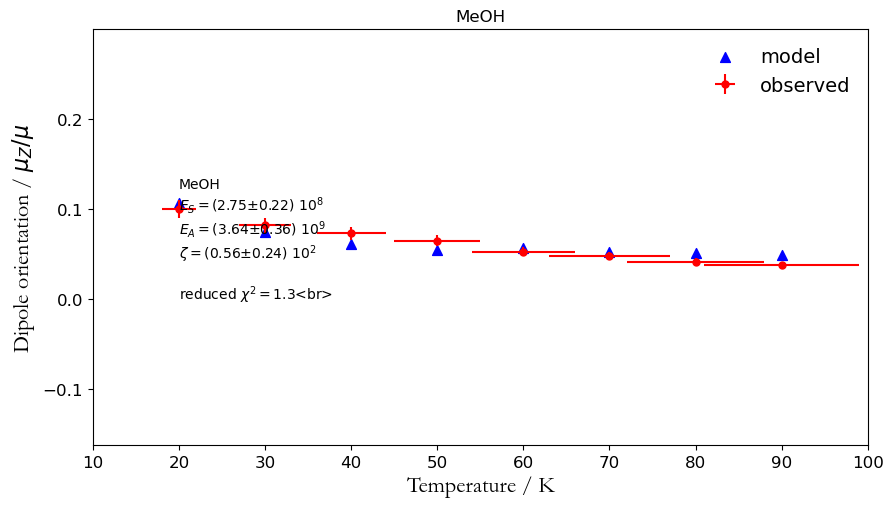

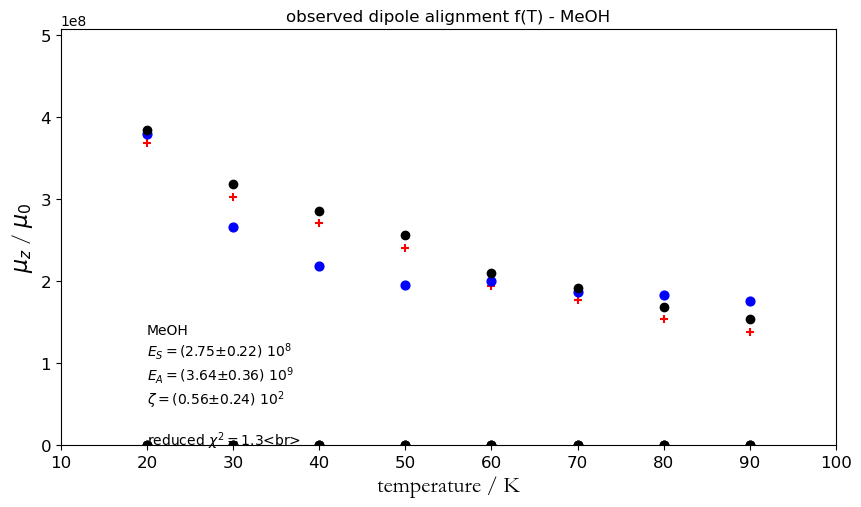

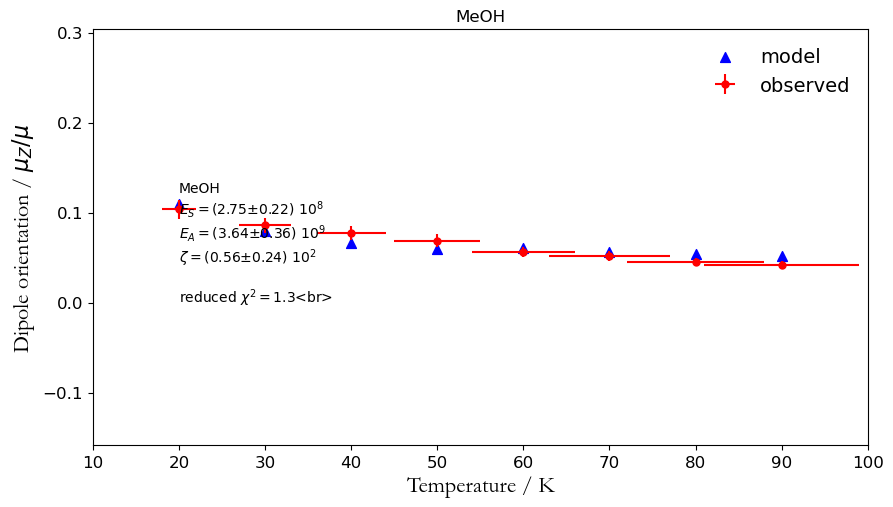

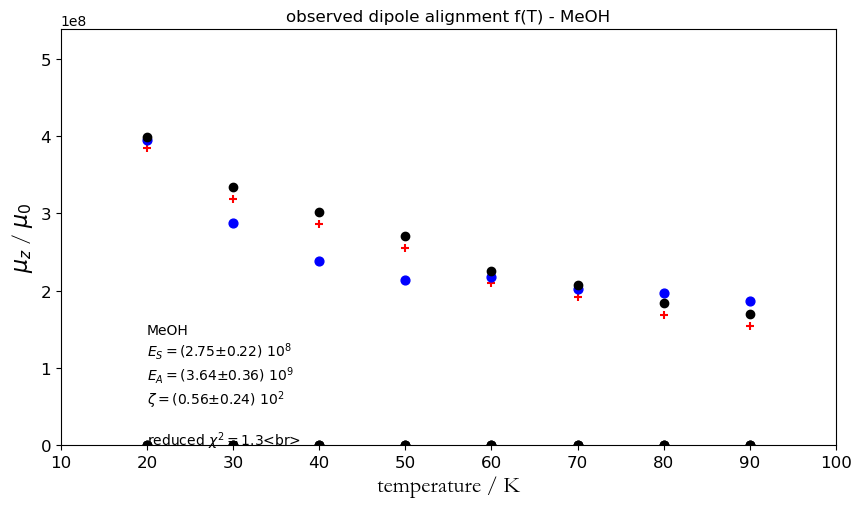

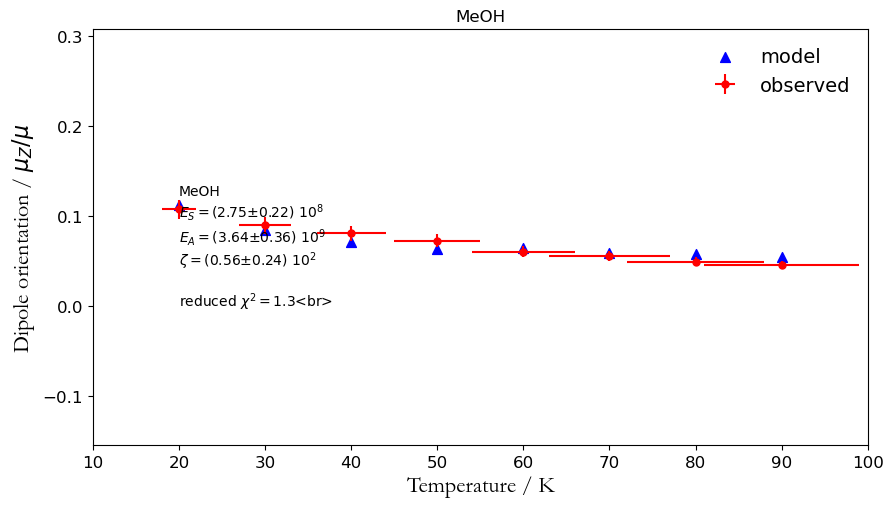

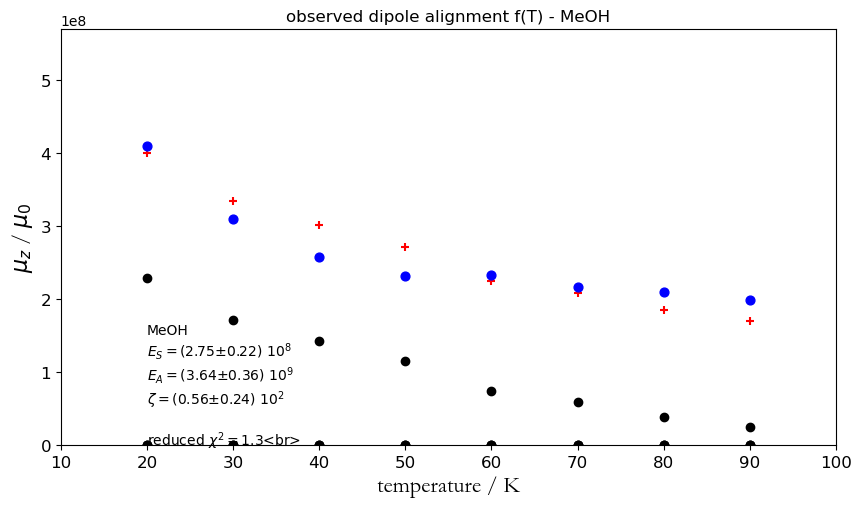

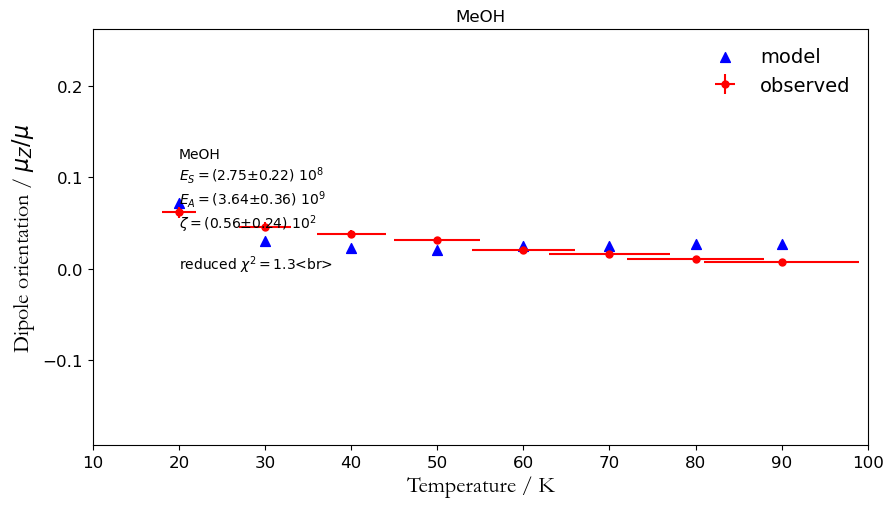

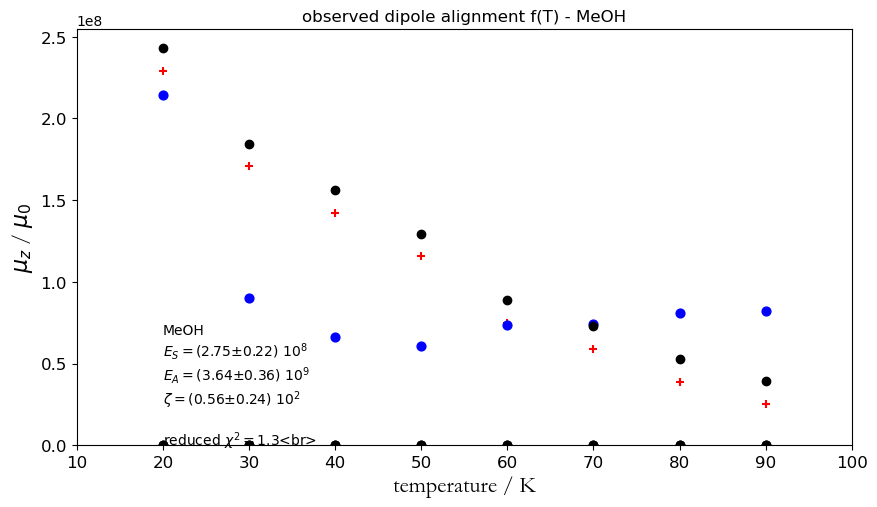

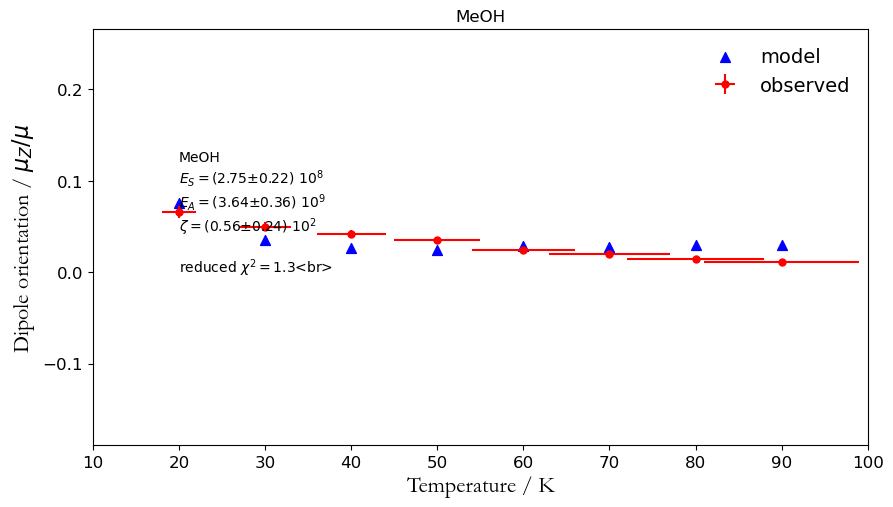

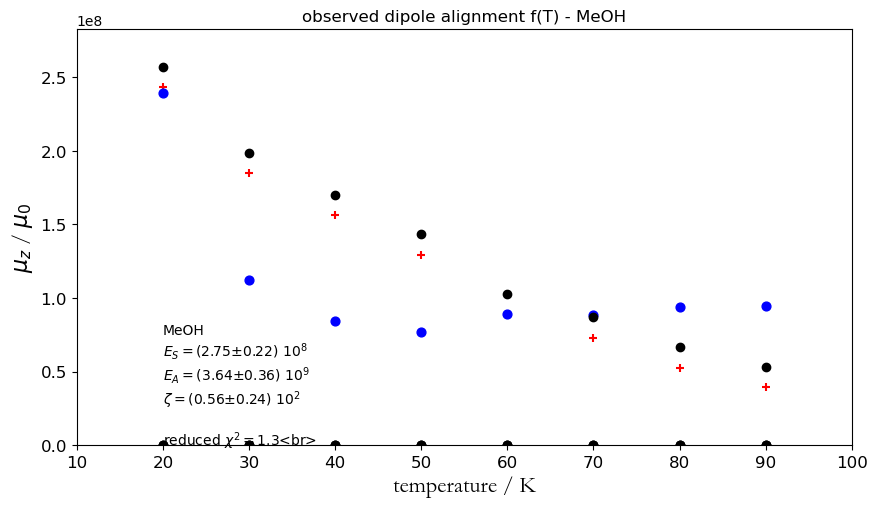

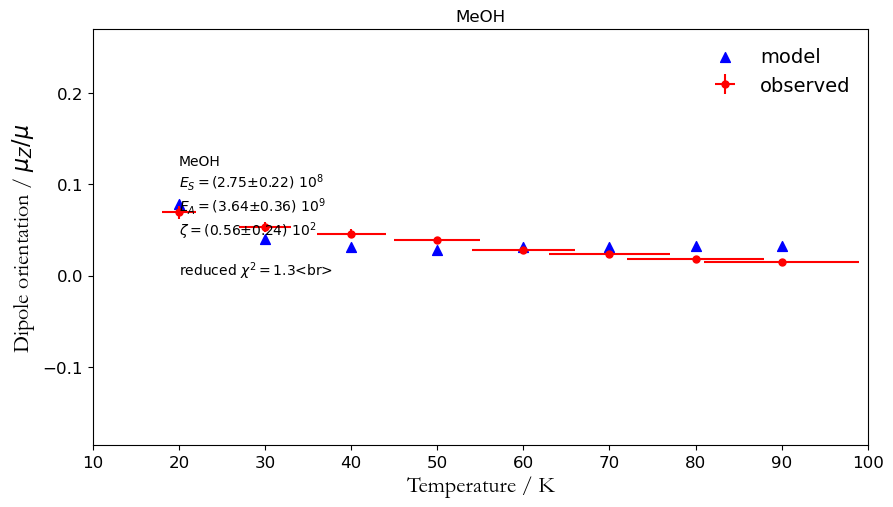

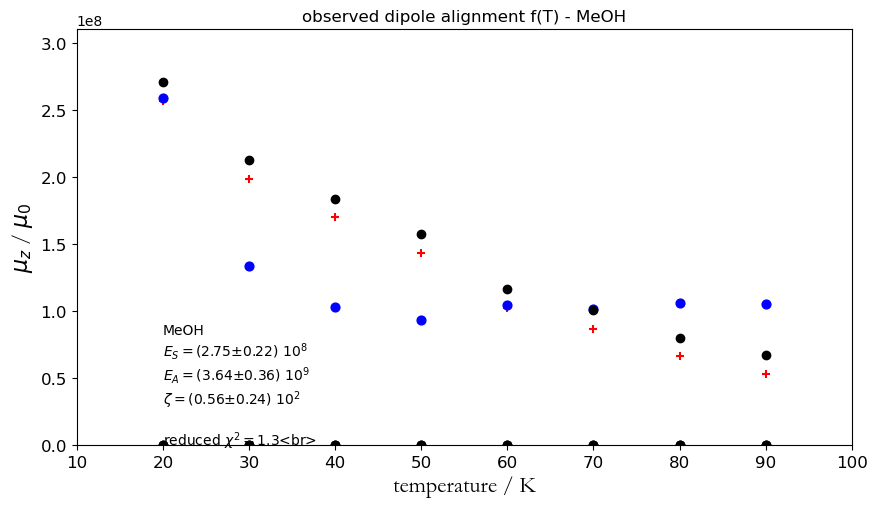

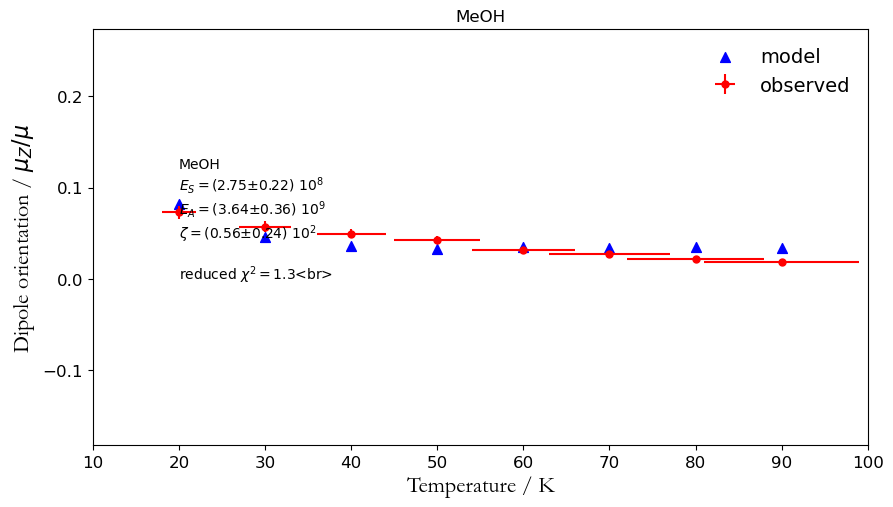

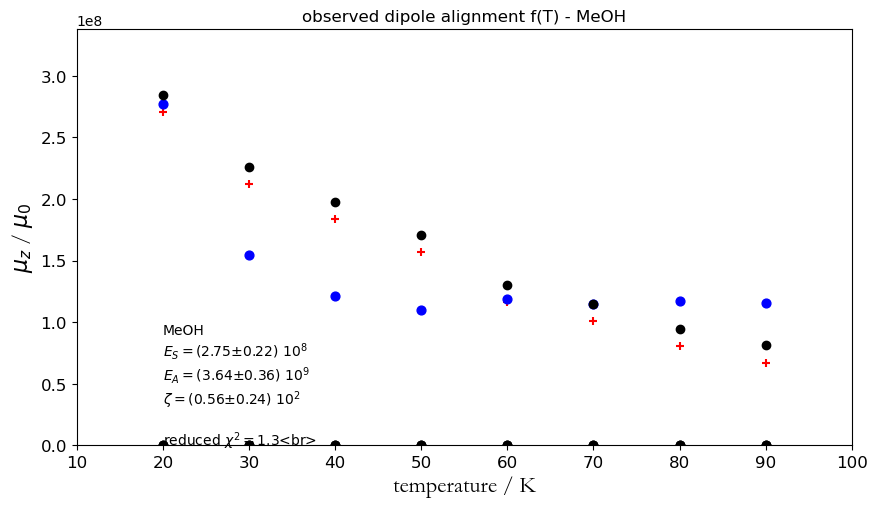

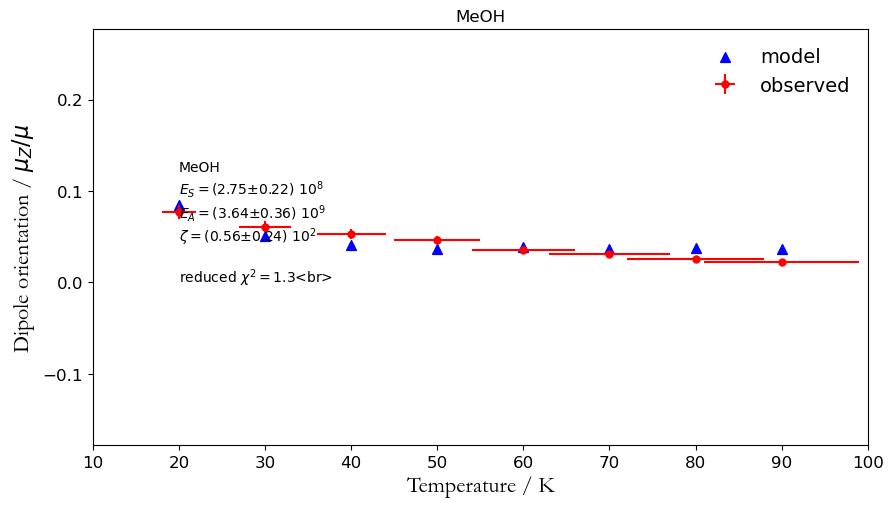

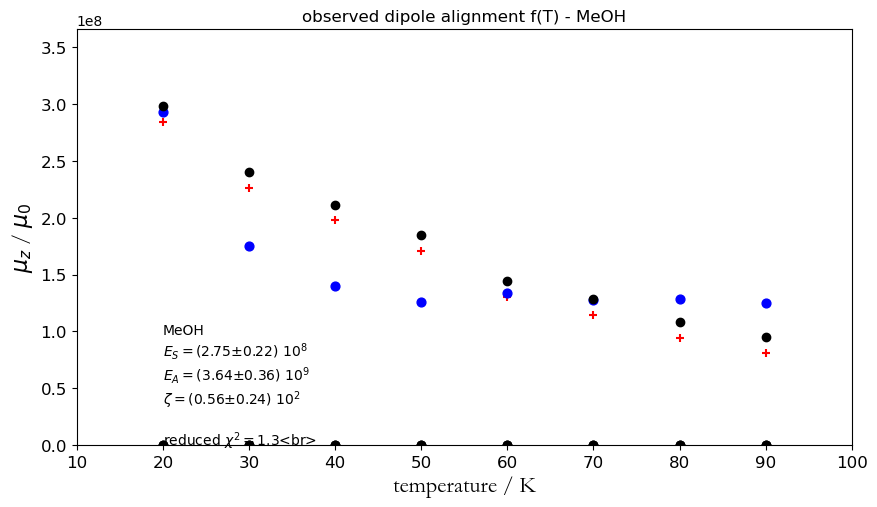

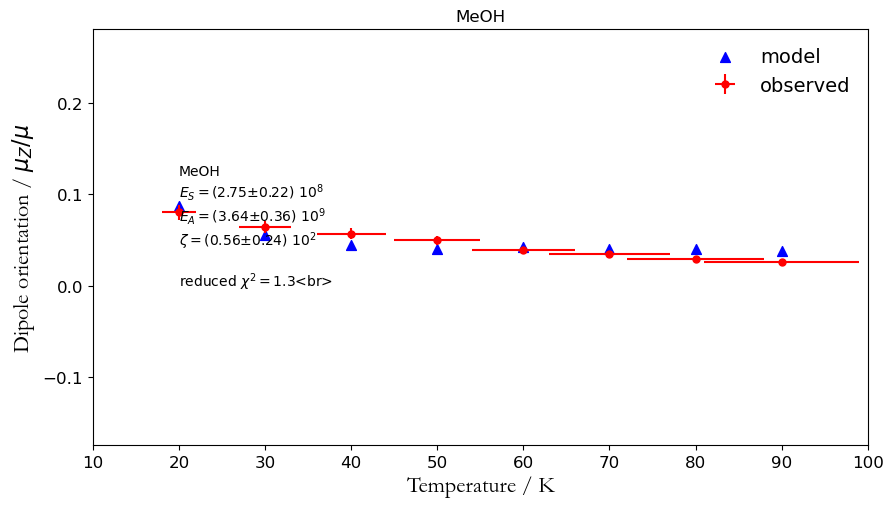

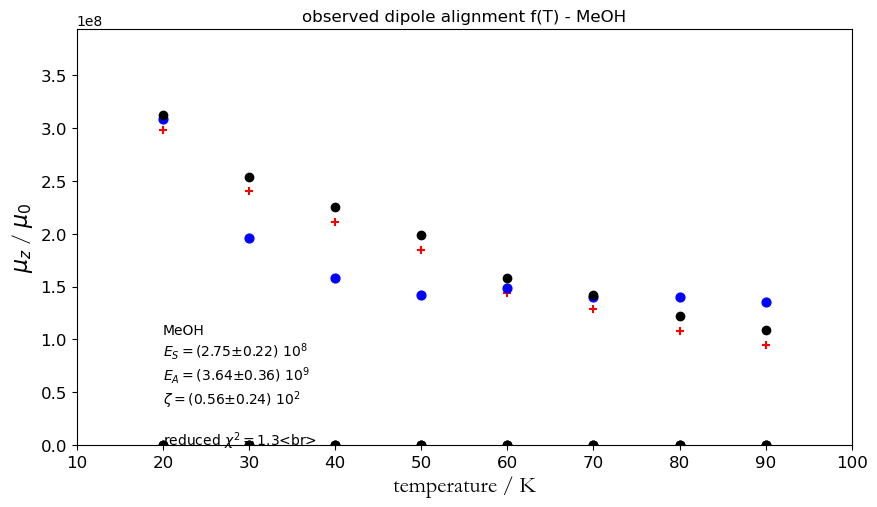

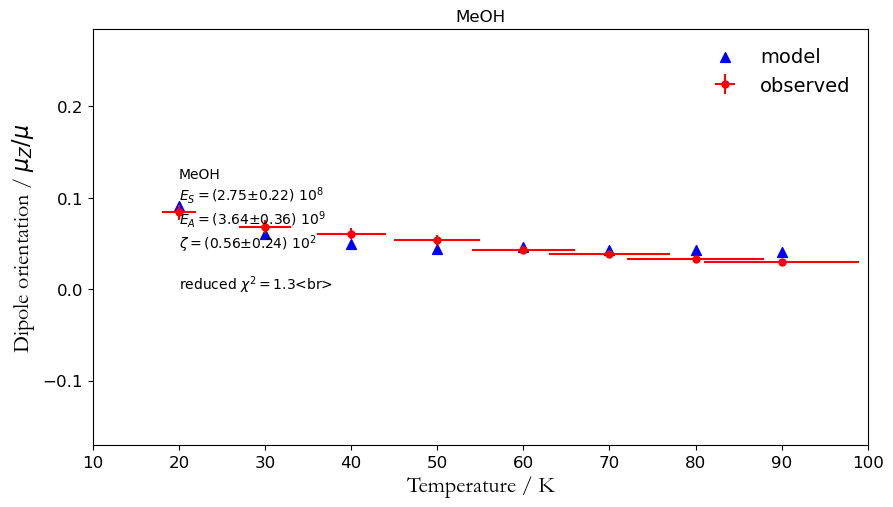

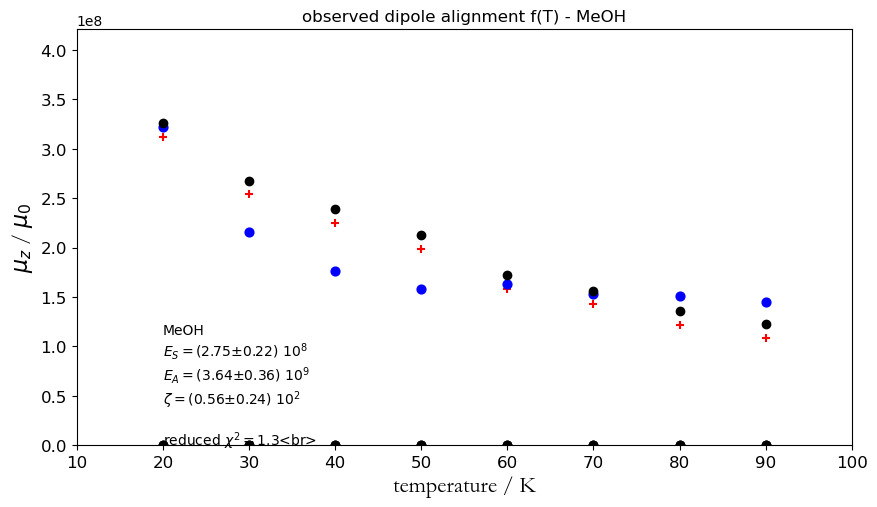

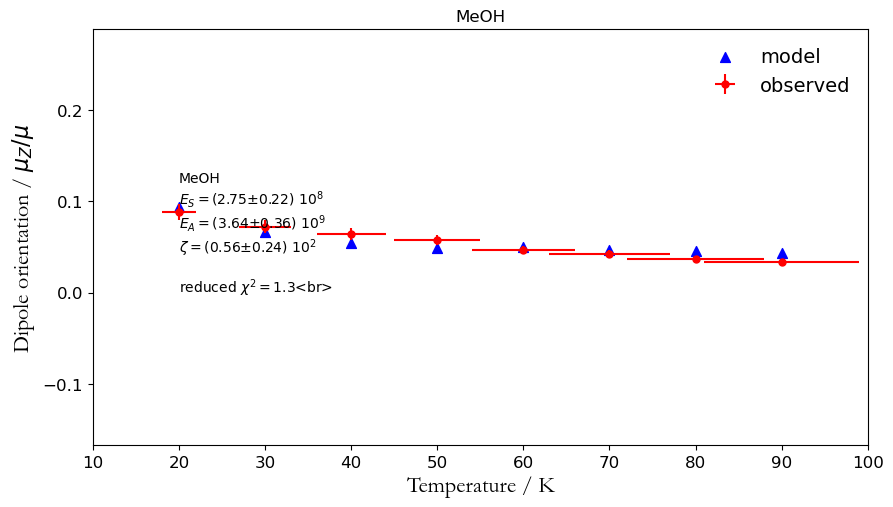

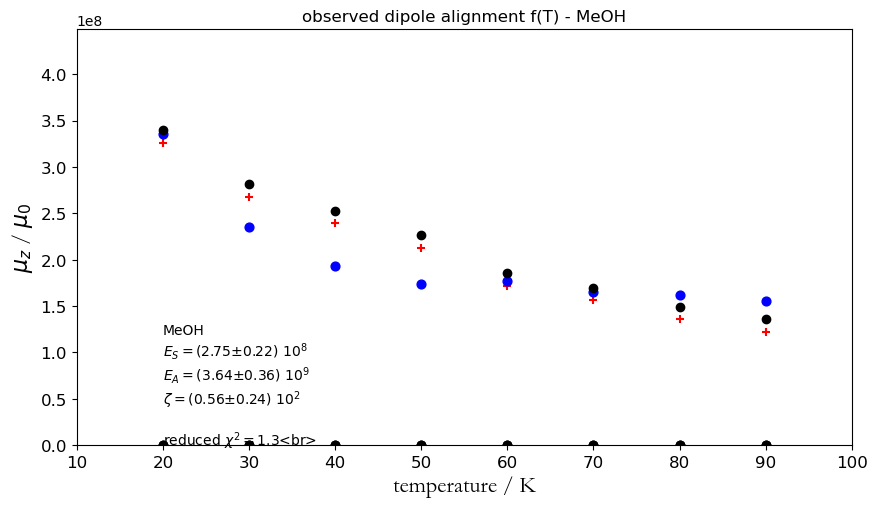

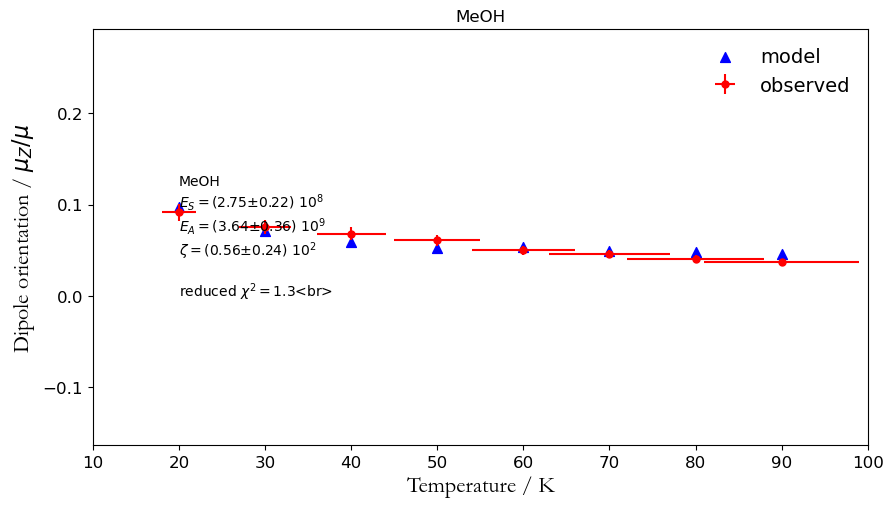

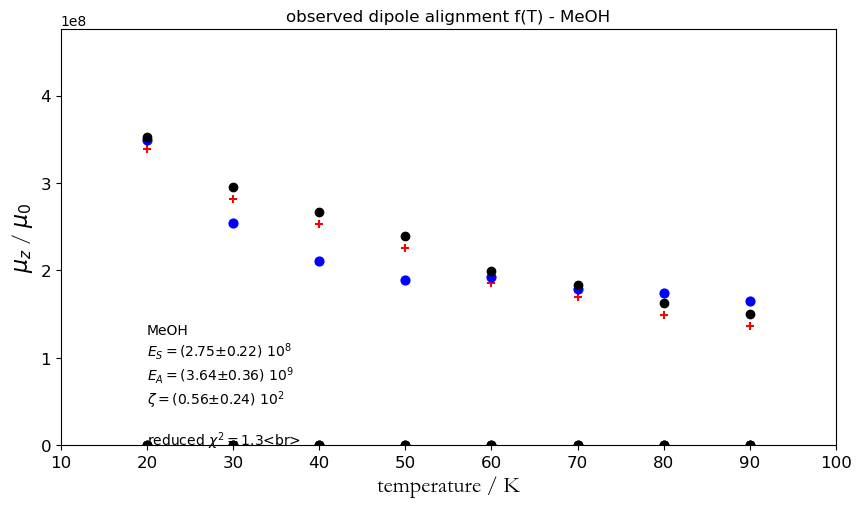

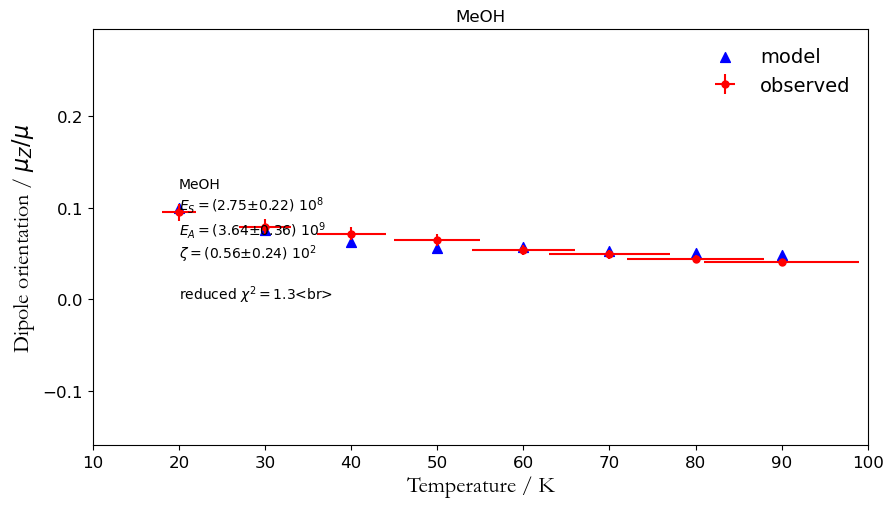

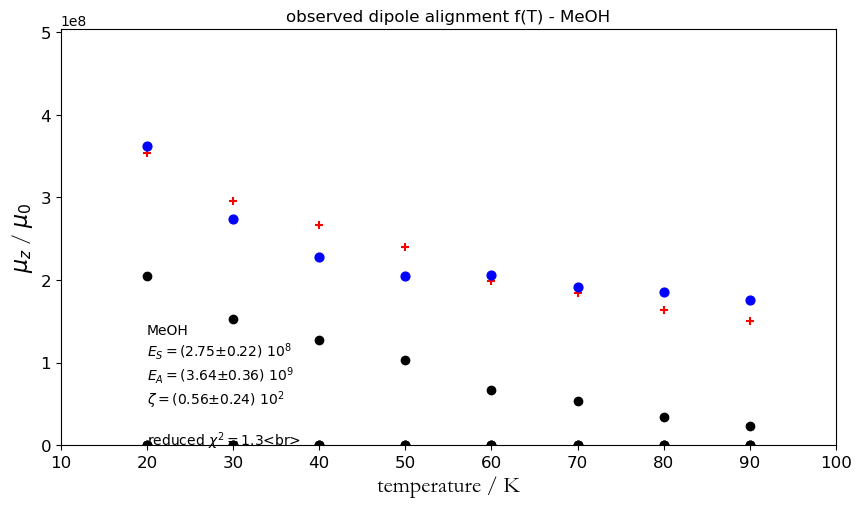

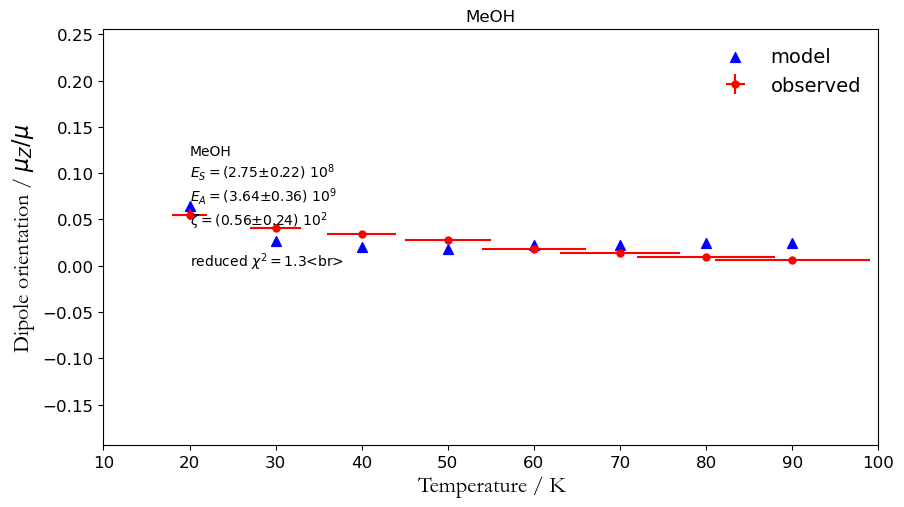

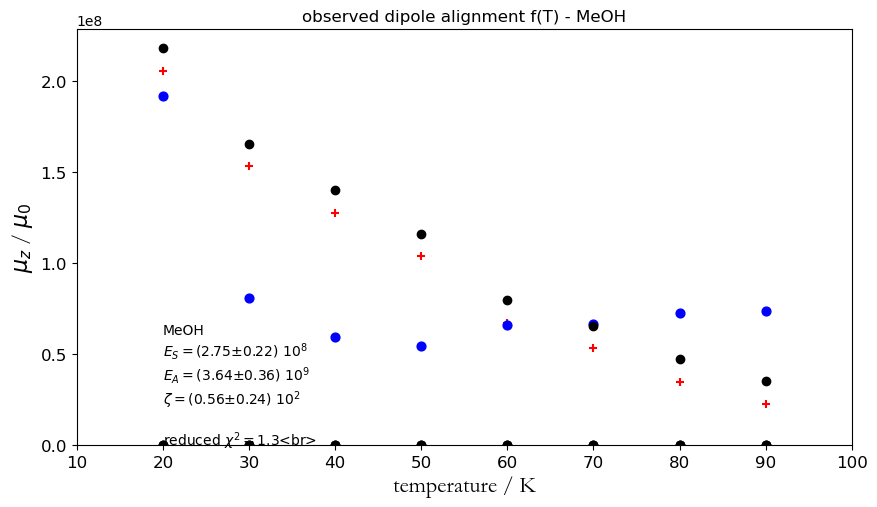

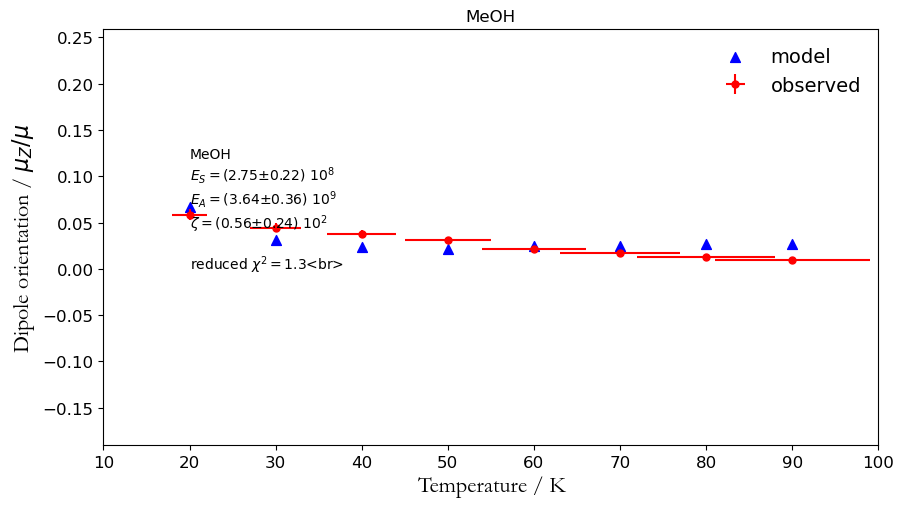

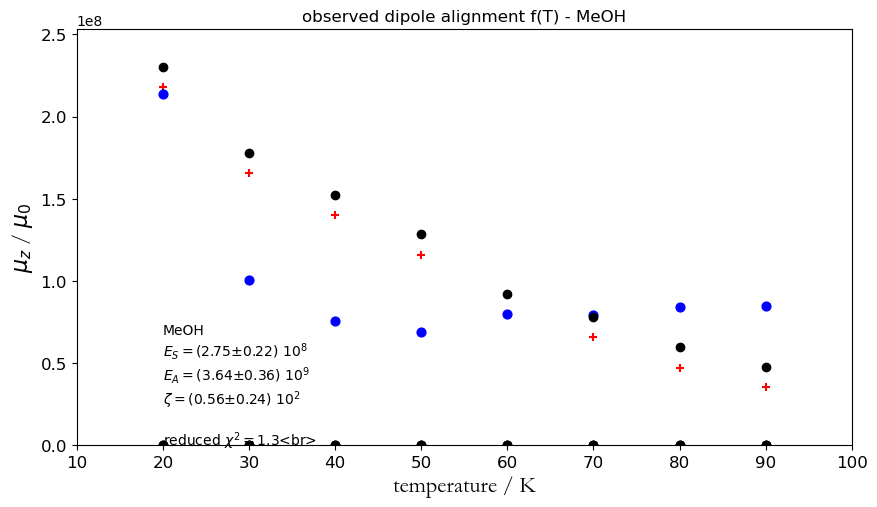

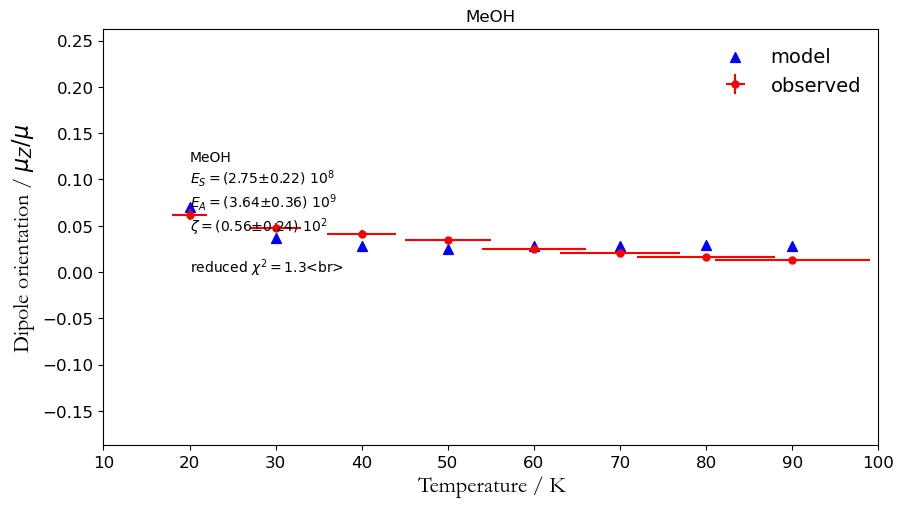

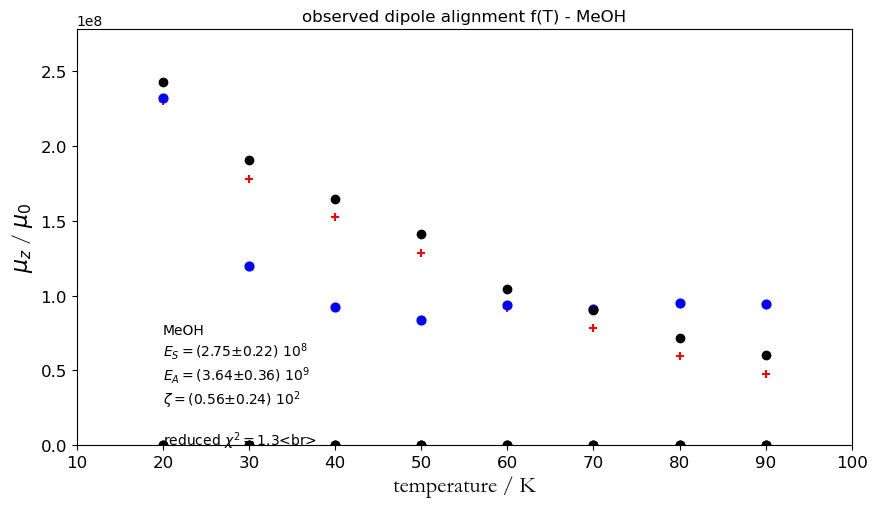

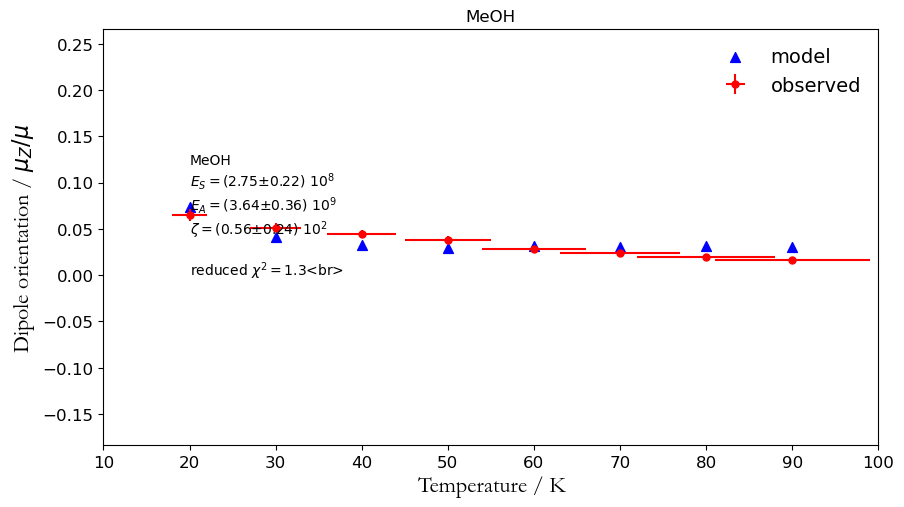

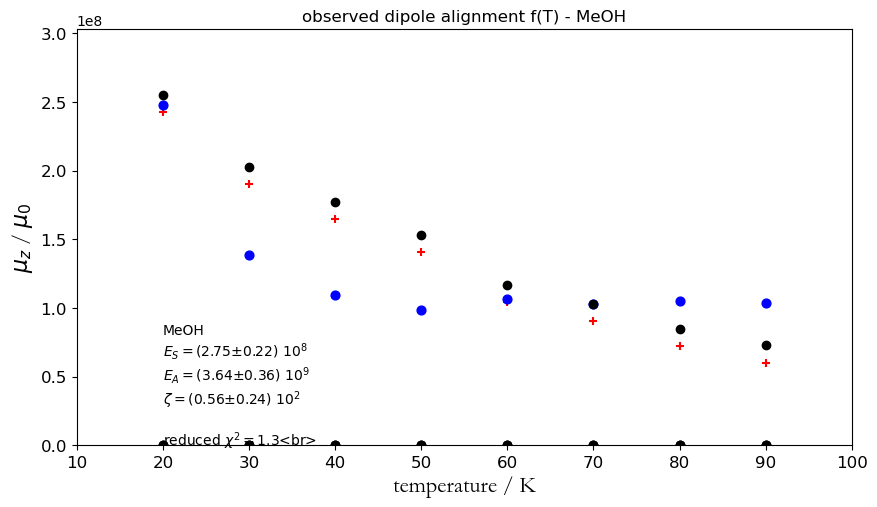

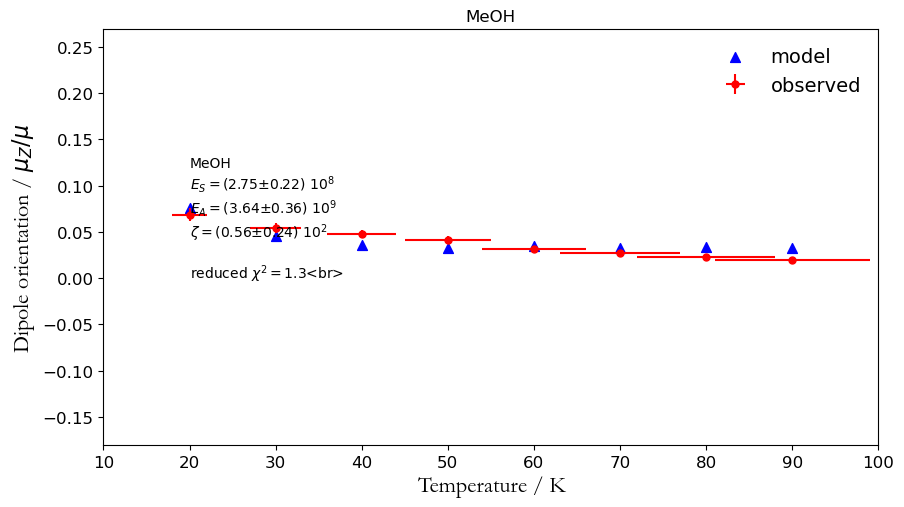

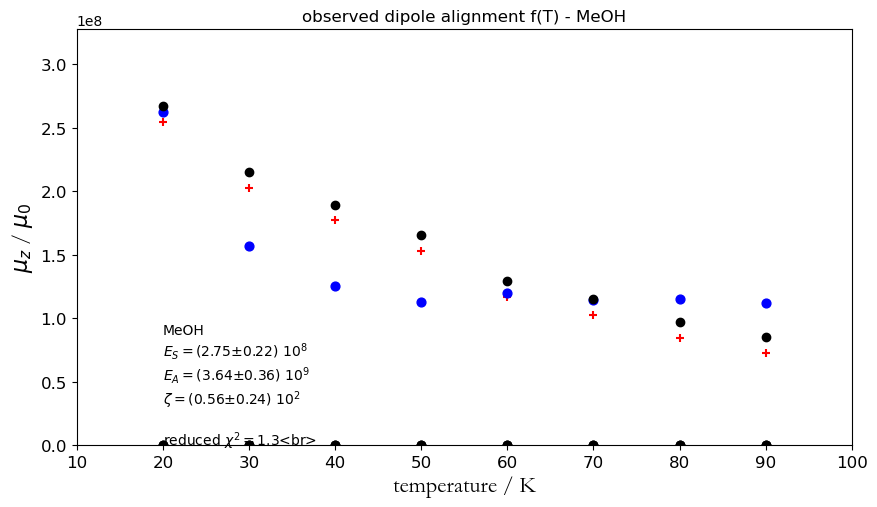

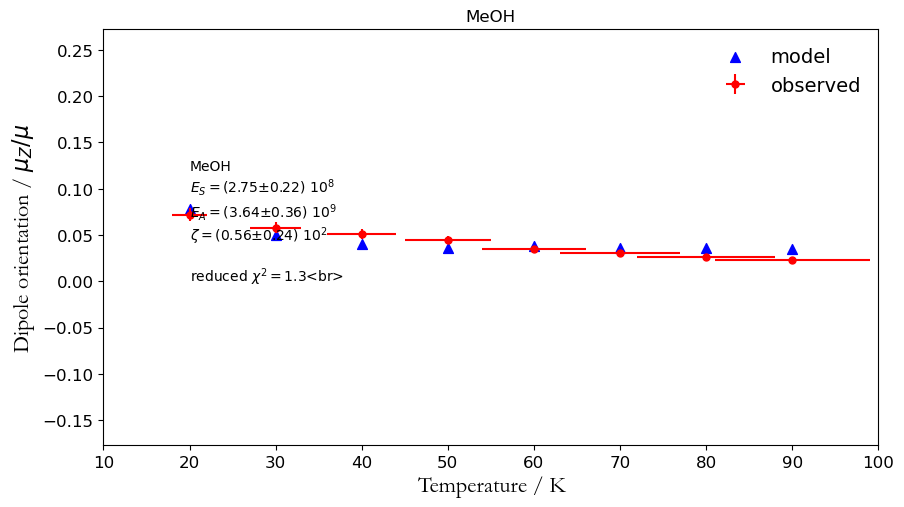

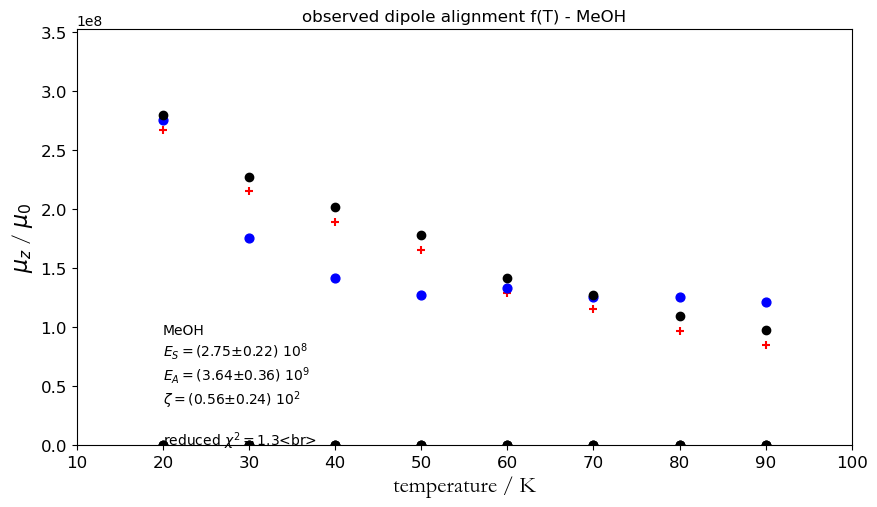

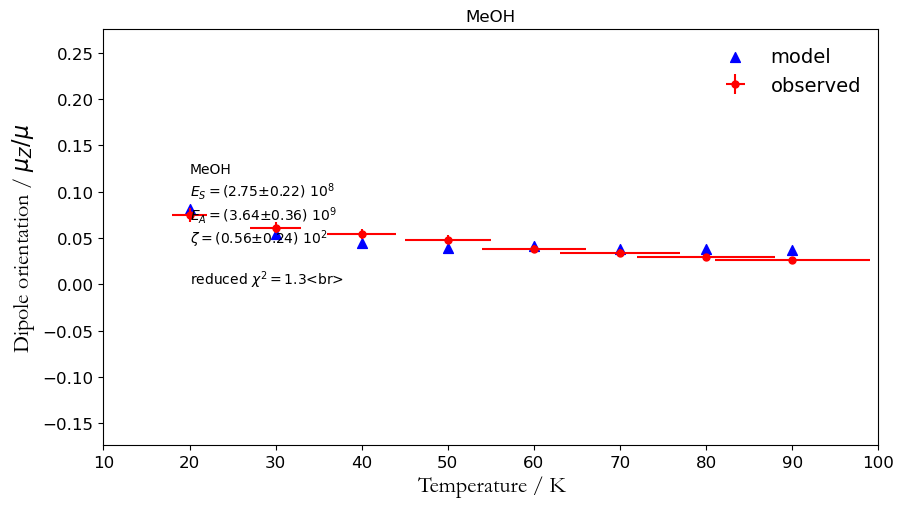

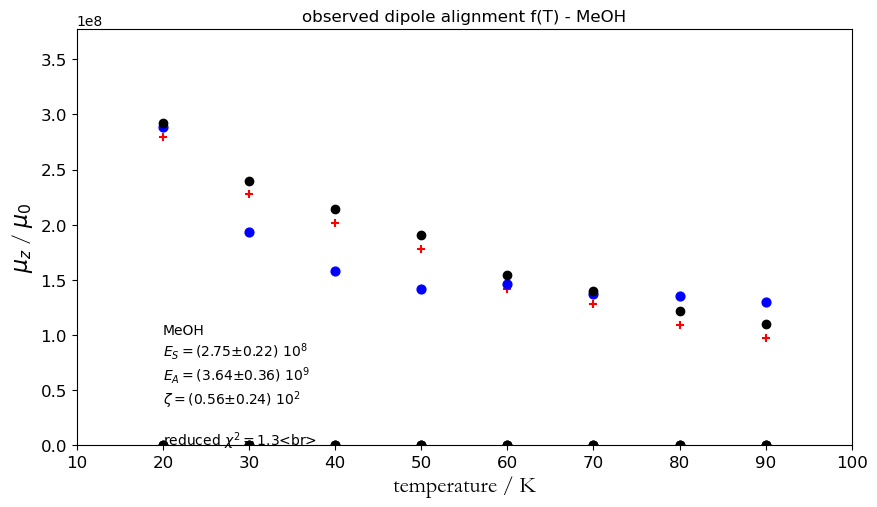

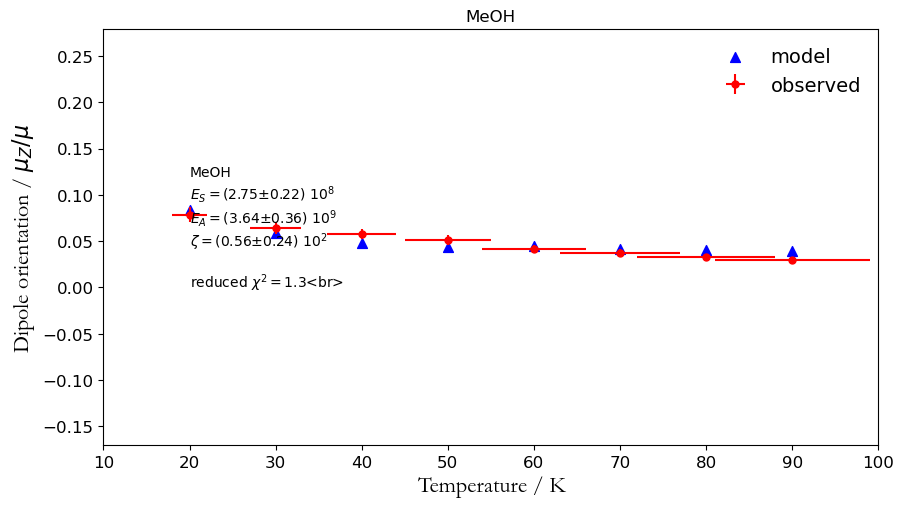

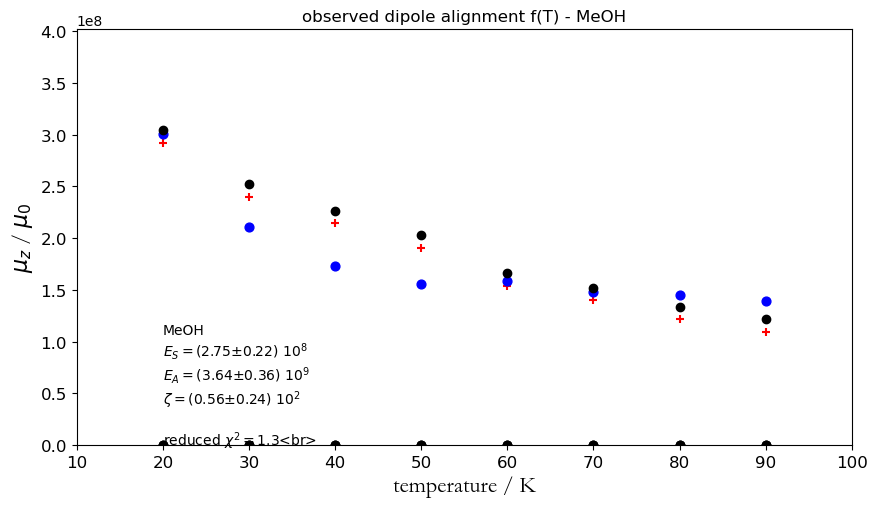

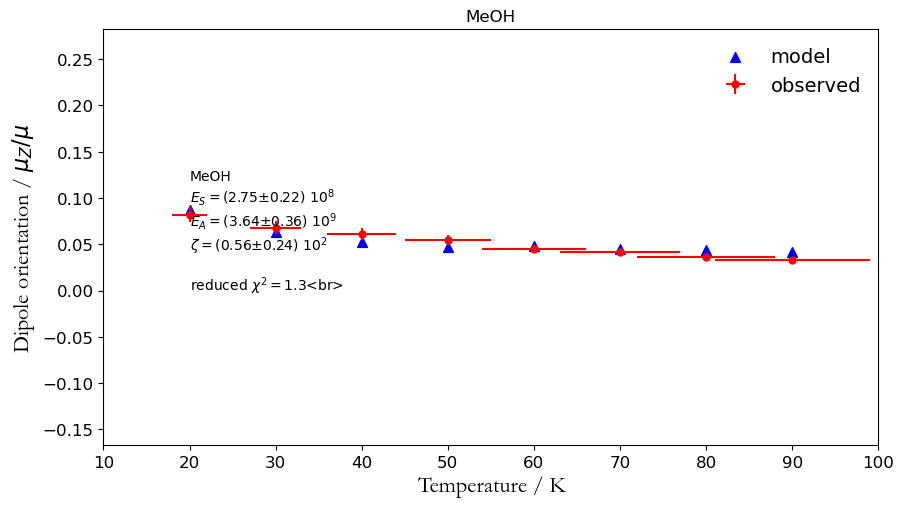

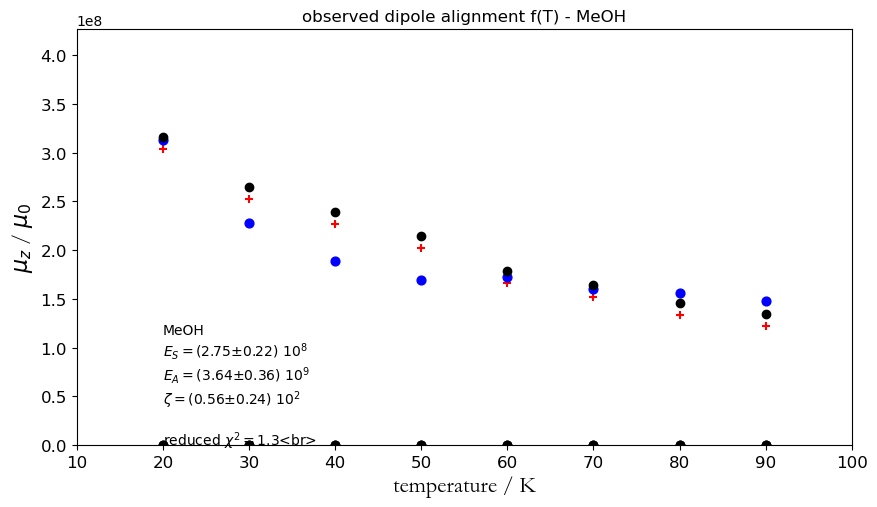

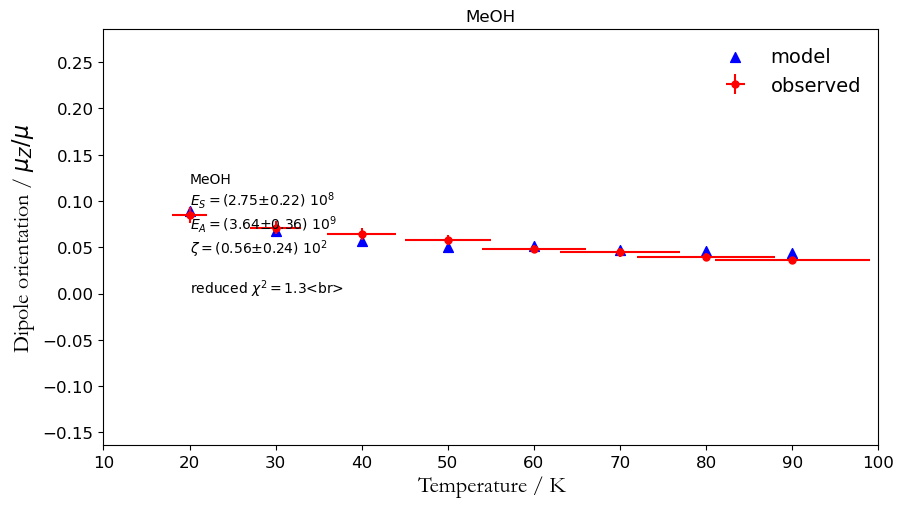

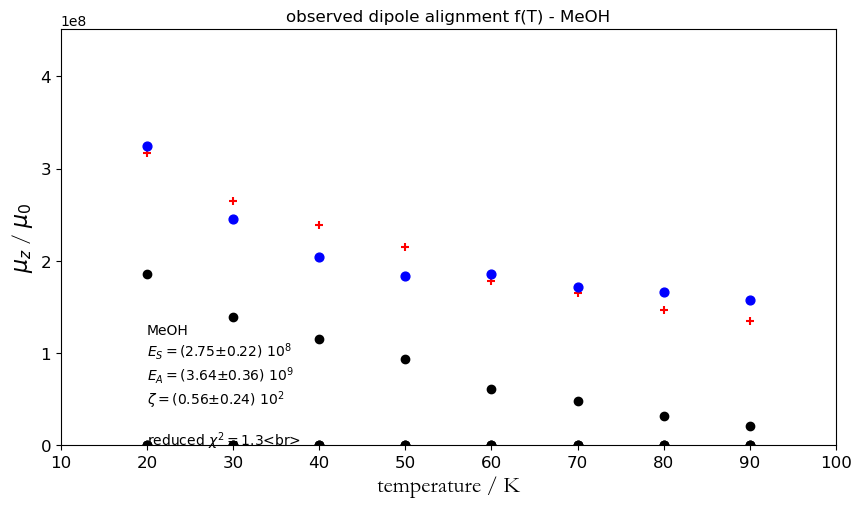

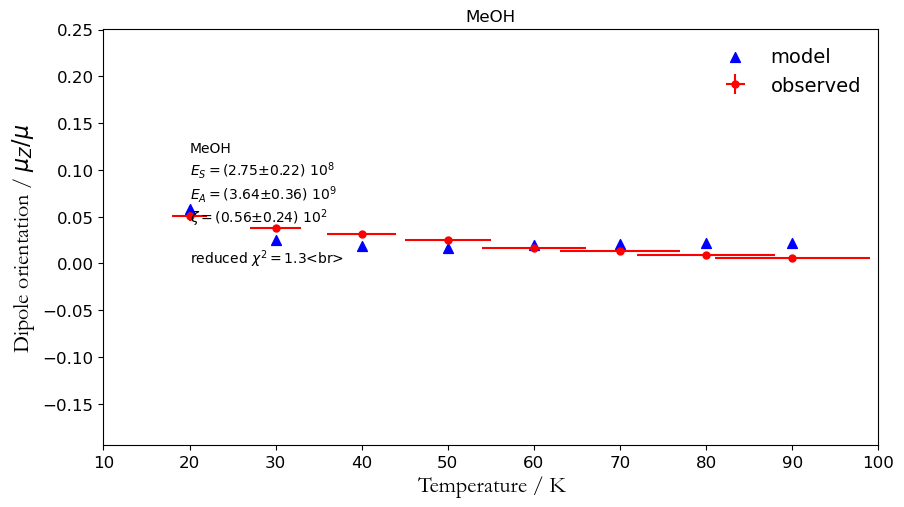

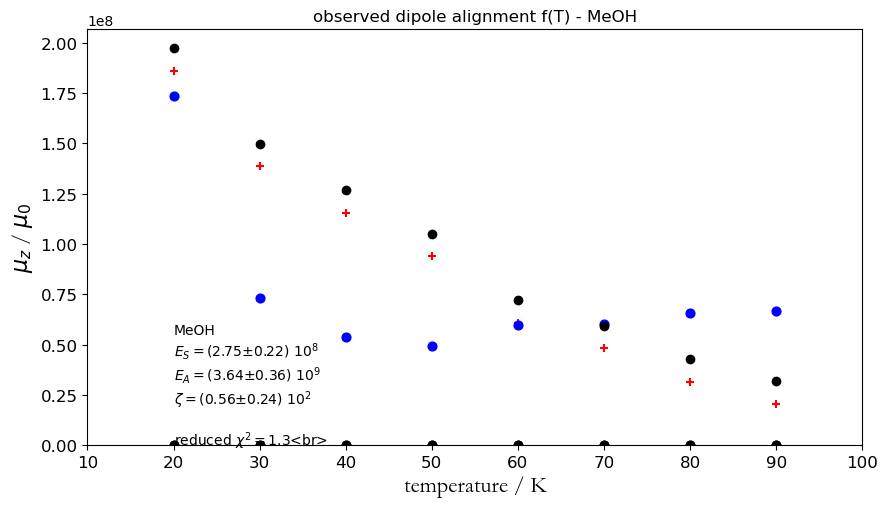

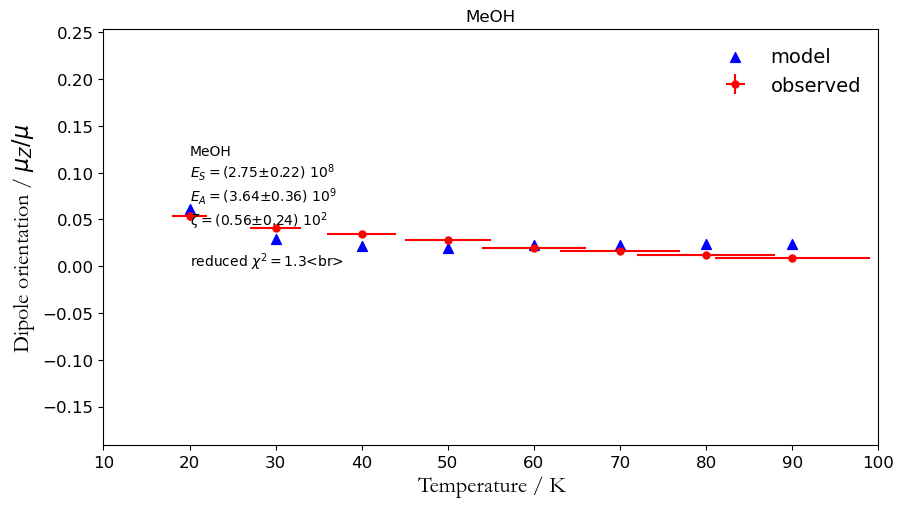

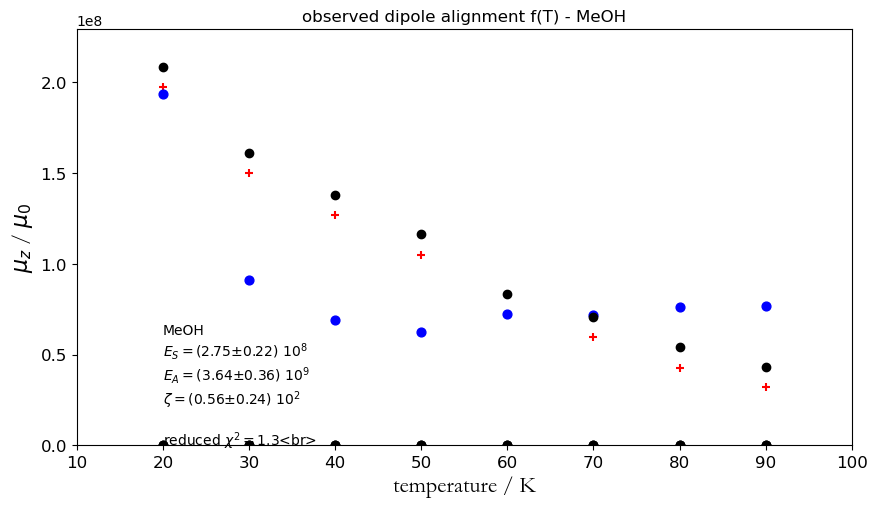

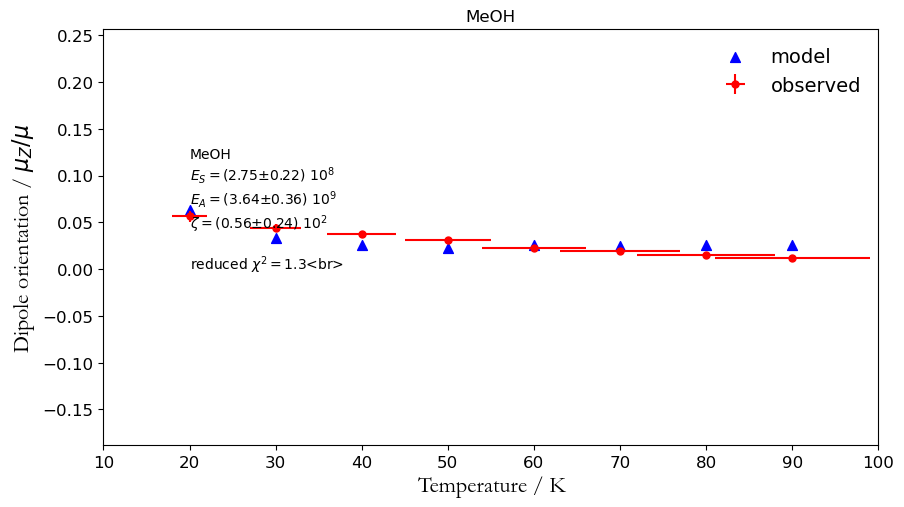

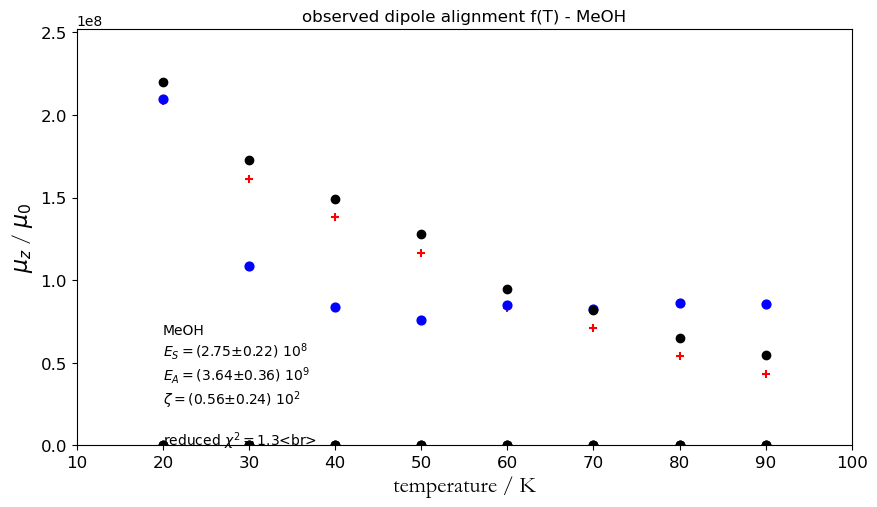

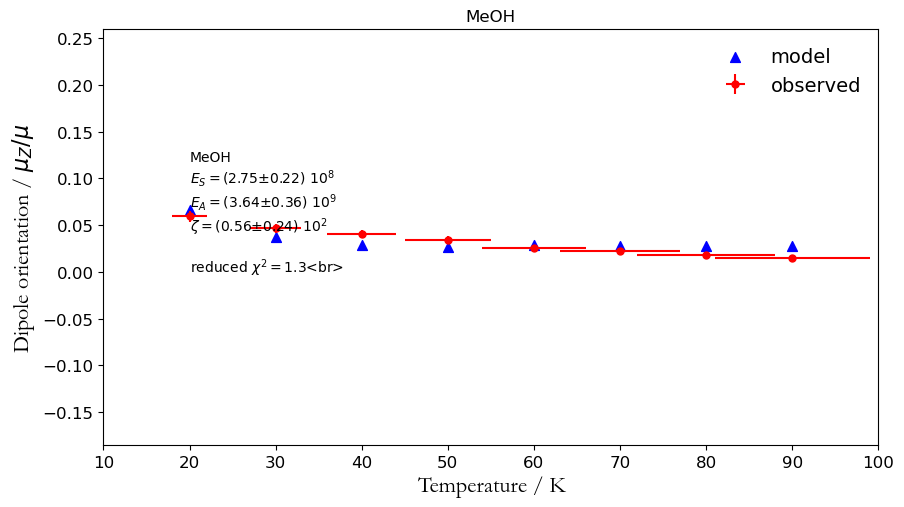

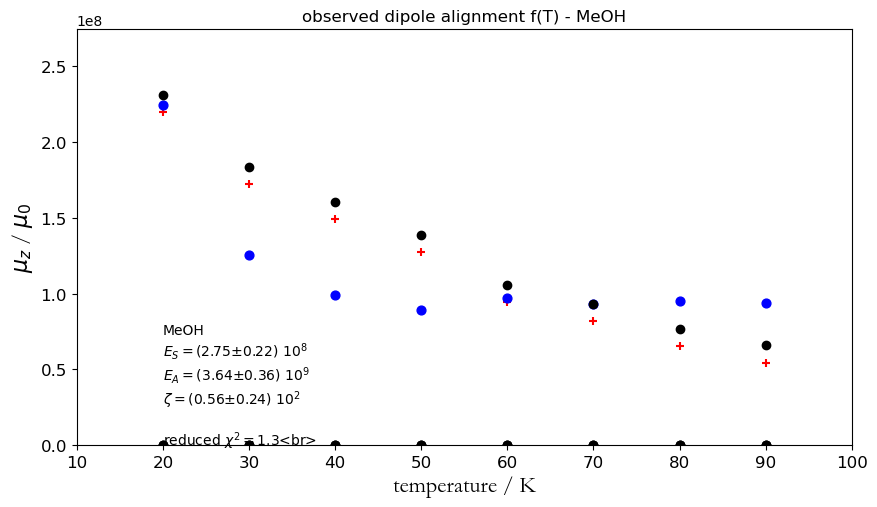

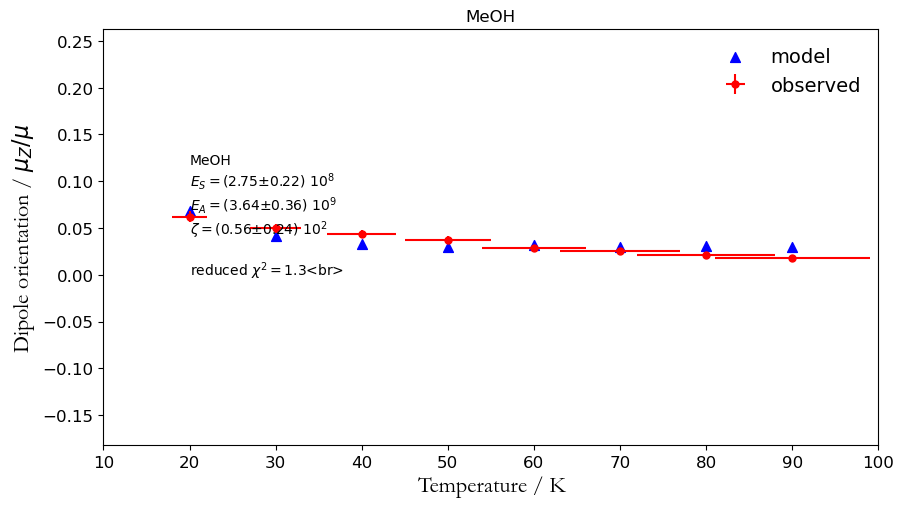

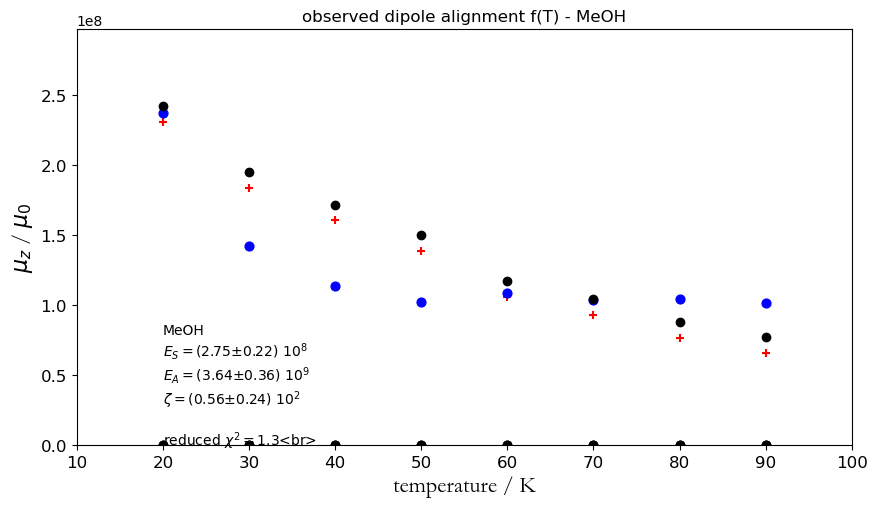

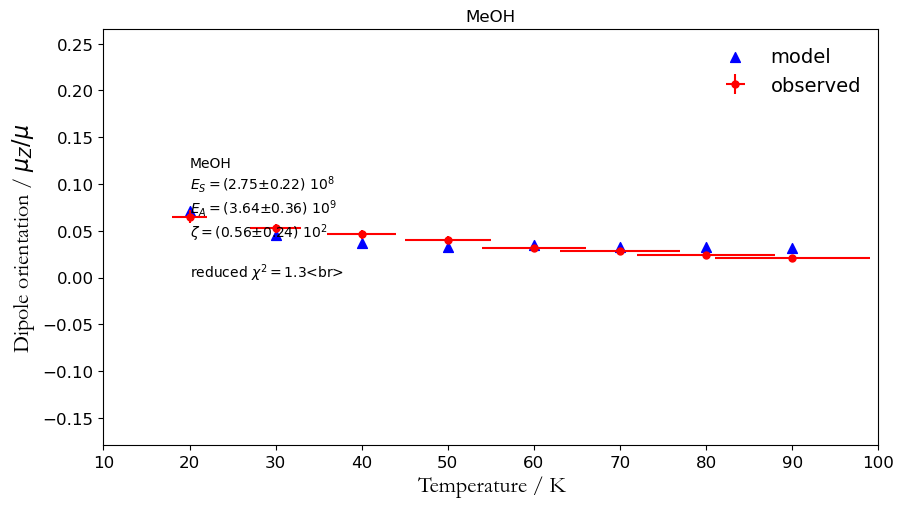

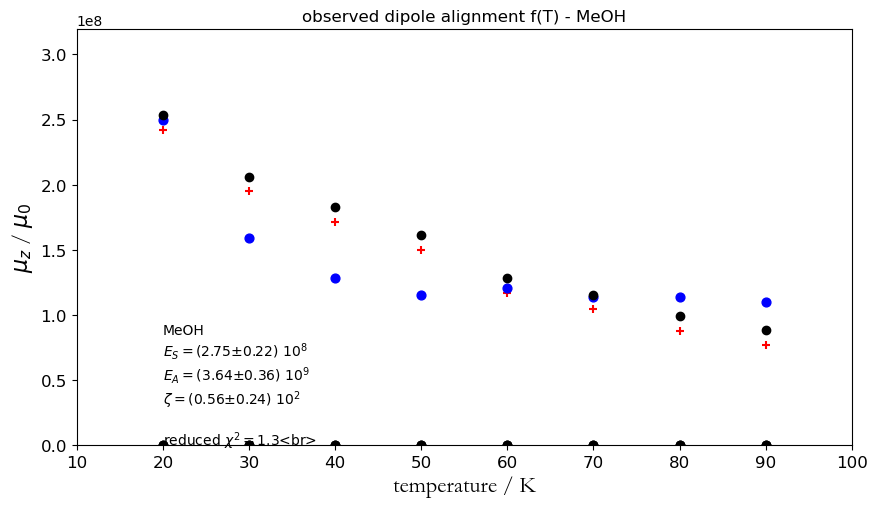

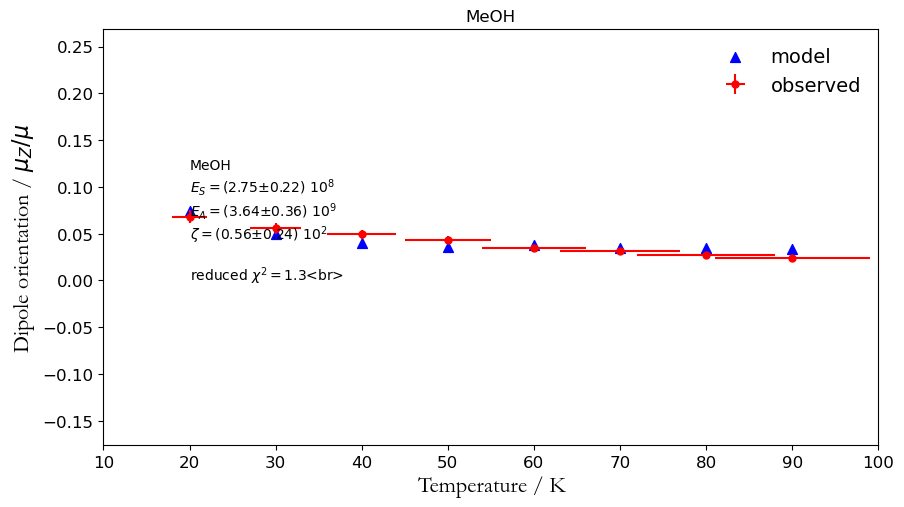

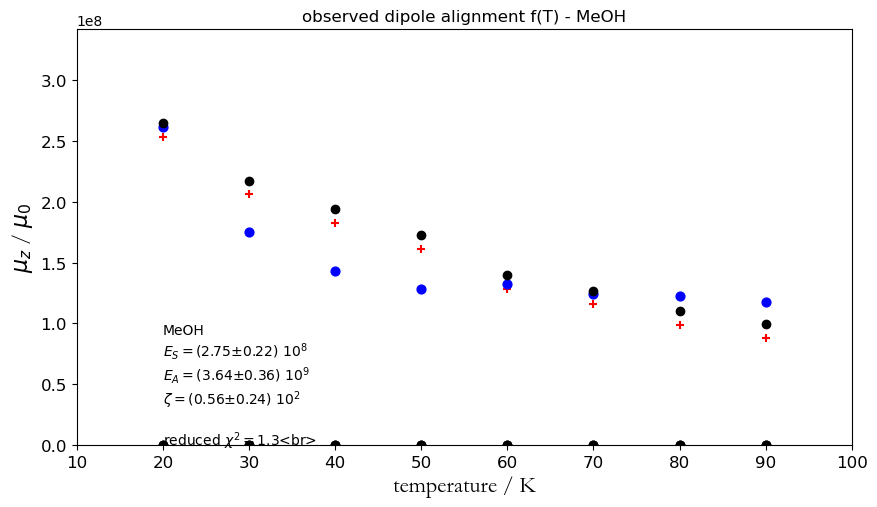

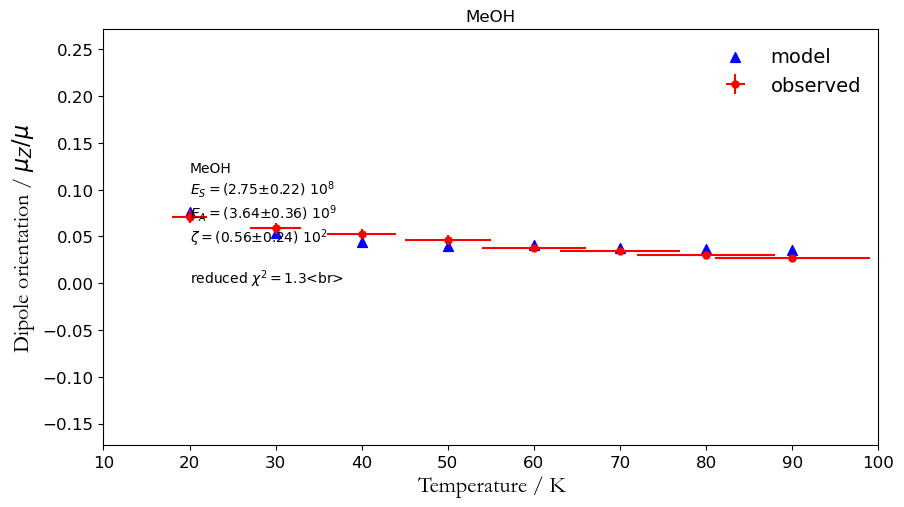

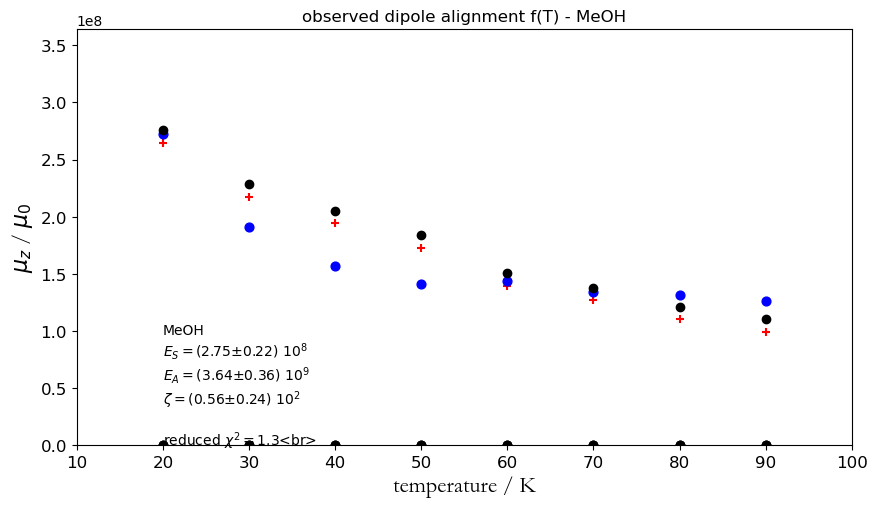

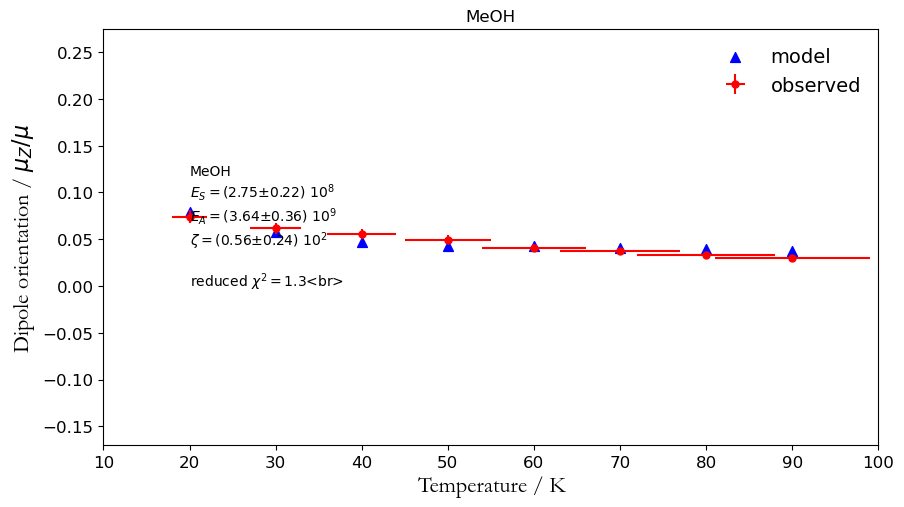

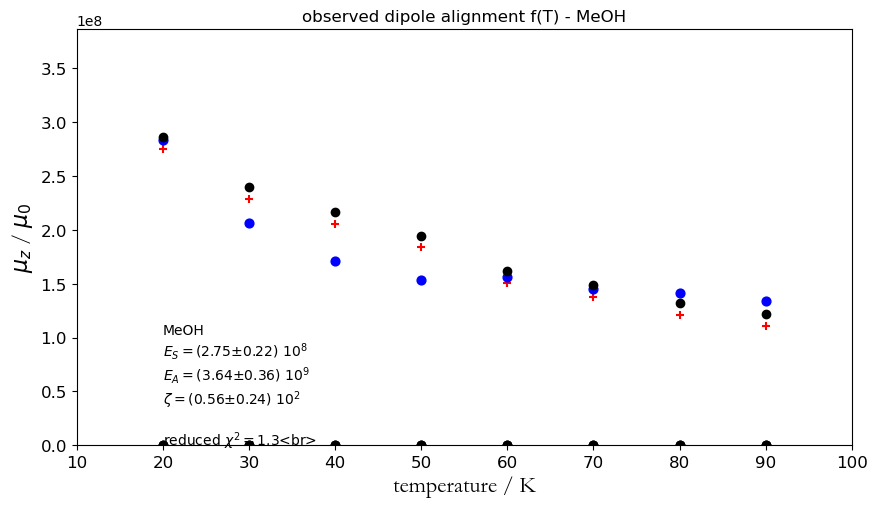

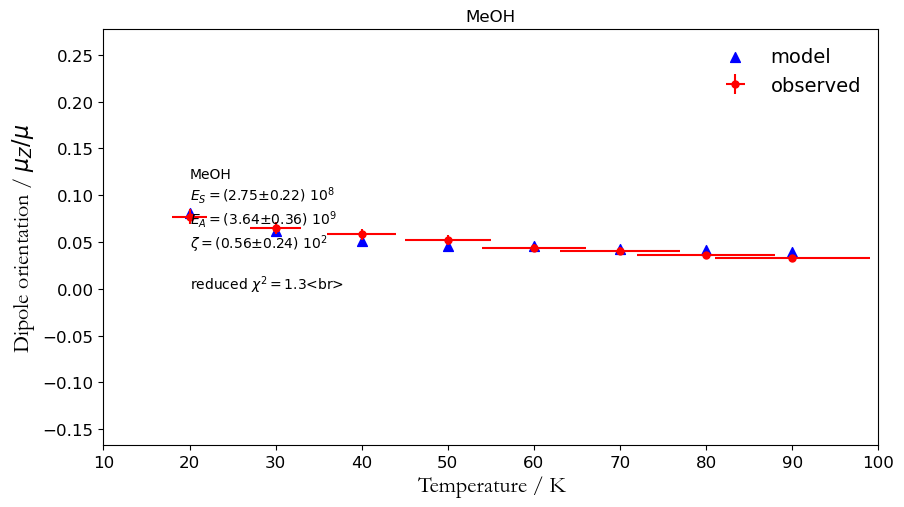

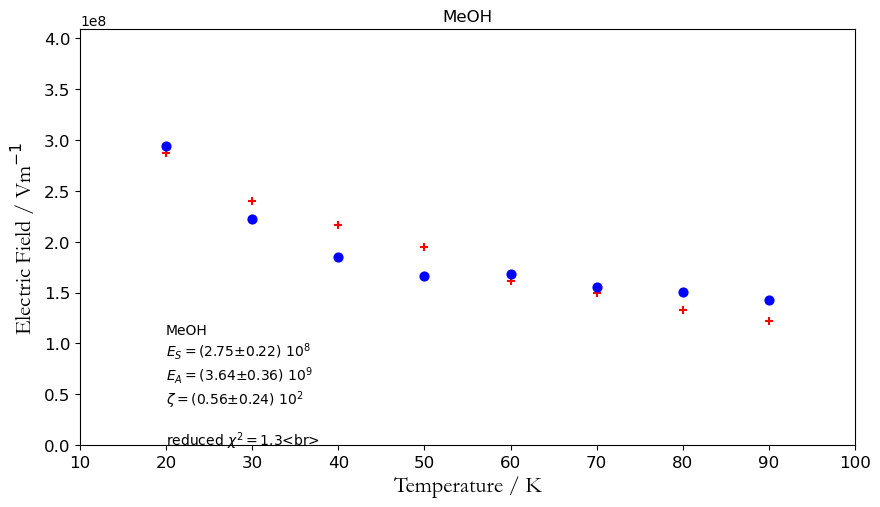

In [63]:
for r in [0.5,0.8,1.1,1.4, 1.7,2,2.3,2.6,2.9,3.2]: 
    
    for l0 in [127,127.1,127.2,127.3,127.4,127.5,127.6,127.7,127.8,127.9]:
        print(r)        
        print (l0)       
        
        os.chdir(working_dir)  
        df = pd.read_csv(filename+'.txt', delim_whitespace=True, header=None)
        xdataraw = df.iloc[:,0] #Temperature K
        ydataraw = df.iloc[:,1] #peak position nm

        T_array=xdataraw.to_numpy()
        xmin_mu=min(T_array - 10)
        xmax_mu=max(T_array + 10)

        xmin=min(T_array - 10)
        xmax=max(T_array + 10)

        plt.plot(xdataraw, ydataraw,'ko')
        plt.title('raw data '+ name)
        plt.xlabel('Temperature / K')
        plt.ylabel('$\lambda_{T}$ / eV')
        
        lambda_nm=ydataraw
        lambda_eV=1239.8/lambda_nm
        l0_eV=1239.8/l0

        DE_eV=(l0_eV-lambda_eV)
#convert things to atomic units
        T=xdataraw*3.16683e-6
        DE=DE_eV*0.036749405469679

        plt.plot(xdataraw, DE_eV,'ko')
        plt.title('energy change induced by the field on the exciton as f(Temp) ' +name)
        plt.xlabel('Temperature / K')
        plt.ylabel('Energy shift from $\lambda_{0}$ / eV')
        
        
        Esp_au=(1/96)*(
            -((32*DE)/r)
            +(
                (16*(2**(1/3))*DE*(6+DE*eps*r))
                /
                (r**3 *
                 ((((DE**2*eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
                  /
                  (r**(9/2))
                 )**(1/3)
                )
            )
            +
            (
                (8*(2**(2/3))*
                 ((((DE**2 *eps**2 *r**(0.5))*(-9+2*DE*eps*r))+3*(3**(0.5))*(-DE**3 *eps**3 *(32+DE*eps*r*(13+4*DE*eps*r)))**0.5)
                  /
                  (r**(9/2))
                 )**(1/3))
                /
                (eps))
        )

        Esp_Vm=Esp_au*5.14220652e+11
        Esp_Vm_array=Esp_Vm.to_numpy()
        ymin=min(Esp_Vm_array - Esp_Vm_array[-1])
        ymax=max(Esp_Vm_array + Esp_Vm_array[-1])

#print(name+' Esp in au:','\n', Esp)

        plt.plot(xdataraw, Esp_Vm, 'ko')
#plt.scatter(xdataraw, )
        plt.title('observed electric field f(T) - '+name)
        plt.xlabel('temperature / K')
        plt.ylabel('Esp / V/m')
        
        
        a = a_SI*18897259886**3   # polarizability in au
        s = (s_nm)*18.897  # estimated layer spacing converted to au
        mu_g = (mu_g_Debye*0.393456)  #  gas phase dipole converted to au

        mu_0 = mu_g/(1+a*k/s**3)    # dipole moment of molecule in solid state - converted to au
        print('dipole moment in the gas phase for '+name+' is', mu_g_Debye, 'Debye')
        print('dipole moment in the solid sate for '+name+' is', mu_0*2.541746, 'Debye')

        Omega = a/(0.0084161)**(3/4)  # I dont know where the 0.0084161 value comes from

        E_A=4*np.pi*mu_0/Omega
        E_A_Vm = E_A*5.14220652e+11
        print('Calculated value of E_A for '+name+' is ', E_A_Vm/1E9, 'x 10^9 V/m')

        degree_of_alignment=Esp_Vm/E_A_Vm
        muz_mu0_array=degree_of_alignment.to_numpy()
        ymin_mu=min(muz_mu0_array - 0.2)
        ymax_mu=max(muz_mu0_array + 0.2)

#print(degree_of_alignment)

        plt.plot(xdataraw, degree_of_alignment, 'ko')
#plt.scatter(xdataraw, )
        plt.title('observed dipole alignment f(T) - '+name)
        plt.xlabel('temperature / K')
        plt.ylabel('$\mu_{z}$ / $\mu_{0}$')
        
        length=(len(T_array))
        weight=np.ones(length)
        err_muz_mu0=0.1*(muz_mu0_array)
        err_T=0.1*(T_array)

        os.chdir(working_dir+'\\observed_data')
        data=np.column_stack((weight,muz_mu0_array,err_muz_mu0,T_array,err_T,Esp_Vm_array))#,mu_0,E_A_Vm))
        header='weight,y,sigma_y,Temperature,sigma_T,Observed_field'

        with open('data for_'+name+'.csv', mode='w', ) as newfile: 
            np.savetxt(newfile,data, header=header,delimiter=',',comments='') 
    
        os.chdir(working_dir)  
        
        os.chdir(working_dir+'\\observed_data')
        SpontelData = pandas.read_csv('data for_'+name+'.csv')
      #  SpontelData_dict[name] =  (SpontelData)

        SpontelData.head()
        


    #
    # Main driver programme for fitting Spontelectric field data
    # 
    # Define several conversion factors to/from atomic units
    # conversion of Temp to a.u. : T [a.u.]= T [K]/factor
        Ttoau=315770.0
    # conversion of D to a.u. : 1 D (=Debye) = factor [a.u.]
        Debye=0.393456
    # Convert el. field in a.u. To V/m : E [a.u.] = E [V/m]/factor
        Etoau=5.142e11
 
        htfc=numpy.array([0.0]*4)
 
    # Find the value of mu for this ice 
        IceMu=mu_0
    
    # Provide a first guess value for the parameter E_A
        EAnxt=E_A_Vm
    
        htfc[0]=1.0
        htfc[1]=0.0
        htfc[2]=0.0
        htfc[3]=0.0
    
        weight=numpy.array(SpontelData.weight)
        ndata=len(weight)
    # y is the same as <mu_Z>/mu, Temp is the deposition temperature in [K]
    # sig are the 1-sigma measurement errors
    # E observed is the observed Electric field in units [V/m]
        y=numpy.array(SpontelData.y)
        sigy=numpy.array(SpontelData.sigma_y)
        Temp=numpy.array(SpontelData.Temperature)
        sigT=numpy.array(SpontelData.sigma_T)
        Eobs=numpy.array(SpontelData.Observed_field)
    #
    # here comes a block of variable declarations
        whtsum=0.0
        yinvmn=0.0
        hTfunc=numpy.array([0.0]*ndata)
        DerhTfunc=numpy.array([0.0]*ndata)
        DerGT=numpy.array([0.0]*ndata)
        DerGy=numpy.array([0.0]*ndata)
        PartDerv=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
        xdat=numpy.array([[0.0]*ndata,[0.0]*ndata])
        ydat=numpy.array([0.0]*ndata)
        zdat=numpy.array([0.0]*ndata)
        ymodel=numpy.array([0.0]*ndata)
        DParDy=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
        DParDT=numpy.array([[0.0]*ndata,[0.0]*ndata,[0.0]*ndata])
        SigPar=numpy.array([0.0]*3)
#
#
# Auxiliary functions f_0, f_1, f_2, and f_3 are needed as input for linear least-squares
# These are named here as PartDerv[0,], ..., PartDerv[3,] because these are also the
# partial derivatives of the function G with respect to T and y.
        for i in range(0,ndata):
            yinvmn+=weight[i]/y[i]
            whtsum+=weight[i]
            hTfunc[i]=htfc[0]+Temp[i]*(htfc[1]+Temp[i]*(htfc[2]+Temp[i]*htfc[3]))
            DerhTfunc[i]=htfc[1]+Temp[i]*(2.0*htfc[2]+3.0*Temp[i]*htfc[3])
            PartDerv[0,i]=(1-y[i])*LangevInv(y[i])
            PartDerv[1,i]=Ttoau*Debye*IceMu*(y[i]-1.0)/Temp[i]
            PartDerv[2,i]=-1.0*PartDerv[1,i]*y[i]
            PartDerv[3,i]=PartDerv[1,i]*y[i]*y[i]*hTfunc[i]
#
# start the iteration to get the parameters, initialise a choice for E_A
        yinvmn=yinvmn/whtsum
        EAcur=1.1*EAnxt
        itcnt=0
        while ((abs(EAnxt/EAcur-1.0)>1.0e-3) and (itcnt<20)) :
            itcnt+=1
            EAcur=EAnxt
            for i in range(0,ndata):
                xdat[0,i]=PartDerv[1,i]
                xdat[1,i]=PartDerv[3,i]
                ydat[i]=-1.0*(PartDerv[0,i]+EAcur*PartDerv[2,i]/Etoau)
#
            Constrout=ConstrLSQ(xdat,ydat,weight)
#
# FPP (02/06/2022): here E_S and zeta always are forced to be >= 0
            EScur=abs(Constrout[0]*Etoau)
            ESzetacur=abs(Constrout[1]*Etoau)
            ratiolog=0.0
            for i in range(0,ndata) :
                Ezmod=(EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
                ratiolog+=weight[i]*(math.log(abs(EAcur*Langevin(Ezmod)))-math.log(Eobs[i]))
                DerGy[i]=(EScur-ESzetacur*hTfunc[i]*y[i]*(2.0-3.0*y[i])+EAcur*(1.0-2.0*y[i]))*IceMu*Ttoau*Debye/Etoau/Temp[i]
                DerGy[i]+=-1.0*LangevInv(y[i])+(1.0-y[i])*DerLangevInv(y[i])
                DerGT[i]=(EScur*(1-y[i])-EAcur*y[i]*(1-y[i])+ESzetacur*hTfunc[i]*y[i]*y[i]*(1-y[i]))*IceMu*Ttoau*Ttoau*Debye/Etoau/Temp[i]/Temp[i]
                DerGT[i]+=-1.*ESzetacur*DerhTfunc[i]*y[i]*y[i]*(1-y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i]
            ratiolog=ratiolog/whtsum
            if ((Constrout[0]<0) and (EAcur<0) and (yinvmn<0) and (ratiolog>0)) :
                EAnxt=EAcur+2.0*yinvmn*EScur
            else :
                EAnxt=EAcur/math.exp(ratiolog)
            if (itcnt>19) : 
                print ("iteration count exceeded: not converged")
#
# G(T,y)\equiv\left(1-y\right)L^{-1}(y)-\frac{\mu}{T}\left\{ E_S\left[1-y+\zeta (y^2 -y^3)\right] 
#          -E_A(y-y^2) \right\}
# dG/dy=-L^{-1}(y)+\left(1-y\right)\frac{\d L^{-1}(y)}{dy}-\frac{\mu}{T}\left\{ 
#           E_S\left[-1+\zeta h(T) (2y -3y^2)\right] -E_A(1-2y) \right\}
# dG/dT=\frac{\mu}{T^2}\left\{ E_S\left[1-y+\zeta_0 h(T) (y^2 -y^3)\right] -E_A(y-y^2) \right\}-\frac{\mu}{T}
#           E_S\zeta_0\frac{d h(T)}{dT} (y^2 -y^3)
#
# for the calculation of the uncertainty margins for the parameters the partial derivatives below are needed
#
# also calculate the quality of the fit (chi-square) dlsqsum
        dlsqsum=0
        for i in range(0,ndata) :
            ymodel[i]=Langevin((EScur-EAcur*y[i]+ESzetacur*hTfunc[i]*y[i]*y[i])*IceMu*Ttoau*Debye/Etoau/Temp[i])
            DelMod=y[i]-ymodel[i]
            dlsqsum+=weight[i]*DelMod*DelMod/sigy[i]/sigy[i]
        #print(i,weight[i]*DelMod*DelMod/sigy[i]/sigy[i])
            DParDy[0,i]=-1.0*DerGy[i]/PartDerv[1,i]
            DParDy[1,i]=-1.0*DerGy[i]/PartDerv[2,i]
            DParDy[2,i]=-1.0*DerGy[i]/PartDerv[3,i]
            DParDT[0,i]=-1.0*DerGT[i]/PartDerv[1,i]
            DParDT[1,i]=-1.0*DerGT[i]/PartDerv[2,i]
            DParDT[2,i]=-1.0*DerGT[i]/PartDerv[3,i]
#
        dlsqsum=dlsqsum/(whtsum-2)
# calculate the 1-sigma uncertainties for the parameters
        for k in range(0,3):
            for i in range(0,ndata) :
                SigPar[k]+=weight[i]*(DParDy[k,i]*DParDy[k,i]*sigy[i]*sigy[i]+DParDT[k,i]*DParDT[k,i]*sigT[i]*sigT[i]/Ttoau/Ttoau)
            SigPar[k]=Etoau*math.sqrt(SigPar[k]/whtsum)

#set up figures to show fit results
#ymin_mu=(SpontelData.ymin.iloc[0])
#ymax_mu=(SpontelData.ymax.iloc[0])
#xmin_mu=(SpontelData.xmin.iloc[0])
#xmax_mu=(SpontelData.xmax.iloc[0])
#ymin=(SpontelData.ymin.iloc[1])
#ymax=(SpontelData.ymax.iloc[1])
#xmin=(SpontelData.xmin.iloc[1])
#xmax=(SpontelData.xmax.iloc[1])
#ticks=[SpontelData.ticks.iloc[0:3]]
    
      
        FigureMu(Temp,ymodel,y,sigT,sigy,xmin_mu,xmax_mu,ymin_mu,ymax_mu,name)


        #SpontelData_dict[name]['alignment_model'] = ymodel.tolist()
        ymodel=EAcur*ymodel
        FigureE(Temp,ymodel,Eobs,xmin,xmax,ymin,ymax,name)
       # SpontelData_dict[name]['Efield'] = ymodel.tolist()
    
    #display(SpontelData.head()) 
    
        zetacur=ESzetacur/EScur
        
        SigPar[2]=zetacur*math.sqrt(SigPar[2]*SigPar[2]/ESzetacur/ESzetacur+SigPar[0]*SigPar[0]/EScur/EScur)
        string = name
        string+="<br>"+"$E_S =$"+NeaterOut(EScur,SigPar[0])
        string+="<br>"+"$E_A =$"+NeaterOut(EAcur,SigPar[1])
        string+="<br>"+"$\zeta =$"+NeaterOut(zetacur,SigPar[2])
        string+="<br><br>"+"reduced $\chi^2 =$"+'{0:.1f}'.format(dlsqsum)+"<br>"
        display(Markdown(string)) #Use this line to see the individual results for fitting parameters per dataset
    
        ES=NeaterOut(EScur,SigPar[0])
        EA=NeaterOut(EAcur,SigPar[1])
        zeta=NeaterOut(zetacur,SigPar[2])
    
        os.chdir(working_dir)  

      #  print("r =" + r)
       # print("l0 =" + l0)
        
        
        
        
        
        